# Telecom churn case study

## Business problem

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

So we need to analyse telecom industry data and predict high value customers who are at high risk of churn and identify main indicators of churn

In [3]:
# Load libraries
import numpy as np
import pandas as pd

import datetime as dt

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
sns.set(style="ticks")
%matplotlib inline

from scipy.stats import norm
from scipy import stats

import sklearn
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings("ignore")

## Load the data

In [5]:
data = pd.read_csv(r'D:\DATA SCIENCE AND AI\machine learning\churn data\telecom_churn_data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB


In [7]:
data.head()

mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0     7000842753        109             0.0             0.0             0.0   
1     7001865778        109             0.0             0.0             0.0   
2     7001625959        109             0.0             0.0             0.0   
3     7001204172        109             0.0             0.0             0.0   
4     7000142493        109             0.0             0.0             0.0   

  last_date_of_month_6 last_date_of_month_7 last_date_of_month_8  \
0            6/30/2014            7/31/2014            8/31/2014   
1            6/30/2014            7/31/2014            8/31/2014   
2            6/30/2014            7/31/2014            8/31/2014   
3            6/30/2014            7/31/2014            8/31/2014   
4            6/30/2014            7/31/2014            8/31/2014   

  last_date_of_month_9   arpu_6   arpu_7   arpu_8   arpu_9  onnet_mou_6  \
0            9/30/2014  197.385  214.816  213.803   21.100          NaN   
1            9/30/2014   34.047  355.074  268.321   86.285        24.11   
2            9/30/2014  167.690  189.058  210.226  290.714        11.54   
3            9/30/2014  221.338  251.102  508.054  389.500        99.91   
4            9/30/2014  261.636  309.876  238.174  163.426        50.31   

   onnet_mou_7  onnet_mou_8  onnet_mou_9  offnet_mou_6  offnet_mou_7  \
0          NaN         0.00          NaN           NaN           NaN   
1        78.68         7.68        18.34         15.74         99.84   
2        55.24        37.26        74.81        143.33        220.59   
3        54.39       310.98       241.71        123.31        109.01   
4       149.44        83.89        58.78         76.96         91.88   

   offnet_mou_8  offnet_mou_9  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
0          0.00           NaN            NaN            NaN           0.00   
1        304.76         53.76            0.0           0.00           0.00   
2        208.36        118.91            0.0           0.00           0.00   
3         71.68        113.54            0.0          54.86          44.38   
4        124.26         45.81            0.0           0.00           0.00   

   roam_ic_mou_9  roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  roam_og_mou_9  \
0            NaN            NaN            NaN           0.00            NaN   
1           0.00            0.0           0.00           0.00           0.00   
2          38.49            0.0           0.00           0.00          70.94   
3           0.00            0.0          28.09          39.04           0.00   
4           0.00            0.0           0.00           0.00           0.00   

   loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2t_mou_9  \
0               NaN               NaN              0.00               NaN   
1             23.88             74.56              7.68             18.34   
2              7.19             28.74             13.58             14.39   
3             73.68             34.81             10.61             15.49   
4             50.31            149.44             83.89             58.78   

   loc_og_t2m_mou_6  loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2m_mou_9  \
0               NaN               NaN              0.00               NaN   
1             11.51             75.94            291.86             53.76   
2             29.34             16.86             38.46             28.16   
3            107.43             83.21             22.46             65.46   
4             67.64             91.88            124.26             37.89   

   loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  loc_og_t2f_mou_9  \
0               NaN               NaN              0.00               NaN   
1              0.00              0.00              0.00              0.00   
2             24.11             21.79             15.61             22.24   
3              1.91              0.65              

## Churn definition

Customers who have not done any usage, either incoming or outgoing - in terms of calls, internet etc. over a period of time.
In our analysis we are concentrating on high value customers, as approximately 80% of revenue comes from the top 20% customers. Thus, if we can reduce churn of the high-value customers, we will be able to reduce significant revenue leakage. <br>

Our dataset is divided into 3 phases: <br>
Good phase wherein the customer is happy with the service <br>
Action pase wherein the customer wasn't happy with service or got a better offer from competitor etc. In this phase, the customer usually shows different behaviour than the good phase. Also, it is crucial to identify high-churn-risk customers in this phase, so that some corrective actions can be taken at this point to prevet churn <br>
Churn phase wherein the customer would have churned

High-value customers are those who have recharged with an amount more than or equal to X, where X is the 70th percentile of the average recharge amount in the first two months (the good phase). <br>
After identifying high value customers, we will tag churn customers based on those who have not made any calls (either incoming or outgoing) and have not used mobile internet even once in the churn phase. <br>

Let's first identify high-value customers

In [11]:
data['total_data_rech_6'] = data['total_rech_data_6'] * data['av_rech_amt_data_6']
data['total_data_rech_7'] = data['total_rech_data_7'] * data['av_rech_amt_data_7']

data['amt_data_6'] = data[['total_rech_amt_6','total_data_rech_6']].sum(axis=1)
data['amt_data_7'] = data[['total_rech_amt_7','total_data_rech_7']].sum(axis=1)

data['AVG_amt_data_6_7'] = data[['amt_data_6','amt_data_7']].mean(axis=1)

In [13]:
data.head()

mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0     7000842753        109             0.0             0.0             0.0   
1     7001865778        109             0.0             0.0             0.0   
2     7001625959        109             0.0             0.0             0.0   
3     7001204172        109             0.0             0.0             0.0   
4     7000142493        109             0.0             0.0             0.0   

  last_date_of_month_6 last_date_of_month_7 last_date_of_month_8  \
0            6/30/2014            7/31/2014            8/31/2014   
1            6/30/2014            7/31/2014            8/31/2014   
2            6/30/2014            7/31/2014            8/31/2014   
3            6/30/2014            7/31/2014            8/31/2014   
4            6/30/2014            7/31/2014            8/31/2014   

  last_date_of_month_9   arpu_6   arpu_7   arpu_8   arpu_9  onnet_mou_6  \
0            9/30/2014  197.385  214.816  213.803   21.100          NaN   
1            9/30/2014   34.047  355.074  268.321   86.285        24.11   
2            9/30/2014  167.690  189.058  210.226  290.714        11.54   
3            9/30/2014  221.338  251.102  508.054  389.500        99.91   
4            9/30/2014  261.636  309.876  238.174  163.426        50.31   

   onnet_mou_7  onnet_mou_8  onnet_mou_9  offnet_mou_6  offnet_mou_7  \
0          NaN         0.00          NaN           NaN           NaN   
1        78.68         7.68        18.34         15.74         99.84   
2        55.24        37.26        74.81        143.33        220.59   
3        54.39       310.98       241.71        123.31        109.01   
4       149.44        83.89        58.78         76.96         91.88   

   offnet_mou_8  offnet_mou_9  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
0          0.00           NaN            NaN            NaN           0.00   
1        304.76         53.76            0.0           0.00           0.00   
2        208.36        118.91            0.0           0.00           0.00   
3         71.68        113.54            0.0          54.86          44.38   
4        124.26         45.81            0.0           0.00           0.00   

   roam_ic_mou_9  roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  roam_og_mou_9  \
0            NaN            NaN            NaN           0.00            NaN   
1           0.00            0.0           0.00           0.00           0.00   
2          38.49            0.0           0.00           0.00          70.94   
3           0.00            0.0          28.09          39.04           0.00   
4           0.00            0.0           0.00           0.00           0.00   

   loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2t_mou_9  \
0               NaN               NaN              0.00               NaN   
1             23.88             74.56              7.68             18.34   
2              7.19             28.74             13.58             14.39   
3             73.68             34.81             10.61             15.49   
4             50.31            149.44             83.89             58.78   

   loc_og_t2m_mou_6  loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2m_mou_9  \
0               NaN               NaN              0.00               NaN   
1             11.51             75.94            291.86             53.76   
2             29.34             16.86             38.46             28.16   
3            107.43             83.21             22.46             65.46   
4             67.64             91.88            124.26             37.89   

   loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  loc_og_t2f_mou_9  \
0               NaN               NaN              0.00               NaN   
1              0.00              0.00              0.00              0.00   
2             24.11             21.79             15.61             22.24   
3              1.91              0.65              

In [15]:
data[['total_rech_amt_6','total_rech_amt_7','AVG_amt_data_6_7']].quantile(np.linspace(.1, 1, 9, 0))

total_rech_amt_6  total_rech_amt_7  AVG_amt_data_6_7
0.1               0.0               0.0              60.0
0.2              80.0              65.0             108.5
0.3             120.0             110.0             155.0
0.4             170.0             160.0             209.5
0.5             230.0             220.0             275.0
0.6             290.0             283.0             360.0
0.7             378.0             370.0             478.0
0.8             504.0             500.0             656.5
0.9             732.0             731.0            1028.0

As per the definition of high value customers are those whose recharge amount should be more than or equal to 70th percentile. <br>

But if we use greater than or equal to, we end up getting a little above 30K records as against to 29.9K records. <br>
So, if we conisder only  greater than, then we get 29.9K records. <br>
Therefore we have considered greater than to filter high value customers

In [18]:
df = data[(data['AVG_amt_data_6_7']> data['AVG_amt_data_6_7'].quantile(0.7))]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29953 entries, 0 to 99997
Columns: 231 entries, mobile_number to AVG_amt_data_6_7
dtypes: float64(184), int64(35), object(12)
memory usage: 53.0+ MB


## Churn customers
<br>
Identifying churn high value customers based on the last month i.e. month 9

In [21]:
df['churn_flag'] = np.where(
                            ((df['total_ic_mou_9'] == 0.00) | (df['total_og_mou_9'] == 0.00))
                            & ((df['vol_2g_mb_9'] == 0.00) | (df['vol_3g_mb_9'] == 0.00))
                            , 1, 0
                           )

In [23]:
print(df['churn_flag'].value_counts())
print(df['churn_flag'].value_counts()/df.shape[0])

churn_flag
0    26698
1     3255
Name: count, dtype: int64
churn_flag
0    0.89133
1    0.10867
Name: count, dtype: float64


Let's drop all features related to churn phase i.e. 9th month

In [26]:
df = df.drop(df.filter(regex='_9|sep', axis = 1).columns, axis=1)

In [32]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 29953 entries, 0 to 99997
Data columns (total 177 columns):
 #    Column                    Non-Null Count  Dtype  
---   ------                    --------------  -----  
 0    mobile_number             29953 non-null  int64  
 1    circle_id                 29953 non-null  int64  
 2    loc_og_t2o_mou            29730 non-null  float64
 3    std_og_t2o_mou            29730 non-null  float64
 4    loc_ic_t2o_mou            29730 non-null  float64
 5    last_date_of_month_6      29953 non-null  object 
 6    last_date_of_month_7      29926 non-null  object 
 7    last_date_of_month_8      29788 non-null  object 
 8    arpu_6                    29953 non-null  float64
 9    arpu_7                    29953 non-null  float64
 10   arpu_8                    29953 non-null  float64
 11   onnet_mou_6               29411 non-null  float64
 12   onnet_mou_7               29417 non-null  float64
 13   onnet_mou_8               28781 non-null  float64

Let's check if we have missing values in the dataset?

In [35]:
df.isna().sum()

mobile_number                   0
circle_id                       0
loc_og_t2o_mou                223
std_og_t2o_mou                223
loc_ic_t2o_mou                223
last_date_of_month_6            0
last_date_of_month_7           27
last_date_of_month_8          165
arpu_6                          0
arpu_7                          0
arpu_8                          0
onnet_mou_6                   542
onnet_mou_7                   536
onnet_mou_8                  1172
offnet_mou_6                  542
offnet_mou_7                  536
offnet_mou_8                 1172
roam_ic_mou_6                 542
roam_ic_mou_7                 536
roam_ic_mou_8                1172
roam_og_mou_6                 542
roam_og_mou_7                 536
roam_og_mou_8                1172
loc_og_t2t_mou_6              542
loc_og_t2t_mou_7              536
loc_og_t2t_mou_8             1172
loc_og_t2m_mou_6              542
loc_og_t2m_mou_7              536
loc_og_t2m_mou_8             1172
loc_og_t2f_mou

In [37]:
# Let's have a look at missing values - how many are there & also get their percencentages
pd.options.display.float_format = '{:.2f}'.format
missing_values = pd.DataFrame((df.isnull().sum()/len(df))*100).reset_index().rename(columns = {'index': 'feature', 0: 'Missing%'}).sort_values('Missing%',ascending = False)
missing_values

feature  Missing%
145                 arpu_3g_8     46.80
151          night_pck_user_8     46.80
121  date_of_last_rech_data_8     46.80
127           max_rech_data_8     46.80
130           count_rech_2g_8     46.80
133           count_rech_3g_8     46.80
136        av_rech_amt_data_8     46.80
124         total_rech_data_8     46.80
166                 fb_user_8     46.80
148                 arpu_2g_8     46.80
149          night_pck_user_6     44.11
122         total_rech_data_6     44.11
134        av_rech_amt_data_6     44.11
119  date_of_last_rech_data_6     44.11
131           count_rech_3g_6     44.11
146                 arpu_2g_6     44.11
128           count_rech_2g_6     44.11
143                 arpu_3g_6     44.11
171         total_data_rech_6     44.11
125           max_rech_data_6     44.11
164                 fb_user_6     44.11
165                 fb_user_7     43.12
120  date_of_last_rech_data_7     43.12
123         total_rech_data_7     43.12
147                 arpu_2g_7     43.12
129           count_rech_2g_7     43.12
132           count_rech_3g_7     43.12
135        av_rech_amt_data_7     43.12
172         total_data_rech_7     43.12
150          night_pck_user_7     43.12
144                 arpu_3g_7     43.12
126           max_rech_data_7     43.12
49           std_og_t2c_mou_8      3.91
55               isd_og_mou_8      3.91
58               spl_og_mou_8      3.91
61                og_others_8      3.91
67           loc_ic_t2t_mou_8      3.91
70           loc_ic_t2m_mou_8      3.91
85           std_ic_t2f_mou_8      3.91
76               loc_ic_mou_8      3.91
79           std_ic_t2t_mou_8      3.91
82           std_ic_t2m_mou_8      3.91
91               std_ic_mou_8      3.91
97               spl_ic_mou_8      3.91
100              isd_ic_mou_8      3.91
103               ic_others_8      3.91
52               std_og_mou_8      3.91
88           std_ic_t2o_mou_8      3.91
31           loc_og_t2f_mou_8      3.91
43           std_og_t2m_mou_8      3.91
13                onnet_mou_8      3.91
16               offnet_mou_8      3.91
19              roam_ic_mou_8      3.91
22              roam_og_mou_8      3.91
25           loc_og_t2t_mou_8      3.91
28           loc_og_t2m_mou_8      3.91
34           loc_og_t2c_mou_8      3.91
37               loc_og_mou_8      3.91
40           std_og_t2t_mou_8      3.91
73           loc_ic_t2f_mou_8      3.91
46           std_og_t2f_mou_8      3.91
115       date_of_last_rech_8      1.94
29           loc_og_t2f_mou_6      1.81
89               std_ic_mou_6      1.81
101               ic_others_6      1.81
53               isd_og_mou_6      1.81
83           std_ic_t2f_mou_6      1.81
23           loc_og_t2t_mou_6      1.81
35               loc_og_mou_6      1.81
86           std_ic_t2o_mou_6      1.81
26           loc_og_t2m_mou_6      1.81
56               spl_og_mou_6      1.81
32           loc_og_t2c_mou_6      1.81
95               spl_ic_mou_6      1.81
47           std_og_t2c_mou_6      1.81
98               isd_ic_mou_6      1.81
59                og_others_6      1.81
20              roam_og_mou_6      1.81
80           std_ic_t2m_mou_6      1.81
77           std_ic_t2t_mou_6      1.81
41           std_og_t2m_mou_6      1.81
11                onnet_mou_6      1.81
74               loc_ic_mou_6      1.81
17              roam_ic_mou_6      1.81
50               std_og_mou_6      1.81
71           loc_ic_t2f_mou_6      1.81
65           loc_ic_t2t_mou_6      1.81
44           std_og_t2f_mou_6      1.81
38           std_og_t2t_mou_6      1.81
68           loc_ic_t2m_mou_6      1.81
14               offnet_mou_6      1.81
12                onnet_mou_7      1.79
45           std_og_t2f_mou_7      1.79
15               offnet_mou_7      1.79
27           loc_og_t2m_mou_7      1.79
54               isd_og_mou_7      1.79
24           loc_og_t2t_mou_7      1.79
51               std_og_mou_7      1.79
18              roam_ic_mou_7      1.79
21              roam_o

We can observe good amount of missing values in the dataset.<br>
Let's treat them <br>
Before that let's identify features with single or unique value, because they won't be significant. Drop them

In [40]:
unique_stats = pd.DataFrame(df.nunique()).reset_index().rename(columns = {'index': 'feature', 0: 'nunique'})
print(unique_stats[unique_stats['nunique'] == 1])

print('%d features with a single unique value.\n' % len(unique_stats[unique_stats['nunique'] == 1]))

                 feature  nunique
1              circle_id        1
2         loc_og_t2o_mou        1
3         std_og_t2o_mou        1
4         loc_ic_t2o_mou        1
5   last_date_of_month_6        1
6   last_date_of_month_7        1
7   last_date_of_month_8        1
47      std_og_t2c_mou_6        1
48      std_og_t2c_mou_7        1
49      std_og_t2c_mou_8        1
86      std_ic_t2o_mou_6        1
87      std_ic_t2o_mou_7        1
88      std_ic_t2o_mou_8        1
13 features with a single unique value.



In [42]:
df = df.drop(columns = list(unique_stats[unique_stats['nunique'] == 1]['feature']))

### Missing value treatment

Let's start with one of the highest missing feature arpu_3g_8

In [46]:
df['arpu_3g_8'].isna().sum()

14018

~46% of the data is missing. <br> How can we impute them? using mean or median etc; <br> Let's check them

In [49]:
df['arpu_3g_8'].describe()

count   15935.00
mean      118.11
std       218.98
min       -24.49
25%         0.00
50%        10.02
75%       179.63
max      3716.90
Name: arpu_3g_8, dtype: float64

We can observe that the range is huge. <br> We can't go with either mean or median as they can skew/distort the whole scenario. <br> Let's check data related variables of 8th month to decide on filling up the missing values

In [52]:
df[df['arpu_3g_8'].isna()][['date_of_last_rech_data_8','total_rech_data_8','max_rech_data_8','count_rech_2g_8', 
                            'count_rech_3g_8', 'av_rech_amt_data_8', 'vol_2g_mb_8', 'vol_3g_mb_8', 'arpu_2g_8',
                            'night_pck_user_8', 'monthly_2g_8', 'sachet_2g_8', 'monthly_3g_8', 'sachet_3g_8',
                            'fb_user_8'
                           ]].nunique()

date_of_last_rech_data_8    0
total_rech_data_8           0
max_rech_data_8             0
count_rech_2g_8             0
count_rech_3g_8             0
av_rech_amt_data_8          0
vol_2g_mb_8                 1
vol_3g_mb_8                 1
arpu_2g_8                   0
night_pck_user_8            0
monthly_2g_8                1
sachet_2g_8                 1
monthly_3g_8                1
sachet_3g_8                 1
fb_user_8                   0
dtype: int64

In [54]:
df[df['arpu_3g_8'].isna()][['date_of_last_rech_data_8','total_rech_data_8','max_rech_data_8','count_rech_2g_8', 
                            'count_rech_3g_8', 'av_rech_amt_data_8', 'vol_2g_mb_8', 'vol_3g_mb_8', 'arpu_2g_8',
                            'night_pck_user_8', 'monthly_2g_8', 'sachet_2g_8', 'monthly_3g_8', 'sachet_3g_8',
                            'fb_user_8'
                           ]].head()

date_of_last_rech_data_8  total_rech_data_8  max_rech_data_8  \
7                       NaN                NaN              NaN   
21                      NaN                NaN              NaN   
38                      NaN                NaN              NaN   
41                      NaN                NaN              NaN   
48                      NaN                NaN              NaN   

    count_rech_2g_8  count_rech_3g_8  av_rech_amt_data_8  vol_2g_mb_8  \
7               NaN              NaN                 NaN         0.00   
21              NaN              NaN                 NaN         0.00   
38              NaN              NaN                 NaN         0.00   
41              NaN              NaN                 NaN         0.00   
48              NaN              NaN                 NaN         0.00   

    vol_3g_mb_8  arpu_2g_8  night_pck_user_8  monthly_2g_8  sachet_2g_8  \
7          0.00        NaN               NaN             0            0   
21         0.00        NaN               NaN             0            0   
38         0.00        NaN               NaN             0            0   
41         0.00        NaN               NaN             0            0   
48         0.00        NaN               NaN             0            0   

    monthly_3g_8  sachet_3g_8  fb_user_8  
7              0            0        NaN  
21             0            0        NaN  
38             0            0        NaN  
41             0            0        NaN  
48             0            0        NaN

We can infer that the customers hasn't bought the data at all in 8th month. <br>
Let's fill the gap as 0

In [57]:
df['arpu_3g_8'].fillna(0,inplace=True)

In [59]:
df['arpu_3g_8'].isna().sum()

0

It's clearly evident from the above table that most of the missing values are from mobile data related only. We can follow the same approach and fill the gap.

Let's check the other missing feature 'isd_og_mou_8'

In [63]:
df['isd_og_mou_8'].isna().sum()

1172

In [65]:
df['isd_og_mou_8'].describe()

count   28781.00
mean        2.03
std        45.65
min         0.00
25%         0.00
50%         0.00
75%         0.00
max      5681.54
Name: isd_og_mou_8, dtype: float64

We can clearly evident the range varies from 0.0 to 5681.54 <br>
It looks like the presence of outliers <br>
Let's check the all outgoing related features of 8th month

In [68]:
df[df['isd_og_mou_8'].isna()][['loc_og_mou_8', 'std_og_mou_8', 'spl_og_mou_8', 'og_others_8', 'total_og_mou_8']].nunique()

loc_og_mou_8      0
std_og_mou_8      0
spl_og_mou_8      0
og_others_8       0
total_og_mou_8    1
dtype: int64

In [70]:
df[df['isd_og_mou_8'].isna()][['loc_og_mou_8', 'std_og_mou_8', 'spl_og_mou_8', 'og_others_8', 'total_og_mou_8']].head()

loc_og_mou_8  std_og_mou_8  spl_og_mou_8  og_others_8  total_og_mou_8
111           NaN           NaN           NaN          NaN            0.00
188           NaN           NaN           NaN          NaN            0.00
358           NaN           NaN           NaN          NaN            0.00
527           NaN           NaN           NaN          NaN            0.00
539           NaN           NaN           NaN          NaN            0.00

From the above we can impute the missing values of isd_og_mou_8 with 0

We have carried out the study for the rest of features as well and concluded that the missing values can be imputed with 0 values.

# Exploratory Analysis

The goal of EDA is to determine what our data can tell us!!! 
In this section, we make plots and find patterns, relationships etc. 

We will start with our target variable i.e. 'churn_flag'

Let's start

In [76]:
df['churn_flag'].value_counts()

churn_flag
0    26698
1     3255
Name: count, dtype: int64

The flags 0 & 1 are Non-churn and churn respectively. We can clearly see that the churn customers are ~11% only. So, we can infer that the dataset is an imbalanced one.

What is an Imbalanced data?

Imbalance means that the number of data points available for the classes is different. Let's say if there are two classes, then balanced data would mean 50% points for each of the class. For most machine learning techniques, little imbalance is not a problem. So, if there are 60% points for one class and 40% for the other class, it should not cause any significant performance degradation. Only when the class imbalance is high, e.g. 85%-90% points for one class and 10%-15% for the other, standard optimization criteria or performance measures may not be as effective and would need modification.

Text(0.5, 1.0, 'Churn status Distribution')

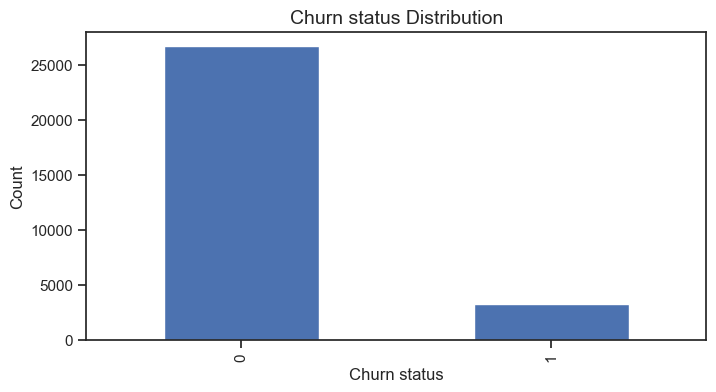

In [79]:
plt.figure(figsize=(8,4))
df['churn_flag'].value_counts().plot(kind = 'bar')
plt.ylabel('Count')
plt.xlabel('Churn status')
plt.title('Churn status Distribution',fontsize=14)

## mobile_number

In [82]:
df['mobile_number'].value_counts().sort_values(ascending = False).head()

mobile_number
7000842753    1
7002393996    1
7001524846    1
7002124215    1
7000887461    1
Name: count, dtype: int64

We can infer that the mobile_number is an unique column, means it's repeated multiple times. So we can safely ignore as it's not going to add any value for our analysis

## arpu (Average Revenue per user)

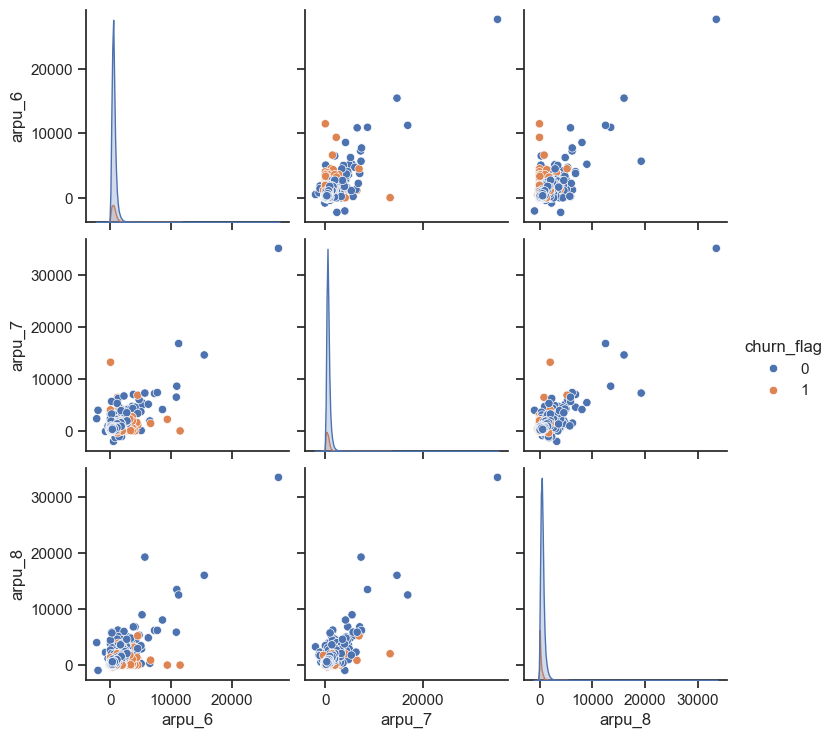

In [86]:
sns.pairplot(data=df[['arpu_6','arpu_7','arpu_8','churn_flag']],hue='churn_flag')

<Axes: xlabel='churn_flag', ylabel='arpu_6'>

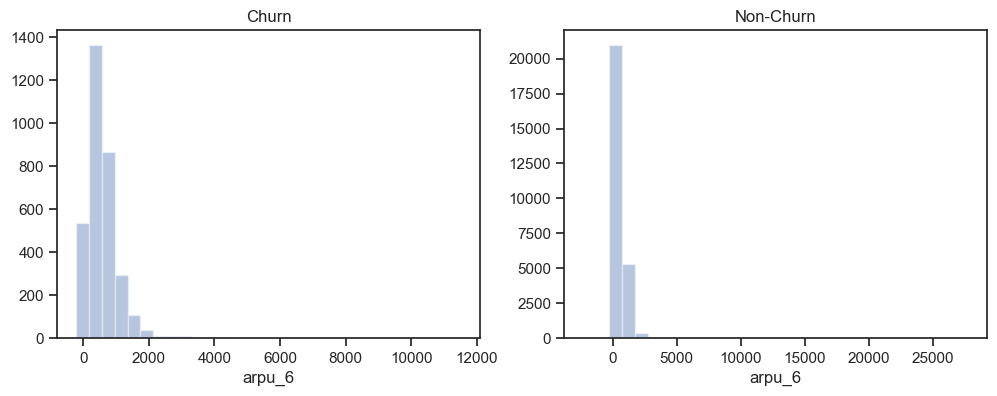

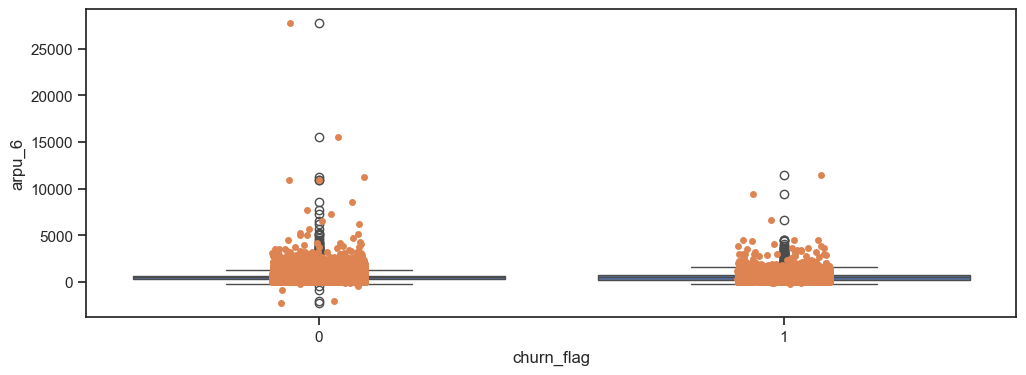

In [88]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12, 4))
ax = sns.distplot(df[df['churn_flag']==1].arpu_6, bins = 30, ax = axes[0], kde = False)
ax.set_title('Churn')
ax = sns.distplot(df[df['churn_flag']==0].arpu_6, bins = 30, ax = axes[1], kde = False)
ax.set_title('Non-Churn')

fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(12, 4))
sns.boxplot(x='churn_flag', y='arpu_6', data=df)
sns.stripplot(x='churn_flag', y='arpu_6', data=df, jitter=True, edgecolor="gray")

## onnet_mou (On network/ within the same network usage)

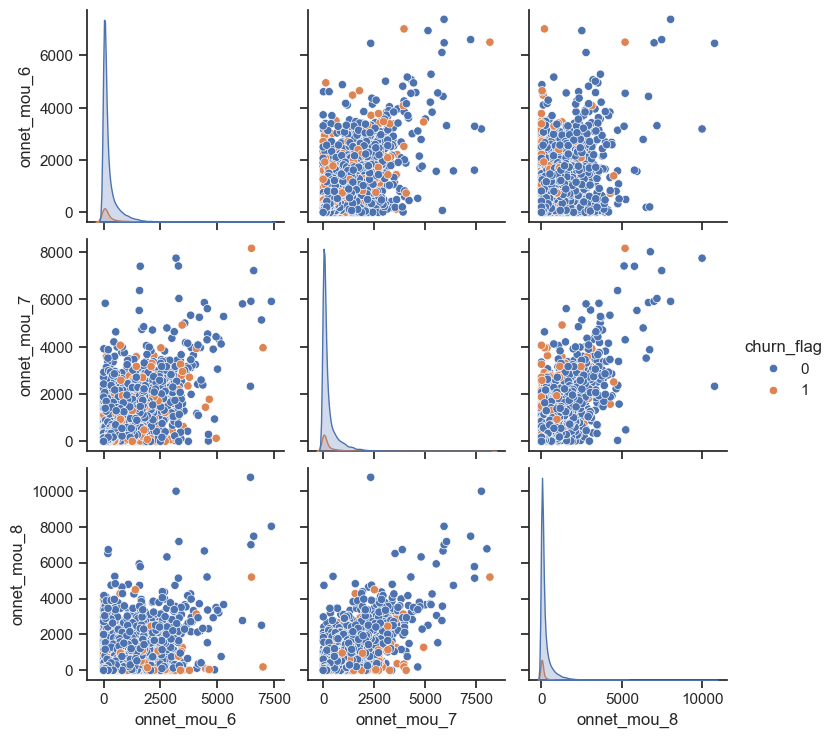

In [91]:
sns.pairplot(data=df[['onnet_mou_6','onnet_mou_7','onnet_mou_8','churn_flag']],hue='churn_flag')

<Axes: xlabel='churn_flag', ylabel='onnet_mou_6'>

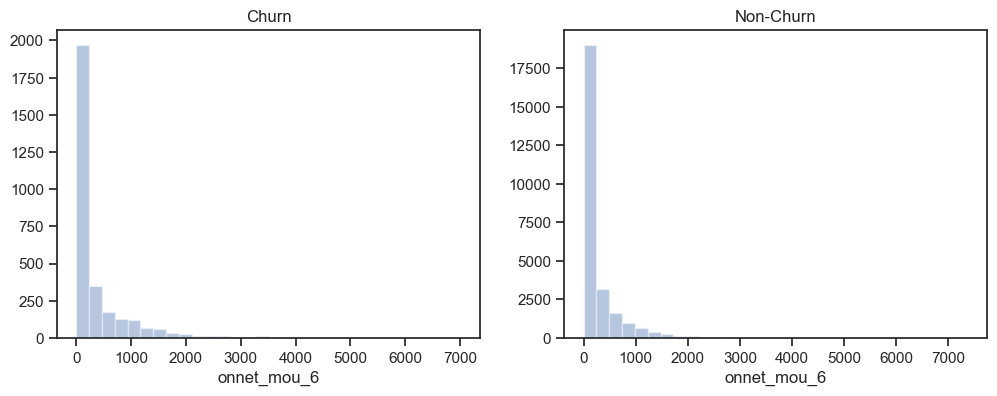

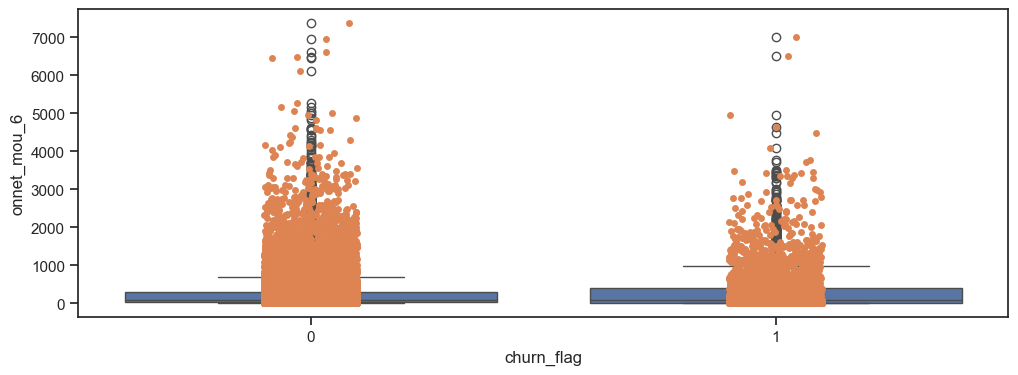

In [92]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12, 4))
ax = sns.distplot(df[df['churn_flag']==1].onnet_mou_6, bins = 30, ax = axes[0], kde = False)
ax.set_title('Churn')
ax = sns.distplot(df[df['churn_flag']==0].onnet_mou_6, bins = 30, ax = axes[1], kde = False)
ax.set_title('Non-Churn')

fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(12, 4))
sns.boxplot(x='churn_flag', y='onnet_mou_6', data=df)
sns.stripplot(x='churn_flag', y='onnet_mou_6', data=df, jitter=True, edgecolor="gray")

## Offnet_mou (Calls outside of the operator network)

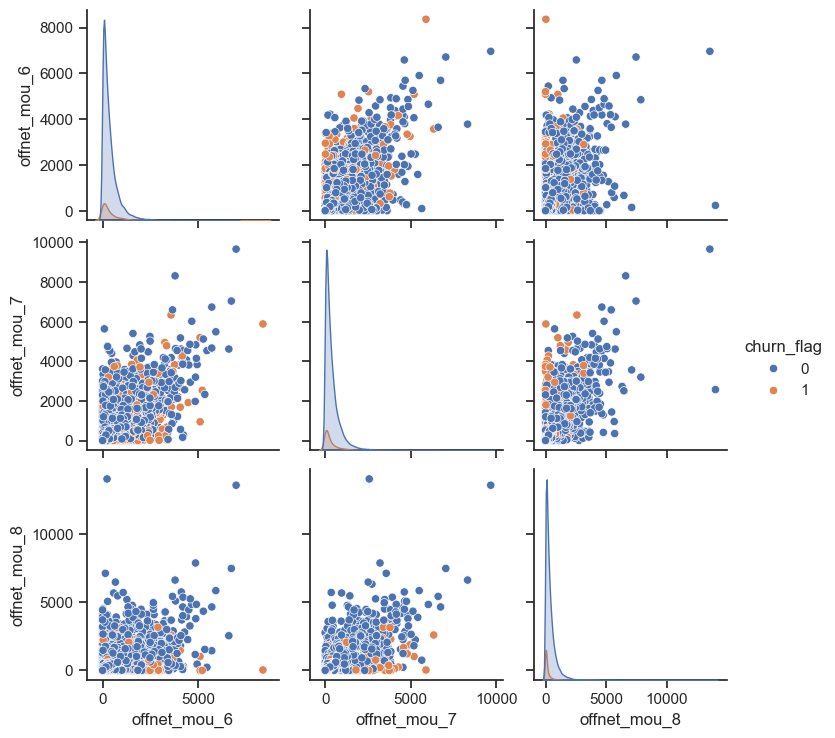

In [94]:
sns.pairplot(data=df[['offnet_mou_6','offnet_mou_7','offnet_mou_8','churn_flag']],hue='churn_flag')

<Axes: xlabel='churn_flag', ylabel='offnet_mou_6'>

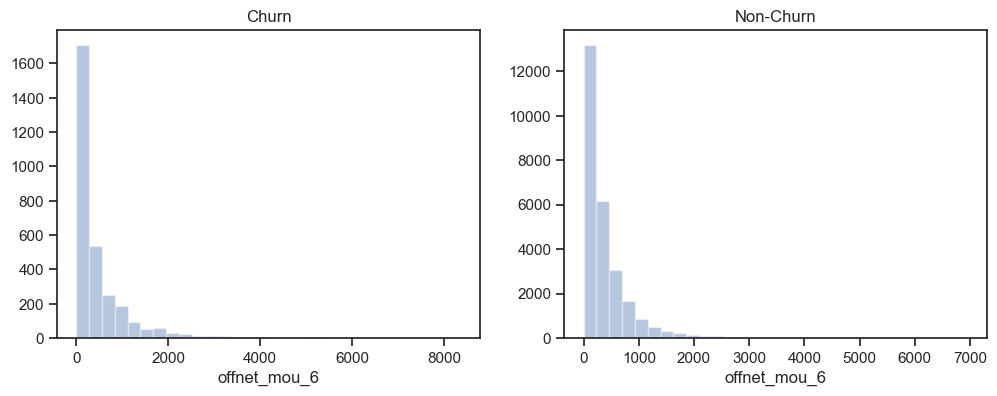

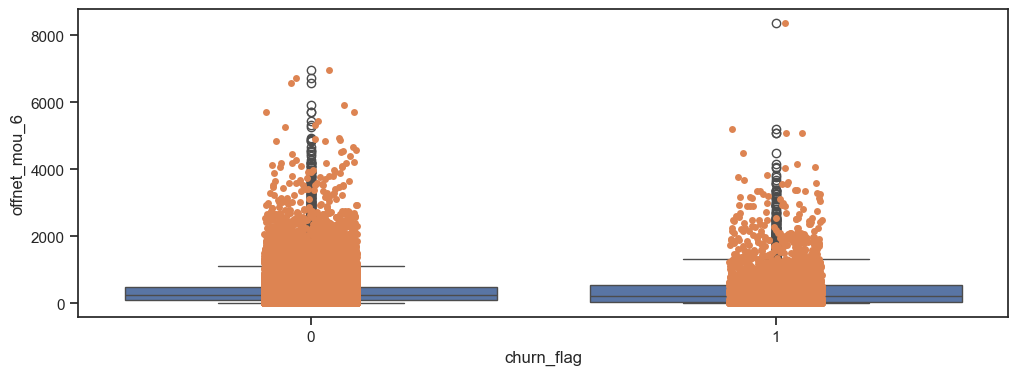

In [95]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12, 4))
ax = sns.distplot(df[df['churn_flag']==1].offnet_mou_6, bins = 30, ax = axes[0], kde = False)
ax.set_title('Churn')
ax = sns.distplot(df[df['churn_flag']==0].offnet_mou_6, bins = 30, ax = axes[1], kde = False)
ax.set_title('Non-Churn')

fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(12, 4))
sns.boxplot(x='churn_flag', y='offnet_mou_6', data=df)
sns.stripplot(x='churn_flag', y='offnet_mou_6', data=df, jitter=True, edgecolor="gray")


## roam_ic_mou (Customer in roaming zone)

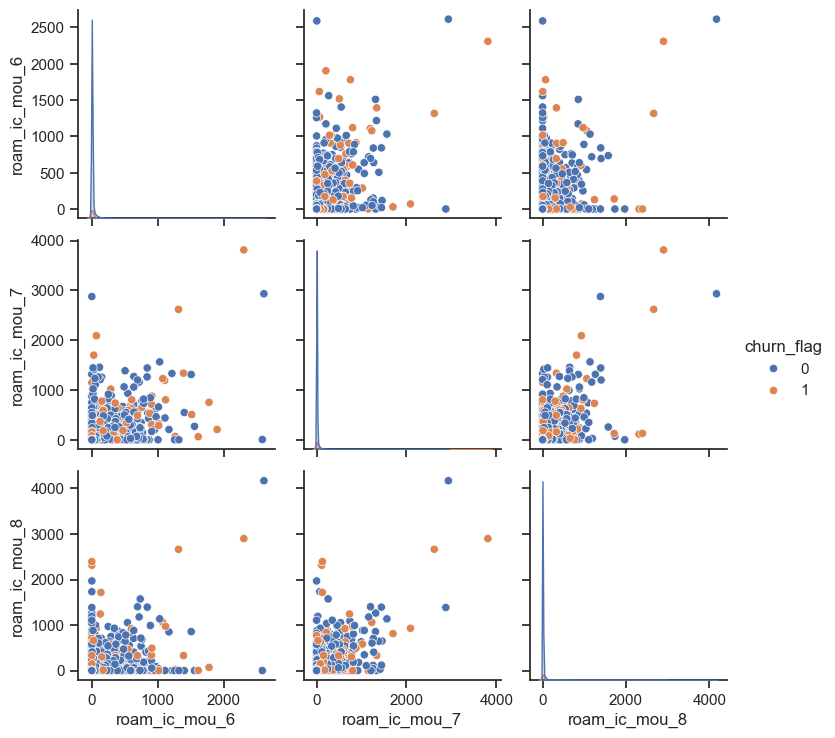

In [97]:
sns.pairplot(data=df[['roam_ic_mou_6','roam_ic_mou_7','roam_ic_mou_8','churn_flag']],hue='churn_flag')

<Axes: xlabel='churn_flag', ylabel='roam_ic_mou_6'>

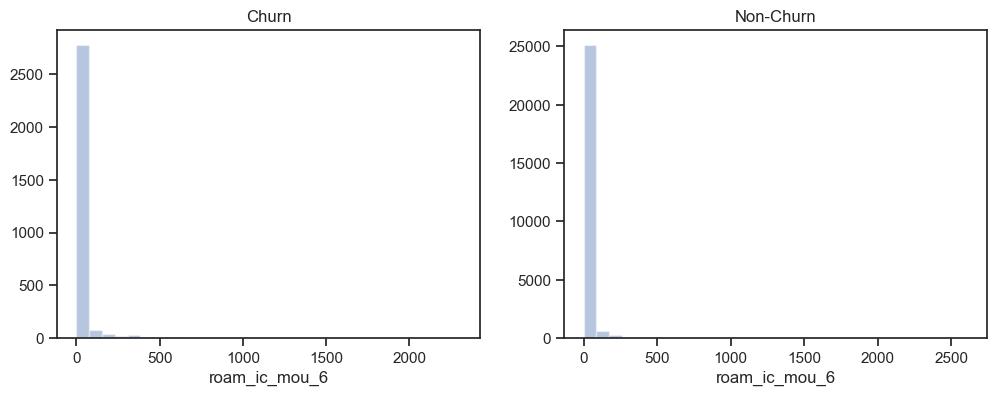

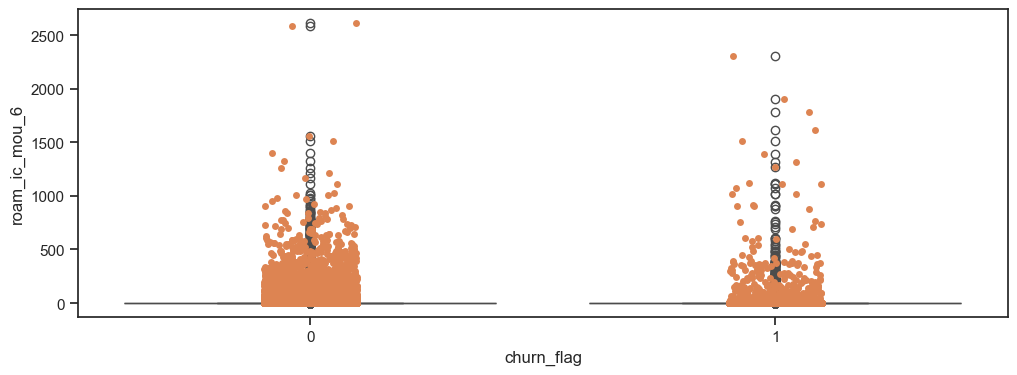

In [98]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12, 4))
ax = sns.distplot(df[df['churn_flag']==1].roam_ic_mou_6, bins = 30, ax = axes[0], kde = False)
ax.set_title('Churn')
ax = sns.distplot(df[df['churn_flag']==0].roam_ic_mou_6, bins = 30, ax = axes[1], kde = False)
ax.set_title('Non-Churn')

fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(12, 4))
sns.boxplot(x='churn_flag', y='roam_ic_mou_6', data=df)
sns.stripplot(x='churn_flag', y='roam_ic_mou_6', data=df, jitter=True, edgecolor="gray")

## loc_og_mou (within the circle outgoing calls)

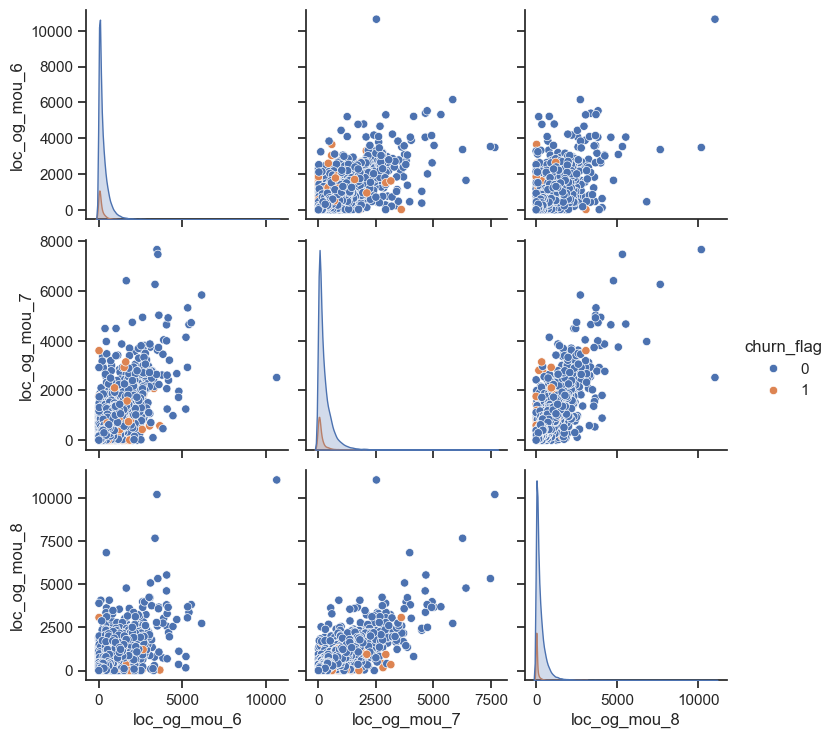

In [100]:
sns.pairplot(data=df[['loc_og_mou_6','loc_og_mou_7','loc_og_mou_8','churn_flag']],hue='churn_flag')

<Axes: xlabel='churn_flag', ylabel='loc_og_mou_6'>

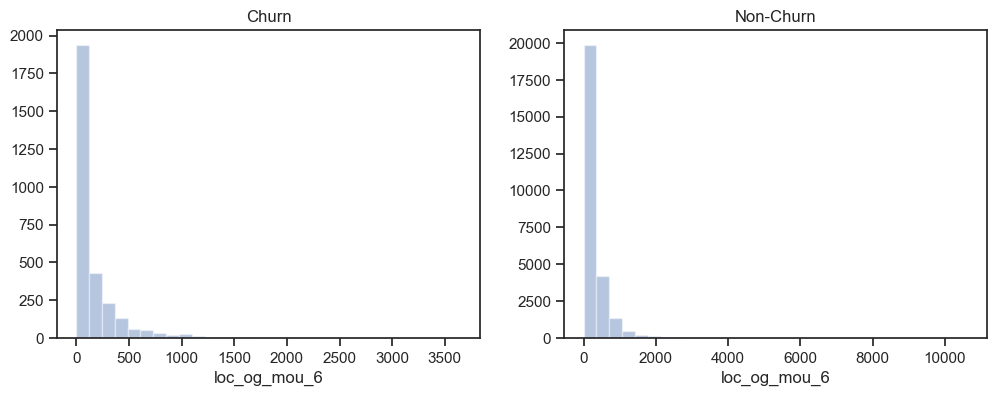

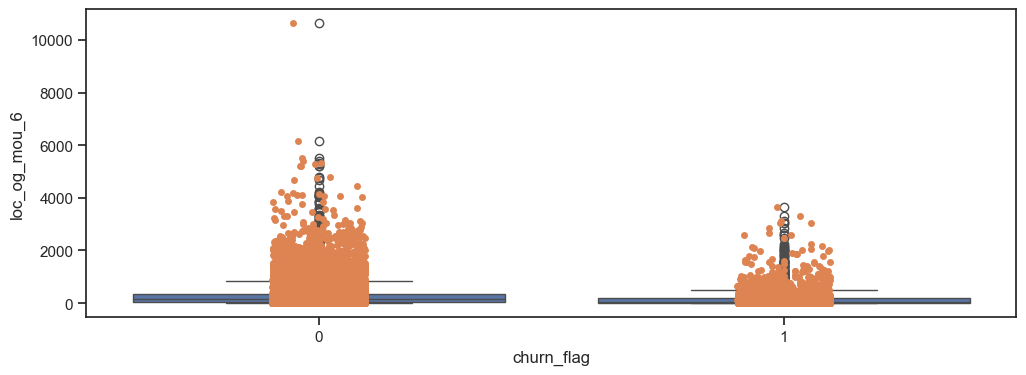

In [101]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12, 4))
ax = sns.distplot(df[df['churn_flag']==1].loc_og_mou_6, bins = 30, ax = axes[0], kde = False)
ax.set_title('Churn')
ax = sns.distplot(df[df['churn_flag']==0].loc_og_mou_6, bins = 30, ax = axes[1], kde = False)
ax.set_title('Non-Churn')

fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(12, 4))
sns.boxplot(x='churn_flag', y='loc_og_mou_6', data=df)
sns.stripplot(x='churn_flag', y='loc_og_mou_6', data=df, jitter=True, edgecolor="gray")

## std_og_mou (Outside calling circle/zone calls)

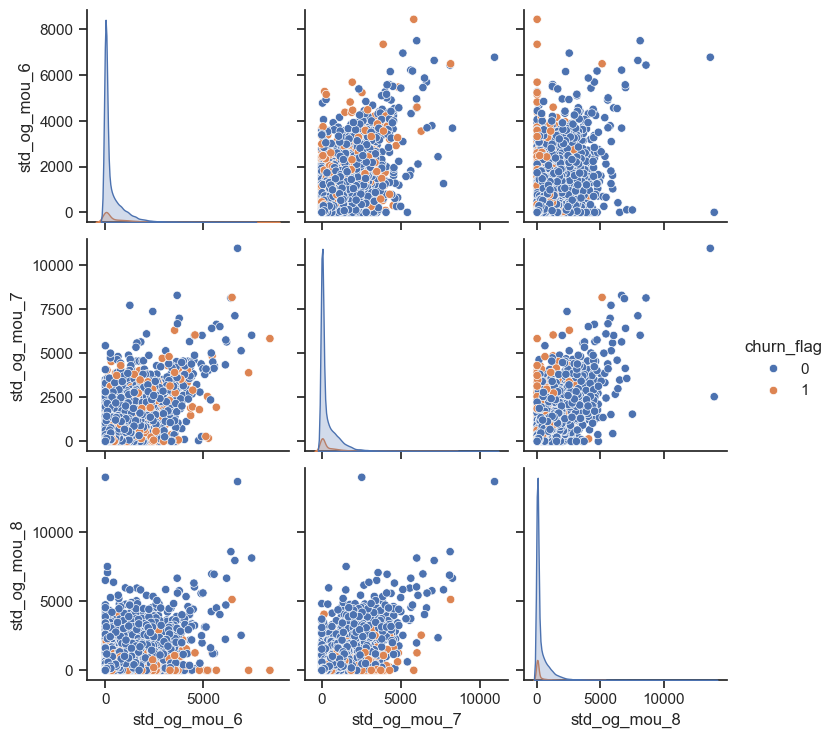

In [103]:
sns.pairplot(data=df[['std_og_mou_6','std_og_mou_7','std_og_mou_8','churn_flag']],hue='churn_flag')

<Axes: xlabel='churn_flag', ylabel='std_og_mou_6'>

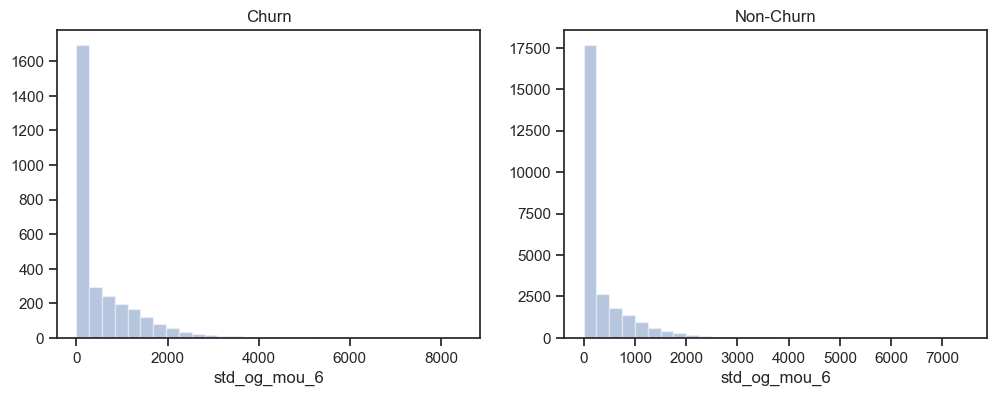

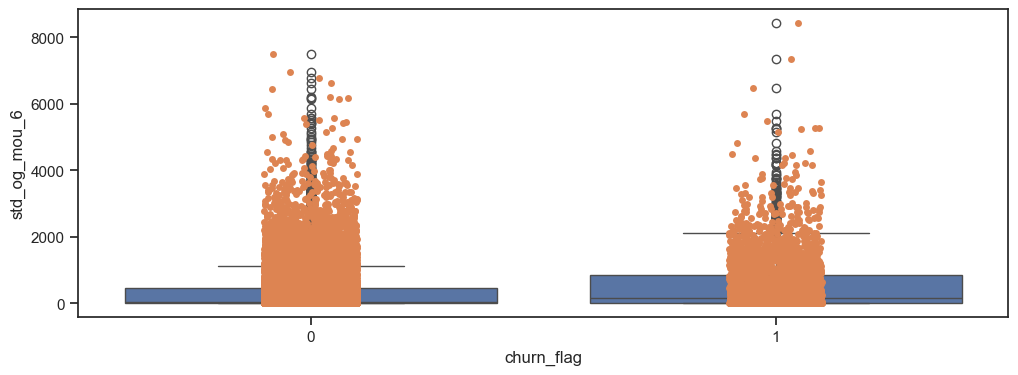

In [104]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12, 4))
ax = sns.distplot(df[df['churn_flag']==1].std_og_mou_6, bins = 30, ax = axes[0], kde = False)
ax.set_title('Churn')
ax = sns.distplot(df[df['churn_flag']==0].std_og_mou_6, bins = 30, ax = axes[1], kde = False)
ax.set_title('Non-Churn')

fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(12, 4))
sns.boxplot(x='churn_flag', y='std_og_mou_6', data=df)
sns.stripplot(x='churn_flag', y='std_og_mou_6', data=df, jitter=True, edgecolor="gray")

## isd_og (international calling)

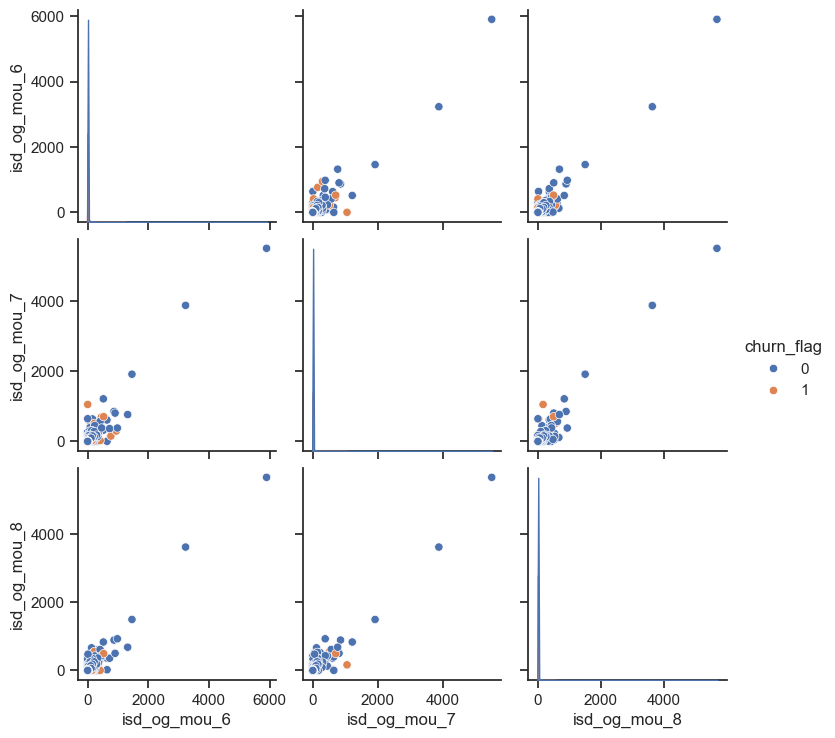

In [106]:
sns.pairplot(data=df[['isd_og_mou_6','isd_og_mou_7','isd_og_mou_8','churn_flag']],hue='churn_flag')

<Axes: xlabel='churn_flag', ylabel='isd_og_mou_6'>

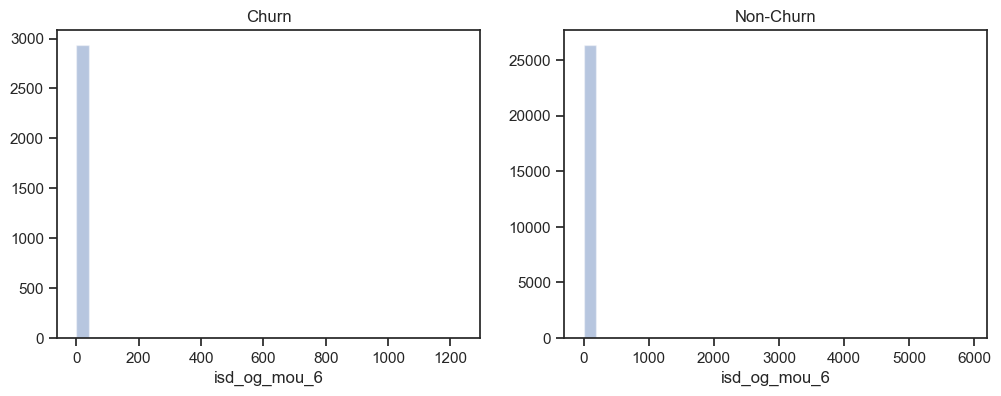

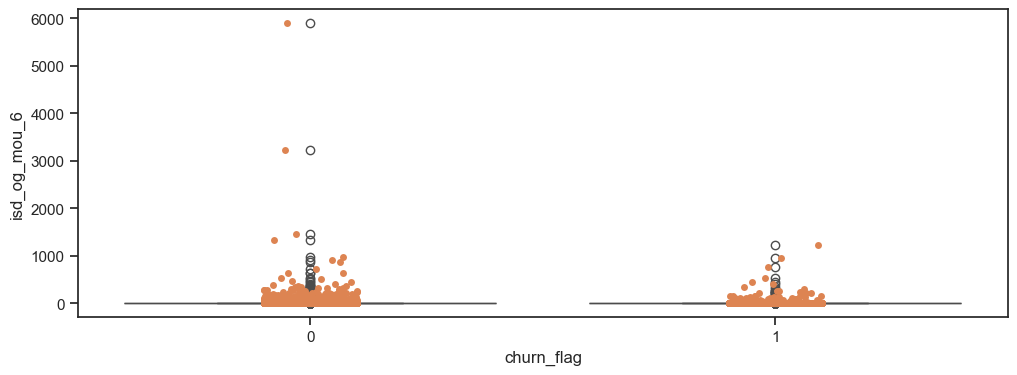

In [107]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12, 4))
ax = sns.distplot(df[df['churn_flag']==1].isd_og_mou_6, bins = 30, ax = axes[0], kde = False)
ax.set_title('Churn')
ax = sns.distplot(df[df['churn_flag']==0].isd_og_mou_6, bins = 30, ax = axes[1], kde = False)
ax.set_title('Non-Churn')

fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(12, 4))
sns.boxplot(x='churn_flag', y='isd_og_mou_6', data=df)
sns.stripplot(x='churn_flag', y='isd_og_mou_6', data=df, jitter=True, edgecolor="gray")

## total_og_ (All outgoing calls by the customer)

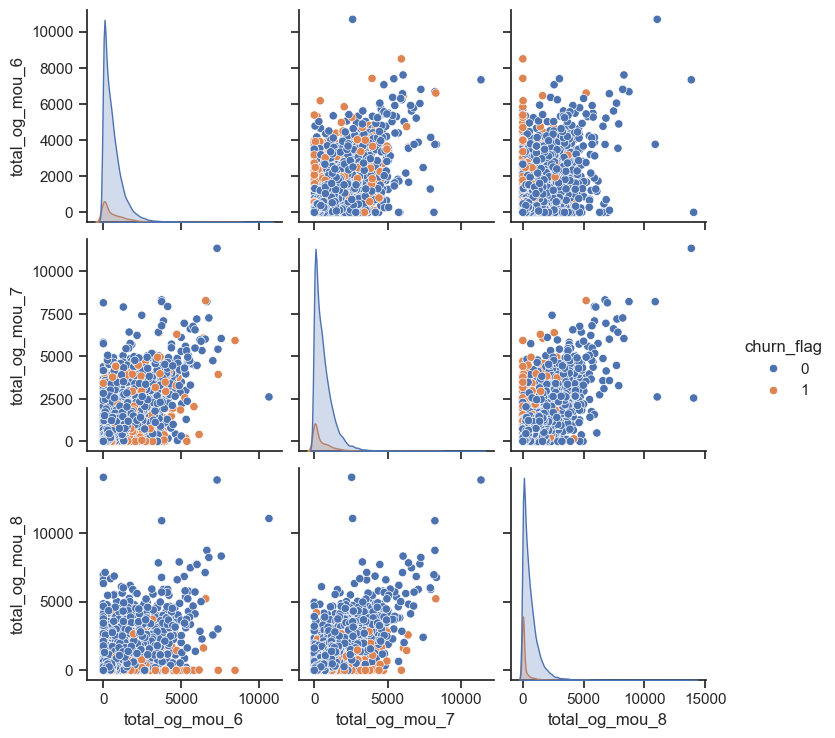

In [109]:
sns.pairplot(data=df[['total_og_mou_6','total_og_mou_7','total_og_mou_8','churn_flag']],hue='churn_flag')

<Axes: xlabel='churn_flag', ylabel='total_og_mou_6'>

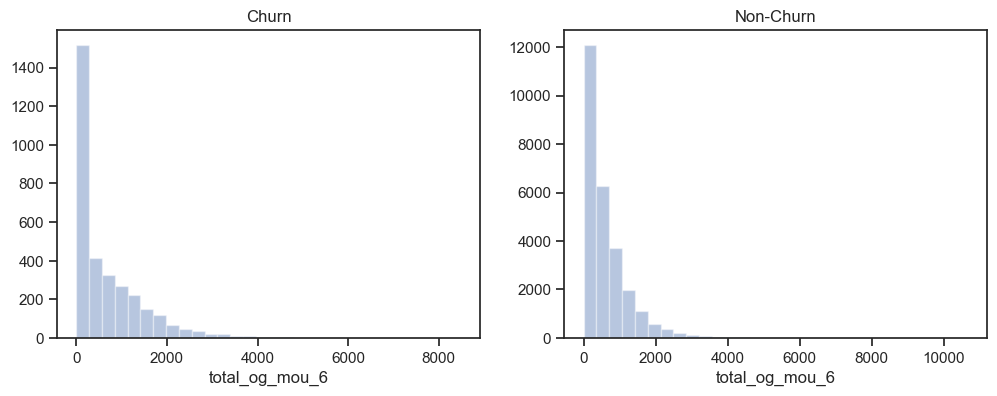

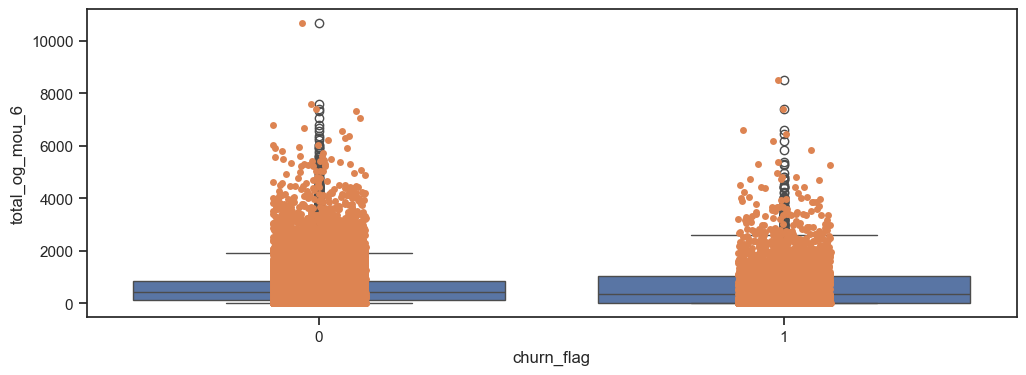

In [110]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12, 4))
ax = sns.distplot(df[df['churn_flag']==1].total_og_mou_6, bins = 30, ax = axes[0], kde = False)
ax.set_title('Churn')
ax = sns.distplot(df[df['churn_flag']==0].total_og_mou_6, bins = 30, ax = axes[1], kde = False)
ax.set_title('Non-Churn')

fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(12, 4))
sns.boxplot(x='churn_flag', y='total_og_mou_6', data=df)
sns.stripplot(x='churn_flag', y='total_og_mou_6', data=df, jitter=True, edgecolor="gray")

## loc_ic_ (incoming local calls)

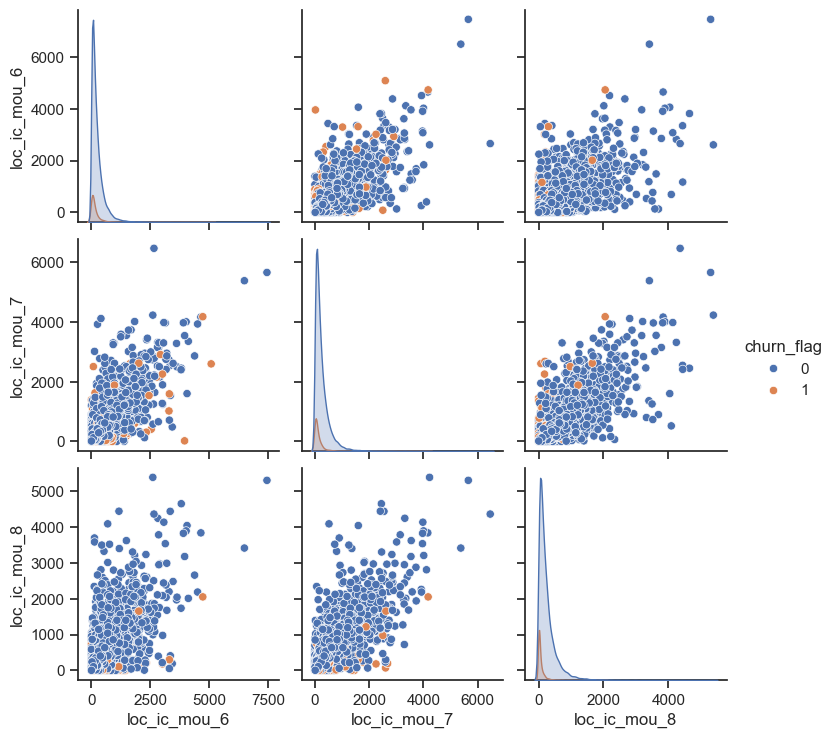

In [112]:
sns.pairplot(data=df[['loc_ic_mou_6','loc_ic_mou_7','loc_ic_mou_8','churn_flag']],hue='churn_flag')

<Axes: xlabel='churn_flag', ylabel='loc_ic_mou_6'>

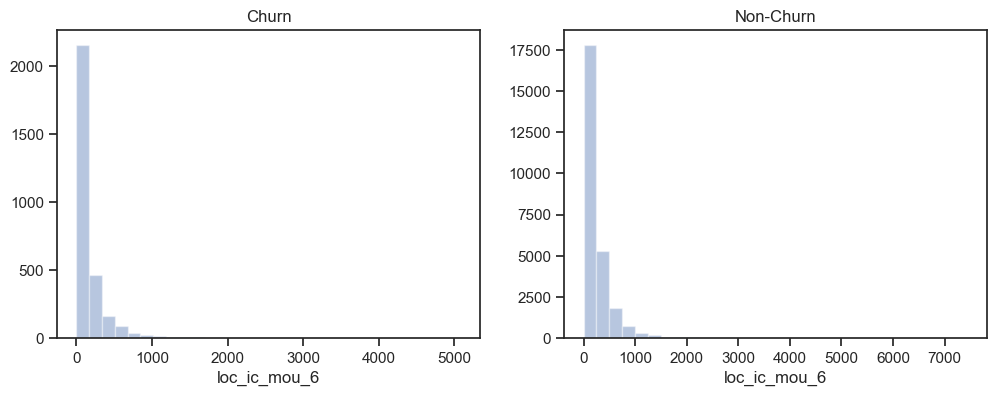

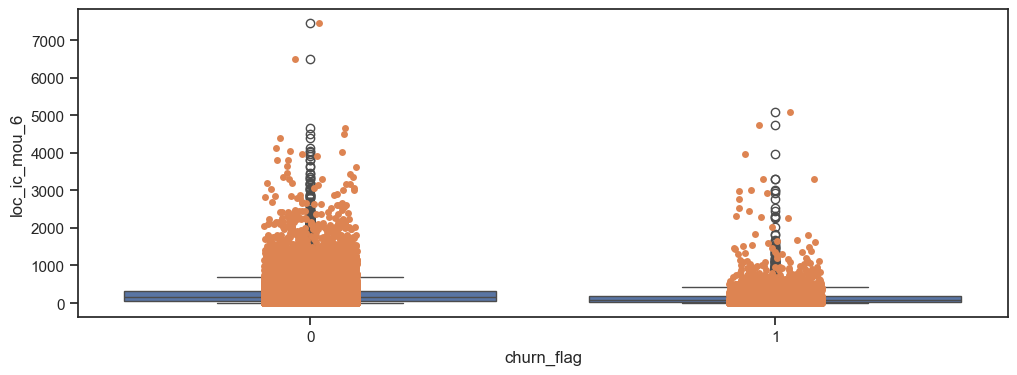

In [113]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12, 4))
ax = sns.distplot(df[df['churn_flag']==1].loc_ic_mou_6, bins = 30, ax = axes[0], kde = False)
ax.set_title('Churn')
ax = sns.distplot(df[df['churn_flag']==0].loc_ic_mou_6, bins = 30, ax = axes[1], kde = False)
ax.set_title('Non-Churn')

fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(12, 4))
sns.boxplot(x='churn_flag', y='loc_ic_mou_6', data=df)
sns.stripplot(x='churn_flag', y='loc_ic_mou_6', data=df, jitter=True, edgecolor="gray")

## std_ic_ (Outside circle incoming calls)

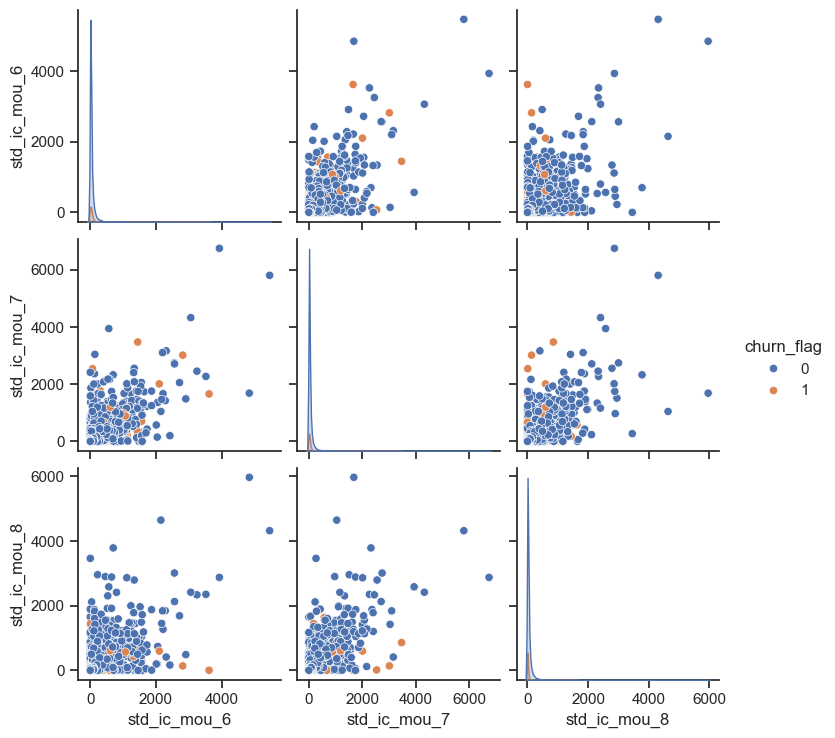

In [115]:
sns.pairplot(data=df[['std_ic_mou_6','std_ic_mou_7','std_ic_mou_8','churn_flag']],hue='churn_flag')

<Axes: xlabel='churn_flag', ylabel='std_ic_mou_6'>

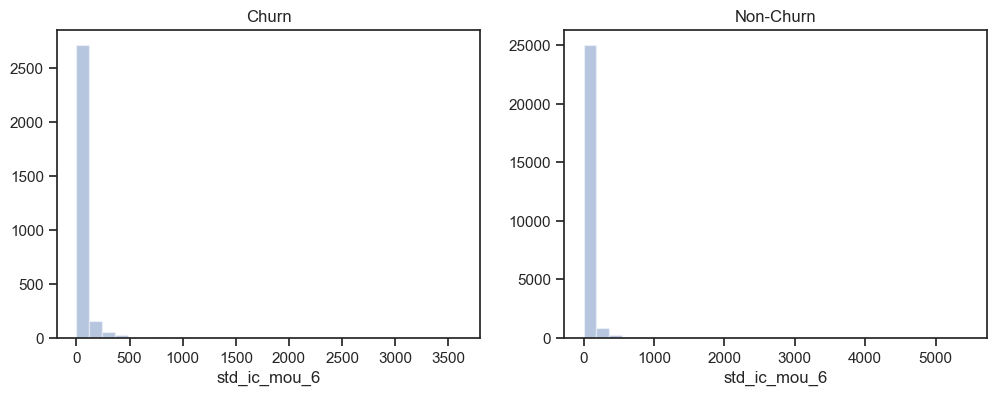

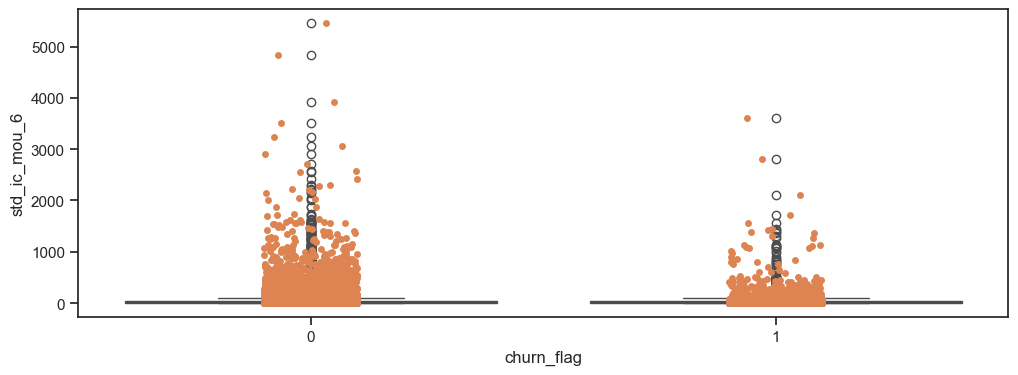

In [116]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12, 4))
ax = sns.distplot(df[df['churn_flag']==1].std_ic_mou_6, bins = 30, ax = axes[0], kde = False)
ax.set_title('Churn')
ax = sns.distplot(df[df['churn_flag']==0].std_ic_mou_6, bins = 30, ax = axes[1], kde = False)
ax.set_title('Non-Churn')

fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(12, 4))
sns.boxplot(x='churn_flag', y='std_ic_mou_6', data=df)
sns.stripplot(x='churn_flag', y='std_ic_mou_6', data=df, jitter=True, edgecolor="gray")

## total_ic_ (All incoming calls received by a person)

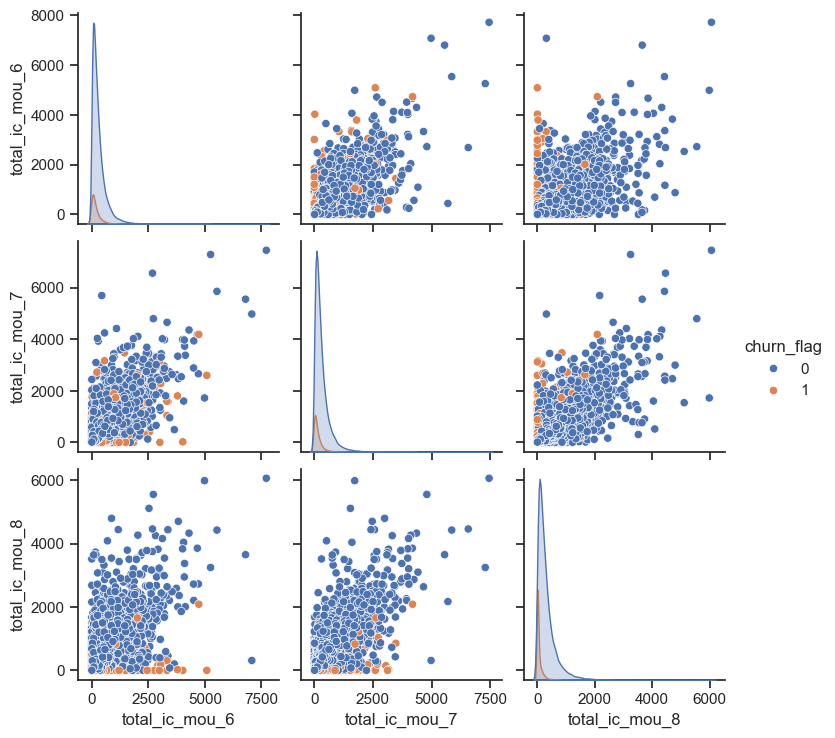

In [118]:
sns.pairplot(data=df[['total_ic_mou_6','total_ic_mou_7','total_ic_mou_8','churn_flag']],hue='churn_flag')

<Axes: xlabel='churn_flag', ylabel='total_ic_mou_6'>

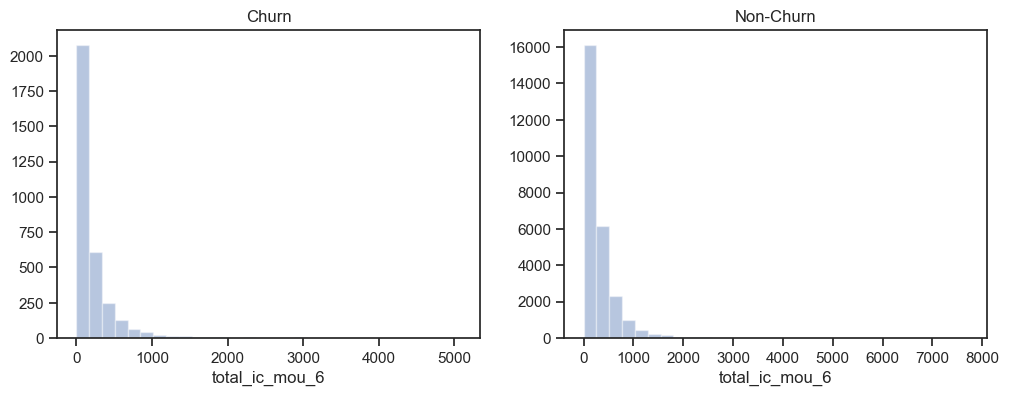

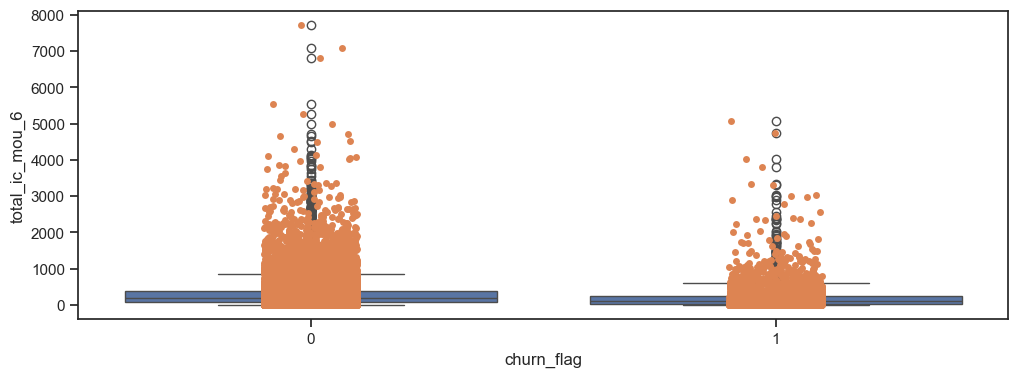

In [119]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12, 4))
ax = sns.distplot(df[df['churn_flag']==1].total_ic_mou_6, bins = 30, ax = axes[0], kde = False)
ax.set_title('Churn')
ax = sns.distplot(df[df['churn_flag']==0].total_ic_mou_6, bins = 30, ax = axes[1], kde = False)
ax.set_title('Non-Churn')

fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(12, 4))
sns.boxplot(x='churn_flag', y='total_ic_mou_6', data=df)
sns.stripplot(x='churn_flag', y='total_ic_mou_6', data=df, jitter=True, edgecolor="gray")

## total_rech_num_ 
#### (Number of times a subscriber recharged his mobile)

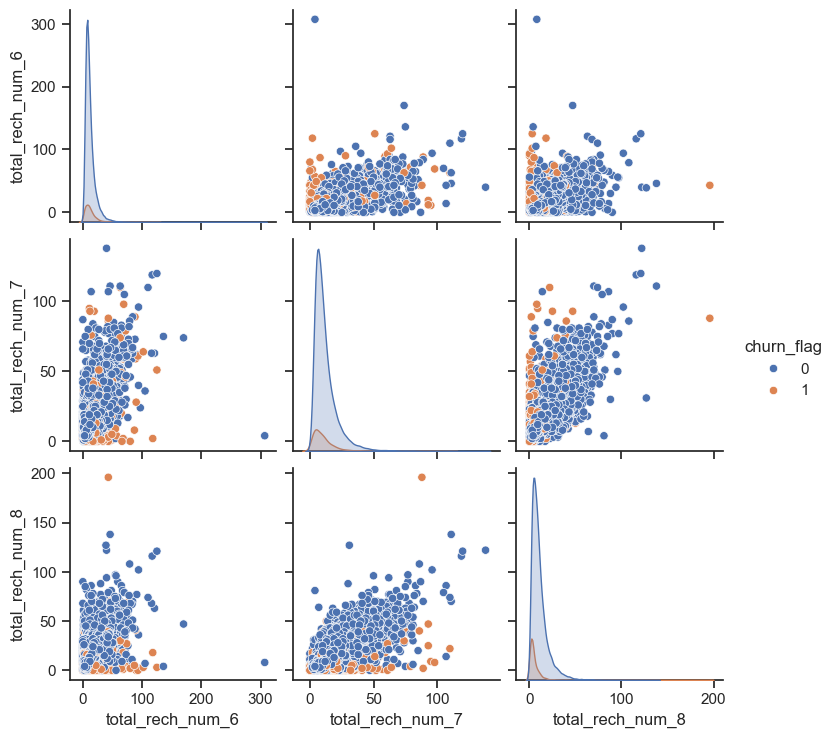

In [121]:
sns.pairplot(data=df[['total_rech_num_6','total_rech_num_7','total_rech_num_8','churn_flag']],hue='churn_flag')

<Axes: xlabel='churn_flag', ylabel='total_rech_num_6'>

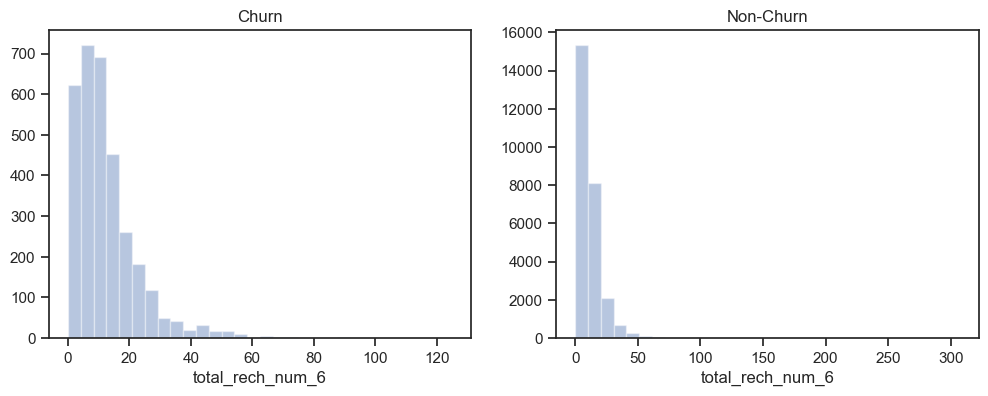

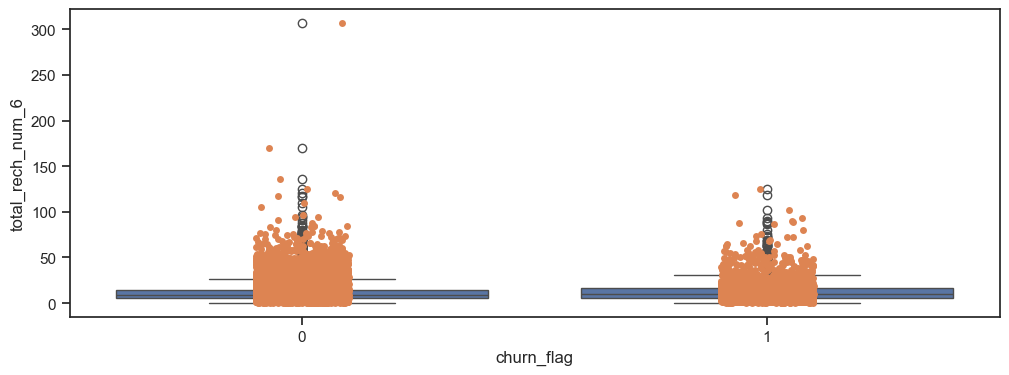

In [122]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12, 4))
ax = sns.distplot(df[df['churn_flag']==1].total_rech_num_6, bins = 30, ax = axes[0], kde = False)
ax.set_title('Churn')
ax = sns.distplot(df[df['churn_flag']==0].total_rech_num_6, bins = 30, ax = axes[1], kde = False)
ax.set_title('Non-Churn')

fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(12, 4))
sns.boxplot(x='churn_flag', y='total_rech_num_6', data=df)
sns.stripplot(x='churn_flag', y='total_rech_num_6', data=df, jitter=True, edgecolor="gray")

## total_rech_amt_
#### Total recharge amount in a particular month

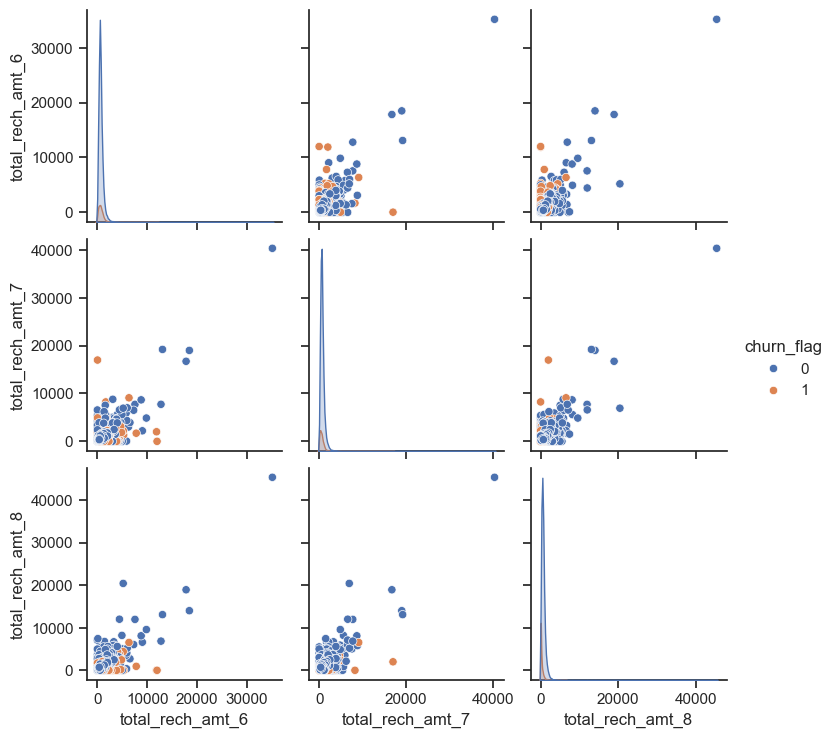

In [124]:
sns.pairplot(data=df[['total_rech_amt_6','total_rech_amt_7','total_rech_amt_8','churn_flag']],hue='churn_flag')

<Axes: xlabel='churn_flag', ylabel='total_rech_amt_6'>

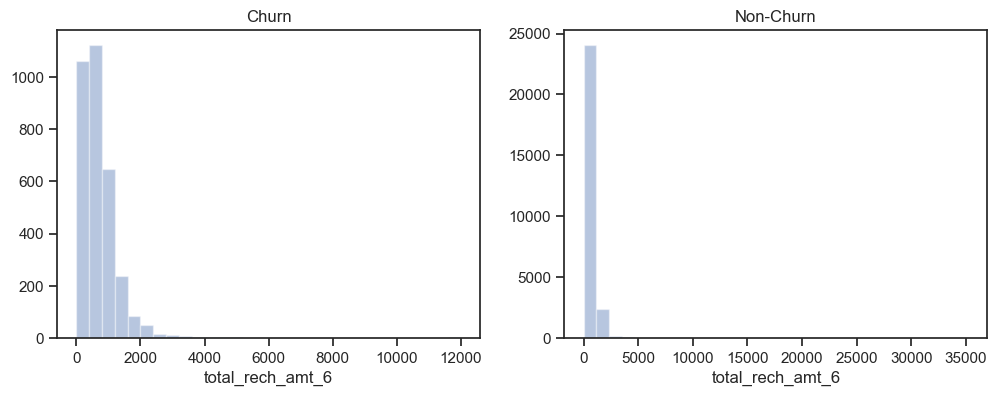

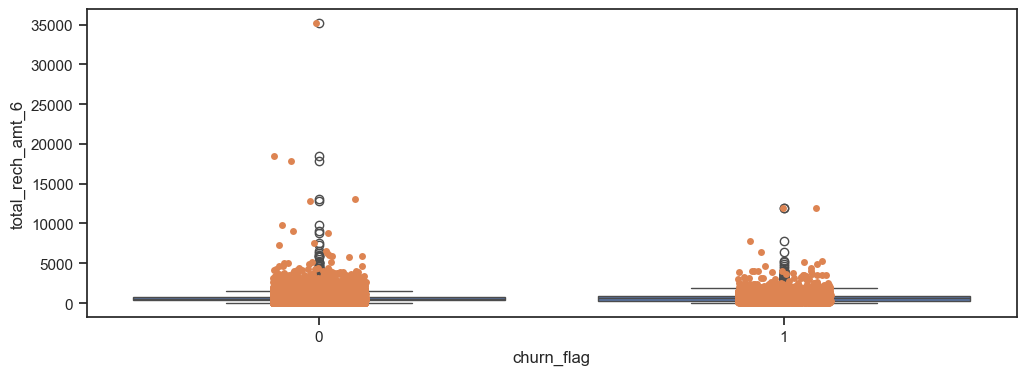

In [125]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12, 4))
ax = sns.distplot(df[df['churn_flag']==1].total_rech_amt_6, bins = 30, ax = axes[0], kde = False)
ax.set_title('Churn')
ax = sns.distplot(df[df['churn_flag']==0].total_rech_amt_6, bins = 30, ax = axes[1], kde = False)
ax.set_title('Non-Churn')

fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(12, 4))
sns.boxplot(x='churn_flag', y='total_rech_amt_6', data=df)
sns.stripplot(x='churn_flag', y='total_rech_amt_6', data=df, jitter=True, edgecolor="gray")

## total_rech_data_
#### Total number of times mobile data has been recharged

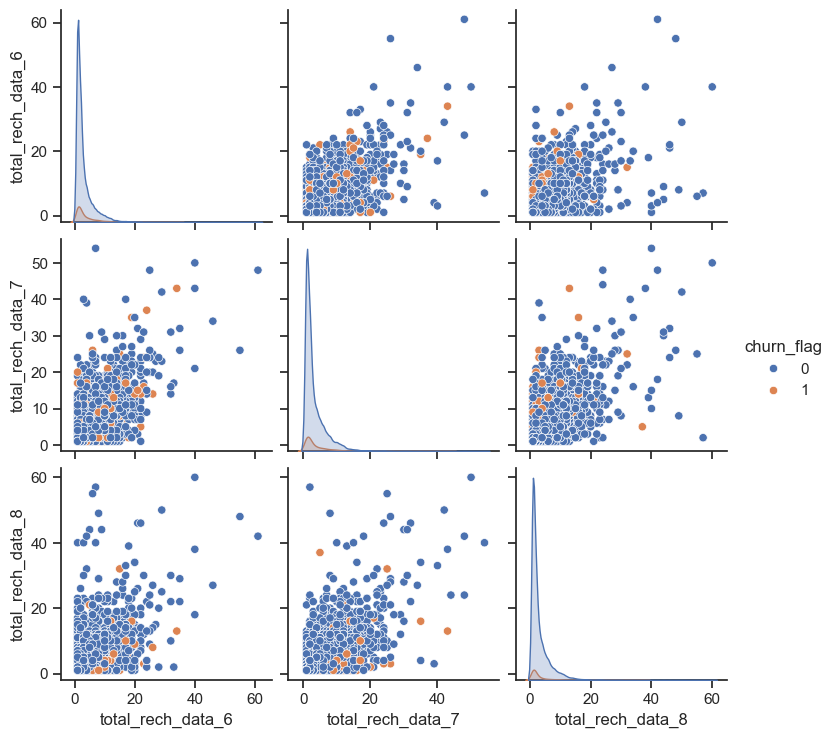

In [127]:
sns.pairplot(data=df[['total_rech_data_6','total_rech_data_7','total_rech_data_8','churn_flag']],hue='churn_flag')

<Axes: xlabel='churn_flag', ylabel='total_rech_data_6'>

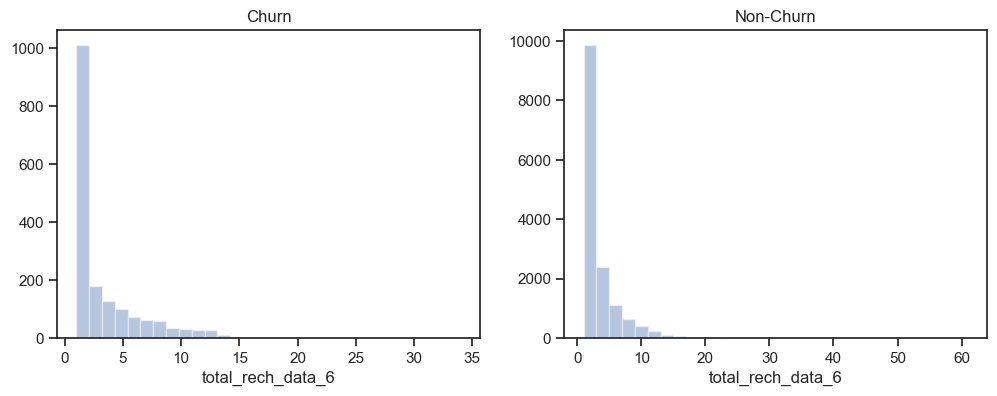

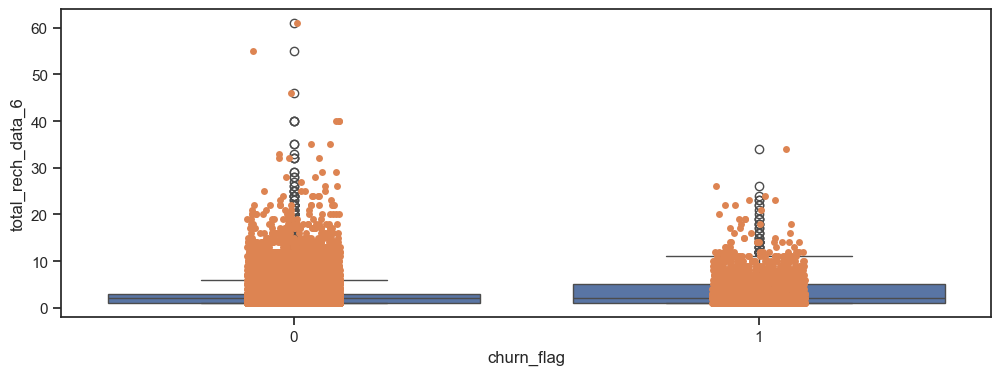

In [128]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12, 4))
ax = sns.distplot(df[df['churn_flag']==1].total_rech_data_6, bins = 30, ax = axes[0], kde = False)
ax.set_title('Churn')
ax = sns.distplot(df[df['churn_flag']==0].total_rech_data_6, bins = 30, ax = axes[1], kde = False)
ax.set_title('Non-Churn')

fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(12, 4))
sns.boxplot(x='churn_flag', y='total_rech_data_6', data=df)
sns.stripplot(x='churn_flag', y='total_rech_data_6', data=df, jitter=True, edgecolor="gray")

## vol_2g_mb_
#### Internet usage in MB

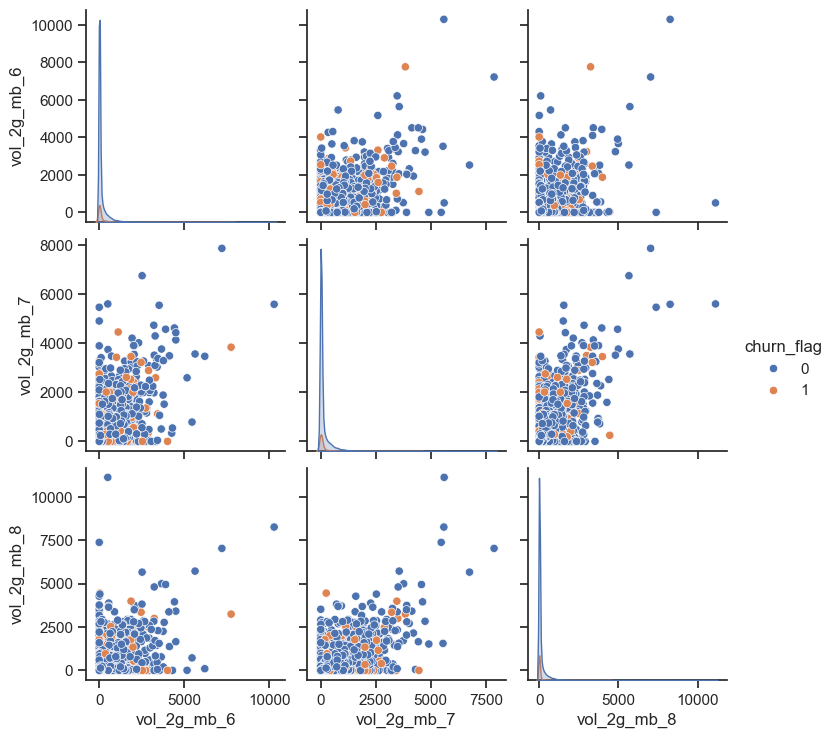

In [130]:
sns.pairplot(data=df[['vol_2g_mb_6','vol_2g_mb_7','vol_2g_mb_8','churn_flag']],hue='churn_flag')

<Axes: xlabel='churn_flag', ylabel='vol_2g_mb_6'>

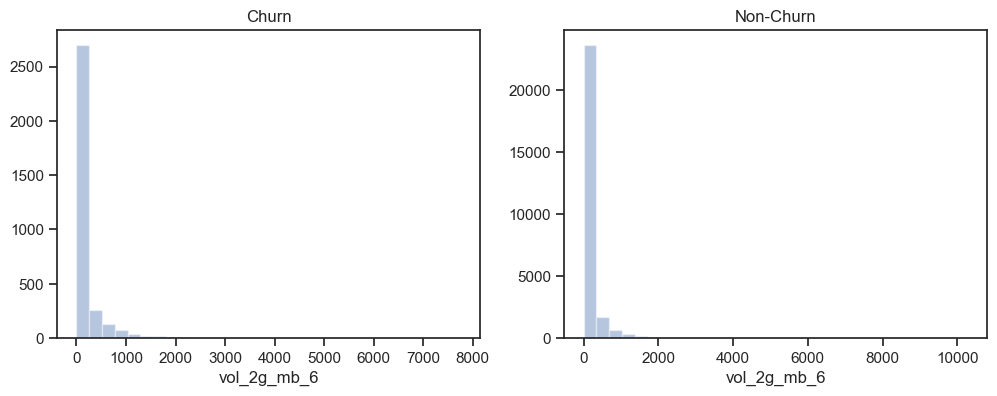

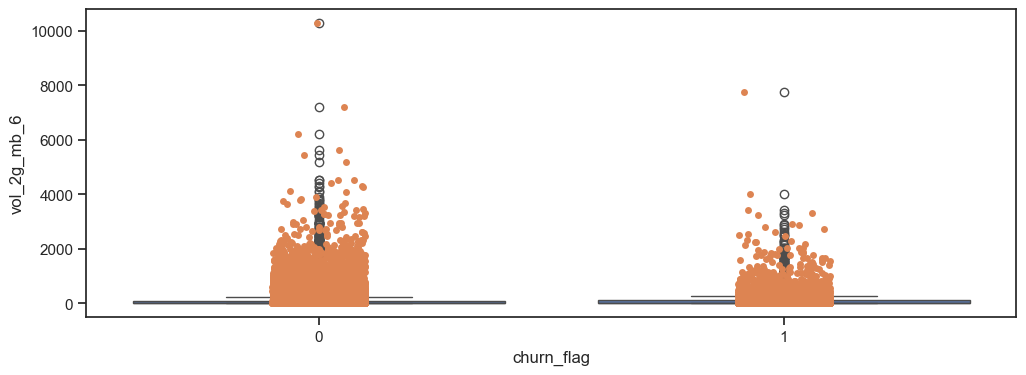

In [131]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12, 4))
ax = sns.distplot(df[df['churn_flag']==1].vol_2g_mb_6, bins = 30, ax = axes[0], kde = False)
ax.set_title('Churn')
ax = sns.distplot(df[df['churn_flag']==0].vol_2g_mb_6, bins = 30, ax = axes[1], kde = False)
ax.set_title('Non-Churn')

fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(12, 4))
sns.boxplot(x='churn_flag', y='vol_2g_mb_6', data=df)
sns.stripplot(x='churn_flag', y='vol_2g_mb_6', data=df, jitter=True, edgecolor="gray")

## vol_3g_mb_
#### Internet usage in MB

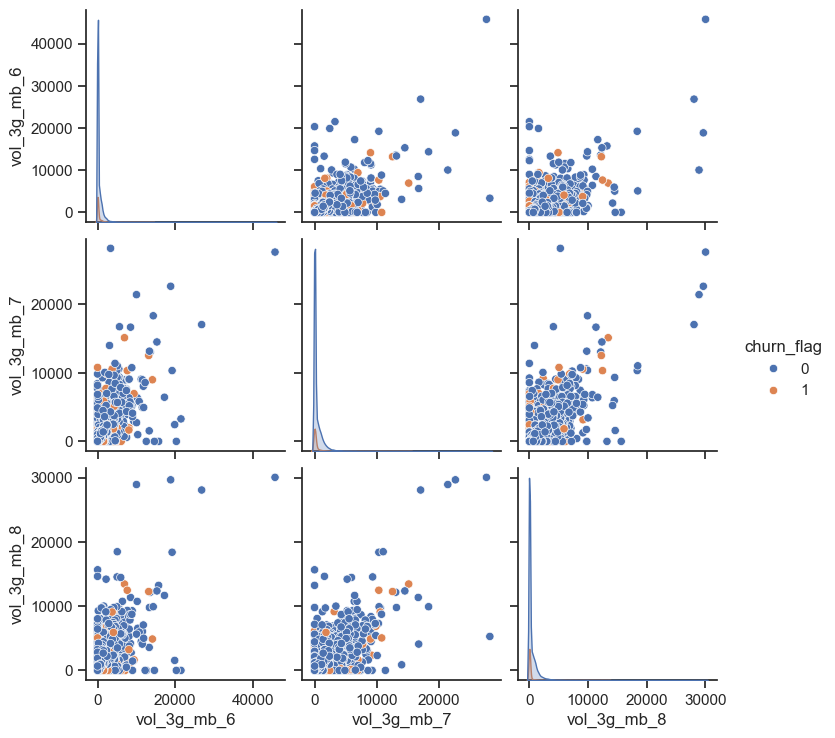

In [133]:
sns.pairplot(data=df[['vol_3g_mb_6','vol_3g_mb_7','vol_3g_mb_8','churn_flag']],hue='churn_flag')

<Axes: xlabel='churn_flag', ylabel='vol_3g_mb_6'>

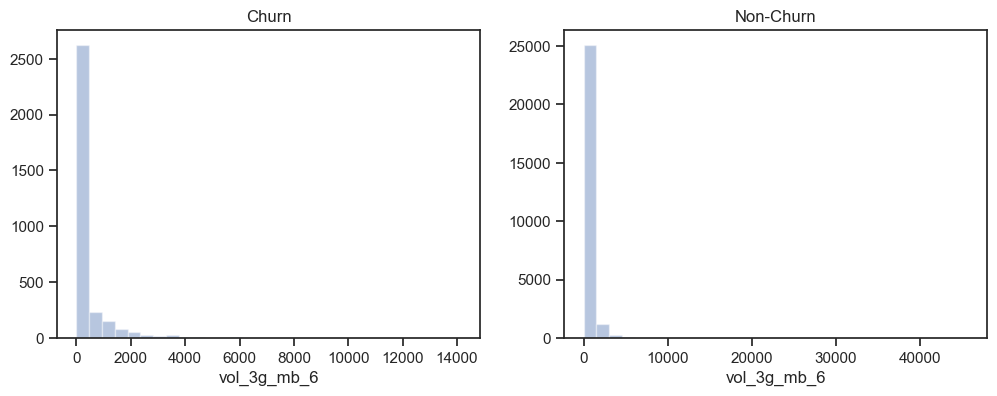

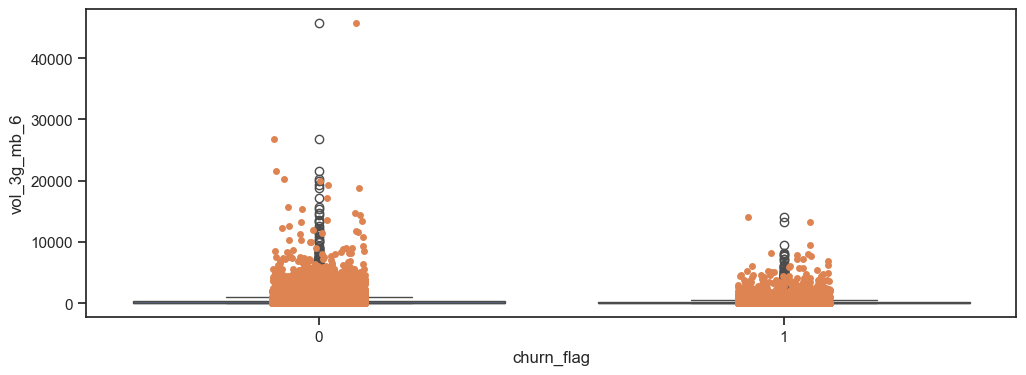

In [134]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12, 4))
ax = sns.distplot(df[df['churn_flag']==1].vol_3g_mb_6, bins = 30, ax = axes[0], kde = False)
ax.set_title('Churn')
ax = sns.distplot(df[df['churn_flag']==0].vol_3g_mb_6, bins = 30, ax = axes[1], kde = False)
ax.set_title('Non-Churn')

fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(12, 4))
sns.boxplot(x='churn_flag', y='vol_3g_mb_6', data=df)
sns.stripplot(x='churn_flag', y='vol_3g_mb_6', data=df, jitter=True, edgecolor="gray")

## vbc_3g_
#### Volume based cost - paid as per usage

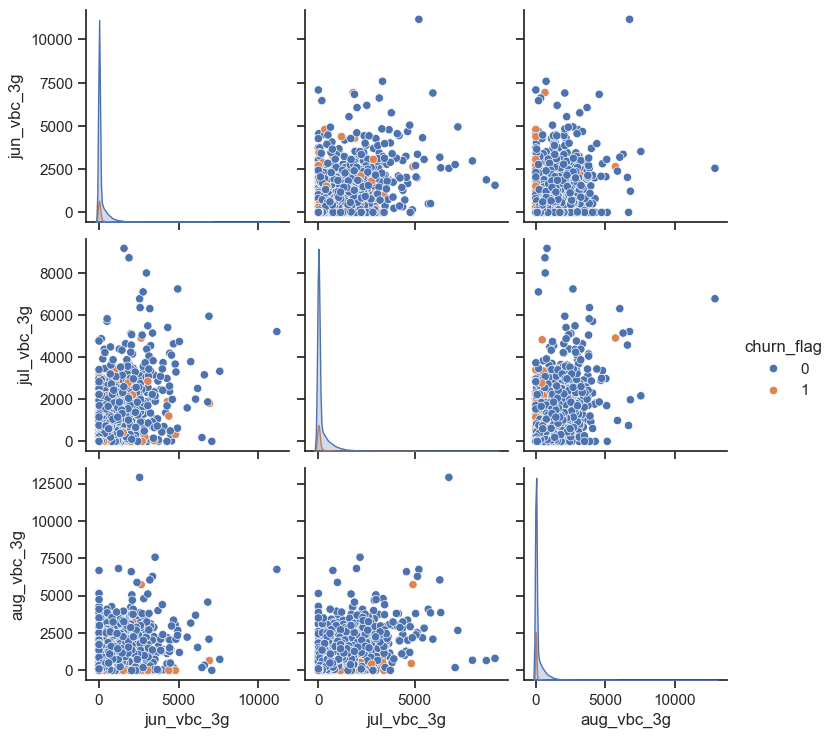

In [137]:
sns.pairplot(data=df[['jun_vbc_3g','jul_vbc_3g','aug_vbc_3g','churn_flag']],hue='churn_flag')

<Axes: xlabel='churn_flag', ylabel='jun_vbc_3g'>

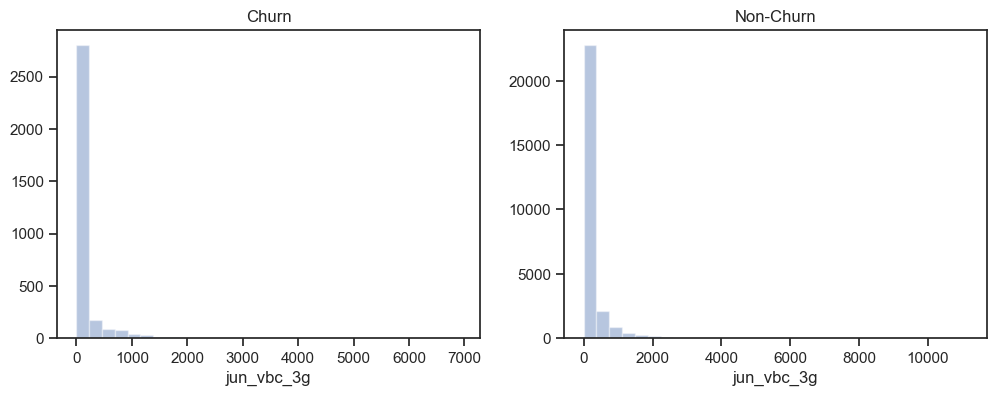

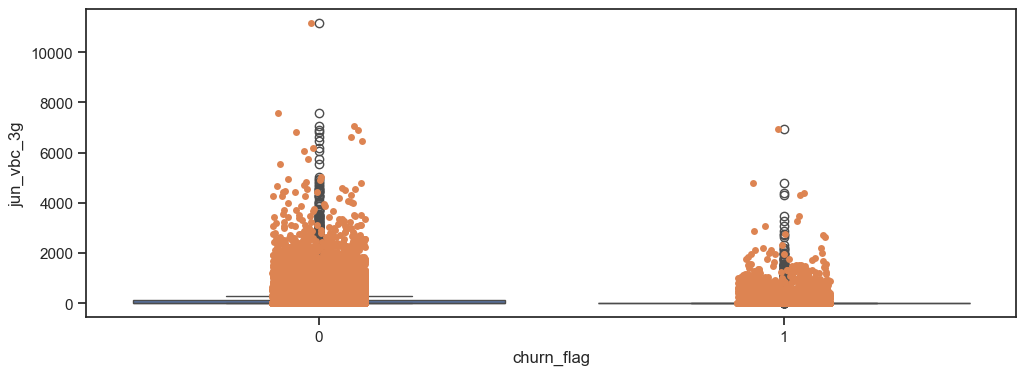

In [138]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12, 4))
ax = sns.distplot(df[df['churn_flag']==1].jun_vbc_3g, bins = 30, ax = axes[0], kde = False)
ax.set_title('Churn')
ax = sns.distplot(df[df['churn_flag']==0].jun_vbc_3g, bins = 30, ax = axes[1], kde = False)
ax.set_title('Non-Churn')

fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(12, 4))
sns.boxplot(x='churn_flag', y='jun_vbc_3g', data=df)
sns.stripplot(x='churn_flag', y='jun_vbc_3g', data=df, jitter=True, edgecolor="gray")

We can see few observations across the features, which have a different behavior. Can we consider them as outliers? Nearly 2% to 10% are tagged as outliers based on the feature. If we check the pattern between churn vs non-churn it's same across them and also it's same across the features as well. Therefore we can't exclude them from the model point of view.

## Derived features

Let's first start formating date features

In [172]:
df['date_of_last_rech_6'] = pd.to_datetime(df['date_of_last_rech_6'])
df['date_of_last_rech_7'] = pd.to_datetime(df['date_of_last_rech_7'])
df['date_of_last_rech_8'] = pd.to_datetime(df['date_of_last_rech_8'])

df['date_of_last_rech_data_6'] = pd.to_datetime(df['date_of_last_rech_data_6'])
df['date_of_last_rech_data_7'] = pd.to_datetime(df['date_of_last_rech_data_7'])
df['date_of_last_rech_data_8'] = pd.to_datetime(df['date_of_last_rech_data_8'])

df['mobile_number'] = df['mobile_number'].astype(str)

Create new features from the date columns <br>
This may help us identifying if a particular day in a month or a week causing any issue

In [175]:
# Now let's create new features from date column
df['date_of_last_rech_day_6'] = df['date_of_last_rech_6'].dt.day
df['date_of_last_rech_dayofwk_6'] = df['date_of_last_rech_6'].dt.dayofweek.astype(str)

df['date_of_last_rech_day_7'] = df['date_of_last_rech_7'].dt.day
df['date_of_last_rech_dayofwk_7'] = df['date_of_last_rech_7'].dt.dayofweek.astype(str)

df['date_of_last_rech_day_8'] = df['date_of_last_rech_8'].dt.day
df['date_of_last_rech_dayofwk_8'] = df['date_of_last_rech_8'].dt.dayofweek.astype(str)

df['date_of_last_rech_data_day_6'] = df['date_of_last_rech_data_6'].dt.day
df['date_of_last_rech_data_dayofwk_6'] = df['date_of_last_rech_data_6'].dt.dayofweek.astype(str)

df['date_of_last_rech_data_day_7'] = df['date_of_last_rech_data_7'].dt.day
df['date_of_last_rech_data_dayofwk_7'] = df['date_of_last_rech_data_7'].dt.dayofweek.astype(str)

df['date_of_last_rech_data_day_8'] = df['date_of_last_rech_data_8'].dt.day
df['date_of_last_rech_data_dayofwk_8'] = df['date_of_last_rech_data_8'].dt.dayofweek.astype(str)


In [179]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 29953 entries, 0 to 99997
Data columns (total 176 columns):
 #    Column                            Non-Null Count  Dtype         
---   ------                            --------------  -----         
 0    mobile_number                     29953 non-null  object        
 1    arpu_6                            29953 non-null  float64       
 2    arpu_7                            29953 non-null  float64       
 3    arpu_8                            29953 non-null  float64       
 4    onnet_mou_6                       29411 non-null  float64       
 5    onnet_mou_7                       29417 non-null  float64       
 6    onnet_mou_8                       28781 non-null  float64       
 7    offnet_mou_6                      29411 non-null  float64       
 8    offnet_mou_7                      29417 non-null  float64       
 9    offnet_mou_8                      28781 non-null  float64       
 10   roam_ic_mou_6                     294

In [181]:
pd.options.display.float_format = '{:.2f}'.format
df.describe()

arpu_6   arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  \
count 29953.00 29953.00 29953.00     29411.00     29417.00     28781.00   
mean    558.82   561.16   508.89       265.71       272.94       243.89   
min   -2258.71 -2014.05  -945.81         0.00         0.00         0.00   
25%     310.14   310.07   231.62        19.25        18.18        14.28   
50%     482.35   481.50   427.60        88.14        86.89        72.99   
75%     700.24   698.83   661.75       297.49       298.38       255.31   
max   27731.09 35145.83 33543.62      7376.71      8157.78     10752.56   
std     460.87   480.03   502.14       462.69       483.28       465.51   

       offnet_mou_6  offnet_mou_7  offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  \
count      29411.00      29417.00      28781.00       29411.00       29417.00   
mean         380.69        385.12        348.77          16.42          12.88   
min            0.00          0.00          0.00           0.00           0.00   
25%           78.55         76.18         58.76           0.00           0.00   
50%          229.63        227.13        197.69           0.00           0.00   
75%          494.75        500.48        455.44           0.00           0.00   
max         8362.36       9667.13      14007.34        2613.31        3813.29   
std          484.44        501.02        486.84          77.01          76.50   

       roam_ic_mou_8  roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  \
count       28781.00       29411.00       29417.00       28781.00   
mean           13.02          27.09          20.52          20.70   
min             0.00           0.00           0.00           0.00   
25%             0.00           0.00           0.00           0.00   
50%             0.00           0.00           0.00           0.00   
75%             0.00           0.00           0.00           0.00   
max          4169.81        3775.11        2812.04        5337.04   
std            75.63         117.28          96.97         106.83   

       loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  \
count          29411.00          29417.00          28781.00          29411.00   
mean              86.13             87.33             81.34            166.32   
min                0.00              0.00              0.00              0.00   
25%                5.03              5.29              3.84             21.13   
50%               25.59             25.79             23.26             80.34   
75%               79.87             80.44             76.11            212.49   
max             6431.33           7400.66          10752.56           4729.74   
std              230.77            242.60            231.57            251.52   

       loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  \
count          29417.00          28781.00          29411.00          29417.00   
mean             166.06            157.99              6.47              6.54   
min                0.00              0.00              0.00              0.00   
25%               22.94             17.58              0.00              0.00   
50%               81.74             74.66              0.11              0.21   
75%              211.81            205.88              4.38              4.54   
max             4557.14           4961.33           1466.03           1196.43   
std              242.86            236.40             22.33             22.14   

       loc_og_t2f_mou_8  loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  \
count          28781.00          29411.00          29417.00          28781.00   
mean               6.13              1.61              1.92              1.77   
min                0.00              0.00              0.00              0.00   
25%                0.00              0.00              0.00              0.00   
50%                0.00              0.00              0.00              0.00   
75%                4.26           

Let's check the correlation between features

In [184]:
joincorr= df.corr()
df_corr = joincorr.stack().reset_index().sort_values(by = 0, ascending = False)
df_corr[((df_corr[0] < 1) & (df_corr[0] >= 0.4)) | ((df_corr[0] <= -0.4) & (df_corr[0] > -1))]

level_0                           level_1  \
17942               date_of_last_rech_7           date_of_last_rech_day_7   
29317           date_of_last_rech_day_7               date_of_last_rech_7   
30732      date_of_last_rech_data_day_8          date_of_last_rech_data_8   
19182          date_of_last_rech_data_8      date_of_last_rech_data_day_8   
20736                   count_rech_2g_8                       sachet_2g_8   
25461                       sachet_2g_8                   count_rech_2g_8   
25284                       sachet_2g_7                   count_rech_2g_7   
20559                   count_rech_2g_7                       sachet_2g_7   
25107                       sachet_2g_6                   count_rech_2g_6   
20382                   count_rech_2g_6                       sachet_2g_6   
28495                        amt_data_7                 total_data_rech_7   
28145                 total_data_rech_7                        amt_data_7   
28318                        amt_data_6                 total_data_rech_6   
27968                 total_data_rech_6                        amt_data_6   
16899                  total_rech_amt_8                            arpu_8   
624                              arpu_8                  total_rech_amt_8   
7613                       isd_og_mou_6                      isd_og_mou_8   
7963                       isd_og_mou_8                      isd_og_mou_6   
7964                       isd_og_mou_8                      isd_og_mou_7   
7789                       isd_og_mou_7                      isd_og_mou_8   
16545                  total_rech_amt_6                            arpu_6   
270                              arpu_6                  total_rech_amt_6   
447                              arpu_7                  total_rech_amt_7   
16722                  total_rech_amt_7                            arpu_7   
7787                       isd_og_mou_7                      isd_og_mou_6   
7612                       isd_og_mou_6                      isd_og_mou_7   
23013                         arpu_3g_6                         arpu_2g_6   
23538                         arpu_2g_6                         arpu_3g_6   
23367                         arpu_3g_8                         arpu_2g_8   
23892                         arpu_2g_8                         arpu_3g_8   
23190                         arpu_3g_7                         arpu_2g_7   
23715                         arpu_2g_7                         arpu_3g_7   
13968                    total_ic_mou_6                      loc_ic_mou_6   
11343                      loc_ic_mou_6                    total_ic_mou_6   
19326                 total_rech_data_6                       sachet_2g_6   
25101                       sachet_2g_6                 total_rech_data_6   
11697                      loc_ic_mou_8                    total_ic_mou_8   
14322                    total_ic_mou_8                      loc_ic_mou_8   
25278                       sachet_2g_7                 total_rech_data_7   
19503                 total_rech_data_7                       sachet_2g_7   
20349                   count_rech_2g_6                 total_rech_data_6   
19299                 total_rech_data_6                   count_rech_2g_6   
20526                   count_rech_2g_7                 total_rech_data_7   
19476                 total_rech_data_7                   count_rech_2g_7   
25455                       sachet_2g_8                 total_rech_data_8   
19680                 total_rech_data_8                       sachet_2g_8   
14145                    total_ic_mou_7                      loc_ic_mou_7   
11520                      loc_ic_mou_7                    total_ic_mou_7   
19653                 total_rech_data_8                   count_rech_2g_8   
20703                   count_rech_2g_8                 total_rech_data_8   
26520                       sachet_3g_8                   count_rech_3g_8   
21270                   coun

From the above we can notice high correlation between same features and only month differs. <br> How can we take care of those? <br> We can eliminate as we will lose information of eith good or action month. <br> Let's create new features from good month and compare them with action phase

In [186]:
df['AVG_arpu_6_7'] = df[['arpu_6','arpu_7']].mean(axis=1)
df['is_arpu_flag'] = np.where((df['arpu_8'] > df['AVG_arpu_6_7']), 0, 1)

df['AVG_onnet_mou_6_7'] = df[['onnet_mou_6','onnet_mou_7']].mean(axis=1)
df['is_onnet_mou_flag'] = np.where((df['onnet_mou_8'] > df['AVG_onnet_mou_6_7']), 0, 1)

df['AVG_offnet_mou_6_7'] = df[['offnet_mou_6','offnet_mou_7']].mean(axis=1)
df['is_offnet_mou_flag'] = np.where((df['offnet_mou_8'] > df['AVG_offnet_mou_6_7']), 0, 1)

df['AVG_roam_ic_mou_6_7'] = df[['roam_ic_mou_6','roam_ic_mou_7']].mean(axis=1)
df['is_roam_ic_mou_flag'] = np.where((df['roam_ic_mou_8'] > df['AVG_roam_ic_mou_6_7']), 0, 1)

df['AVG_roam_og_mou_6_7'] = df[['roam_og_mou_6','roam_og_mou_7']].mean(axis=1)
df['is_roam_og_mou_flag'] = np.where((df['roam_og_mou_8'] > df['AVG_roam_og_mou_6_7']), 0, 1)

df['AVG_loc_og_t2t_mou_6_7'] = df[['loc_og_t2t_mou_6','loc_og_t2t_mou_7']].mean(axis=1)
df['is_loc_og_t2t_mou_flag'] = np.where((df['loc_og_t2t_mou_8'] > df['AVG_loc_og_t2t_mou_6_7']), 0, 1)

df['AVG_loc_og_t2m_mou_6_7'] = df[['loc_og_t2m_mou_6','loc_og_t2m_mou_7']].mean(axis=1)
df['is_loc_og_t2m_mou_flag'] = np.where((df['loc_og_t2m_mou_8'] > df['AVG_loc_og_t2m_mou_6_7']), 0, 1)

df['AVG_loc_og_t2f_mou_6_7'] = df[['loc_og_t2f_mou_6','loc_og_t2f_mou_7']].mean(axis=1)
df['is_loc_og_t2f_mou_flag'] = np.where((df['loc_og_t2f_mou_8'] > df['AVG_loc_og_t2f_mou_6_7']), 0, 1)

df['AVG_loc_og_t2c_mou_6_7'] = df[['loc_og_t2c_mou_6','loc_og_t2c_mou_7']].mean(axis=1)
df['is_loc_og_t2c_mou_flag'] = np.where((df['loc_og_t2c_mou_8'] > df['AVG_loc_og_t2c_mou_6_7']), 0, 1)

df['AVG_std_og_t2t_mou_6_7'] = df[['std_og_t2t_mou_6','std_og_t2t_mou_7']].mean(axis=1)
df['is_std_og_t2t_mou_flag'] = np.where((df['std_og_t2t_mou_8'] > df['AVG_std_og_t2t_mou_6_7']), 0, 1)

df['AVG_std_og_t2m_mou_6_7'] = df[['std_og_t2m_mou_6','std_og_t2m_mou_7']].mean(axis=1)
df['is_std_og_t2m_mou_flag'] = np.where((df['std_og_t2m_mou_8'] > df['AVG_std_og_t2m_mou_6_7']), 0, 1)

df['AVG_std_og_t2f_mou_6_7'] = df[['std_og_t2f_mou_6','std_og_t2f_mou_7']].mean(axis=1)
df['is_std_og_t2f_mou_flag'] = np.where((df['std_og_t2f_mou_8'] > df['AVG_std_og_t2f_mou_6_7']), 0, 1)

df['AVG_isd_og_mou_6_7'] = df[['isd_og_mou_6','isd_og_mou_7']].mean(axis=1)
df['is_isd_og_mou_flag'] = np.where((df['isd_og_mou_8'] > df['AVG_isd_og_mou_6_7']), 0, 1)

df['AVG_spl_og_mou_6_7'] = df[['spl_og_mou_6','spl_og_mou_7']].mean(axis=1)
df['is_spl_og_mou_flag'] = np.where((df['spl_og_mou_8'] > df['AVG_spl_og_mou_6_7']), 0, 1)

df['AVG_og_others_6_7'] = df[['og_others_6','og_others_7']].mean(axis=1)
df['is_og_others_flag'] = np.where((df['og_others_8'] > df['AVG_og_others_6_7']), 0, 1)


df['AVG_loc_ic_t2t_mou_6_7'] = df[['loc_ic_t2t_mou_6','loc_ic_t2t_mou_7']].mean(axis=1)
df['is_loc_ic_t2t_mou_flag'] = np.where((df['loc_ic_t2t_mou_8'] > df['AVG_loc_ic_t2t_mou_6_7']), 0, 1)

df['AVG_loc_ic_t2m_mou_6_7'] = df[['loc_ic_t2m_mou_6','loc_ic_t2m_mou_7']].mean(axis=1)
df['is_loc_ic_t2m_mou_flag'] = np.where((df['loc_ic_t2m_mou_8'] > df['AVG_loc_ic_t2m_mou_6_7']), 0, 1)

df['AVG_loc_ic_t2f_mou_6_7'] = df[['loc_ic_t2f_mou_6','loc_ic_t2f_mou_7']].mean(axis=1)
df['is_loc_ic_t2f_mou_flag'] = np.where((df['loc_ic_t2f_mou_8'] > df['AVG_loc_ic_t2f_mou_6_7']), 0, 1)

df['AVG_std_ic_t2t_mou_6_7'] = df[['std_ic_t2t_mou_6','std_ic_t2t_mou_7']].mean(axis=1)
df['is_std_ic_t2t_mou_flag'] = np.where((df['std_ic_t2t_mou_8'] > df['AVG_std_ic_t2t_mou_6_7']), 0, 1)

df['AVG_std_ic_t2m_mou_6_7'] = df[['std_ic_t2m_mou_6','std_ic_t2m_mou_7']].mean(axis=1)
df['is_std_ic_t2m_mou_flag'] = np.where((df['std_ic_t2m_mou_8'] > df['AVG_std_ic_t2m_mou_6_7']), 0, 1)

df['AVG_std_ic_t2f_mou_6_7'] = df[['std_ic_t2f_mou_6','std_ic_t2f_mou_7']].mean(axis=1)
df['is_std_ic_t2f_mou_flag'] = np.where((df['std_ic_t2f_mou_8'] > df['AVG_std_ic_t2f_mou_6_7']), 0, 1)

df['AVG_spl_ic_mou_6_7'] = df[['spl_ic_mou_6','spl_ic_mou_7']].mean(axis=1)
df['is_spl_ic_mou_flag'] = np.where((df['spl_ic_mou_8'] > df['AVG_spl_ic_mou_6_7']), 0, 1)

df['AVG_isd_ic_mou_6_7'] = df[['isd_ic_mou_6','isd_ic_mou_7']].mean(axis=1)
df['is_isd_ic_mou_flag'] = np.where((df['isd_ic_mou_8'] > df['AVG_isd_ic_mou_6_7']), 0, 1)

df['AVG_ic_others_6_7'] = df[['ic_others_6','ic_others_7']].mean(axis=1)
df['is_ic_others_flag'] = np.where((df['ic_others_8'] > df['AVG_ic_others_6_7']), 0, 1)

df['AVG_total_rech_amt_6_7'] = df[['total_rech_amt_6','total_rech_amt_7']].mean(axis=1)
df['is_total_rech_amt_flag'] = np.where((df['total_rech_amt_8'] > df['AVG_total_rech_amt_6_7']), 0, 1)

df['AVG_vol_2g_mb_6_7'] = df[['vol_2g_mb_6','vol_2g_mb_7']].mean(axis=1)
df['is_vol_2g_mb_flag'] = np.where((df['vol_2g_mb_8'] > df['AVG_vol_2g_mb_6_7']), 0, 1)

df['AVG_vol_3g_mb_6_7'] = df[['vol_3g_mb_6','vol_3g_mb_7']].mean(axis=1)
df['is_vol_3g_mb_flag'] = np.where((df['vol_3g_mb_8'] > df['AVG_vol_3g_mb_6_7']), 0, 1)

df['AVG_arpu_3g_6_7'] = df[['arpu_3g_6','arpu_3g_7']].mean(axis=1)
df['is_arpu_3g_flag'] = np.where((df['arpu_3g_8'] > df['AVG_arpu_3g_6_7']), 0, 1)

df['AVG_arpu_2g_6_7'] = df[['arpu_2g_6','arpu_2g_7']].mean(axis=1)
df['is_arpu_2g_flag'] = np.where((df['arpu_2g_8'] > df['AVG_arpu_2g_6_7']), 0, 1)

df['AVG_vbc_3g_6_7'] = df[['jun_vbc_3g','jul_vbc_3g']].mean(axis=1)
df['is_vbc_3g_flag'] = np.where((df['aug_vbc_3g'] > df['AVG_vbc_3g_6_7']), 0, 1)

df['AVG_loc_og_mou_6_7'] = df[['loc_og_mou_6','loc_og_mou_7']].mean(axis=1)
df['is_loc_og_mou_flag'] = np.where((df['loc_og_mou_8'] > df['AVG_loc_og_mou_6_7']), 0, 1)

df['AVG_std_og_mou_6_7'] = df[['std_og_mou_6','std_og_mou_7']].mean(axis=1)
df['is_std_og_mou_flag'] = np.where((df['std_og_mou_8'] > df['AVG_std_og_mou_6_7']), 0, 1)

df['AVG_total_og_mou_6_7'] = df[['total_og_mou_6','total_og_mou_7']].mean(axis=1)
df['is_total_og_mou_flag'] = np.where((df['total_og_mou_8'] > df['AVG_total_og_mou_6_7']), 0, 1)

df['AVG_loc_ic_mou_6_7'] = df[['loc_ic_mou_6','loc_ic_mou_7']].mean(axis=1)
df['is_loc_ic_mou_flag'] = np.where((df['loc_ic_mou_8'] > df['AVG_loc_ic_mou_6_7']), 0, 1)

df['AVG_std_ic_mou_6_7'] = df[['std_ic_mou_6','std_ic_mou_7']].mean(axis=1)
df['is_std_ic_mou_flag'] = np.where((df['std_ic_mou_8'] > df['AVG_std_ic_mou_6_7']), 0, 1)

df['AVG_total_ic_mou_6_7'] = df[['total_ic_mou_6','total_ic_mou_7']].mean(axis=1)
df['is_total_ic_mou_flag'] = np.where((df['total_ic_mou_8'] > df['AVG_total_ic_mou_6_7']), 0, 1)

df['AVG_night_pck_user_6_7'] = df[['night_pck_user_6','night_pck_user_7']].mean(axis=1)
df['is_night_pck_user_flag'] = np.where((df['night_pck_user_8'] > df['AVG_night_pck_user_6_7']), 0, 1)

df['AVG_monthly_2g_6_7'] = df[['monthly_2g_6','monthly_2g_7']].mean(axis=1)
df['is_monthly_2g_flag'] = np.where((df['monthly_2g_8'] > df['AVG_monthly_2g_6_7']), 0, 1)

df['AVG_sachet_2g_6_7'] = df[['sachet_2g_6','sachet_2g_7']].mean(axis=1)
df['is_sachet_2g_flag'] = np.where((df['sachet_2g_8'] > df['AVG_sachet_2g_6_7']), 0, 1)

df['AVG_monthly_3g_6_7'] = df[['monthly_3g_6','monthly_3g_7']].mean(axis=1)
df['is_monthly_3g_flag'] = np.where((df['monthly_3g_8'] > df['AVG_monthly_3g_6_7']), 0, 1)

df['AVG_sachet_3g_6_7'] = df[['sachet_3g_6','sachet_3g_7']].mean(axis=1)
df['is_sachet_3g_flag'] = np.where((df['sachet_3g_8'] > df['AVG_sachet_3g_6_7']), 0, 1)

df['AVG_fb_user_6_7'] = df[['fb_user_6','fb_user_7']].mean(axis=1)
df['is_fb_user_flag'] = np.where((df['fb_user_8'] > df['AVG_fb_user_6_7']), 0, 1)


Create month on month change features to undersatnd any risk associated with it

In [188]:
# Create month on month change features to understand any risk associated with the churn
df['loc_og_t2t_mou_7diff6'] = df['loc_og_t2t_mou_7'] - df['loc_og_t2t_mou_6']
df['loc_og_t2m_mou_7diff6'] = df['loc_og_t2m_mou_7'] - df['loc_og_t2m_mou_6']
df['loc_og_t2f_mou_7diff6'] = df['loc_og_t2f_mou_7'] - df['loc_og_t2f_mou_6']
df['loc_og_t2c_mou_7diff6'] = df['loc_og_t2c_mou_7'] - df['loc_og_t2c_mou_6']
df['loc_og_mou_7diff6'] = df['loc_og_mou_7'] - df['loc_og_mou_6']
df['std_og_t2t_mou_7diff6'] = df['std_og_t2t_mou_7'] - df['std_og_t2t_mou_6']
df['std_og_t2m_mou_7diff6'] = df['std_og_t2m_mou_7'] - df['std_og_t2m_mou_6']
df['std_og_t2f_mou_7diff6'] = df['std_og_t2f_mou_7'] - df['std_og_t2f_mou_6']
df['std_og_mou_7diff6'] = df['std_og_mou_7'] - df['std_og_mou_6']
df['loc_og_mou_7diff6'] = df['loc_og_mou_7'] - df['loc_og_mou_6']
df['std_og_mou_7diff6'] = df['std_og_mou_7'] - df['std_og_mou_6']
df['isd_og_mou_7diff6'] = df['isd_og_mou_7'] - df['isd_og_mou_6']
df['spl_og_mou_7diff6'] = df['spl_og_mou_7'] - df['spl_og_mou_6']
df['og_others_7diff6'] = df['og_others_7'] - df['og_others_6']
df['total_og_mou_7diff6'] = df['total_og_mou_7'] - df['total_og_mou_6']

df['loc_og_t2t_mou_8diff7'] = df['loc_og_t2t_mou_8'] - df['loc_og_t2t_mou_7']
df['loc_og_t2m_mou_8diff7'] = df['loc_og_t2m_mou_8'] - df['loc_og_t2m_mou_7']
df['loc_og_t2f_mou_8diff7'] = df['loc_og_t2f_mou_8'] - df['loc_og_t2f_mou_7']
df['loc_og_t2c_mou_8diff7'] = df['loc_og_t2c_mou_8'] - df['loc_og_t2c_mou_7']
df['loc_og_mou_8diff7'] = df['loc_og_mou_8'] - df['loc_og_mou_7']
df['std_og_t2t_mou_8diff7'] = df['std_og_t2t_mou_8'] - df['std_og_t2t_mou_7']
df['std_og_t2m_mou_8diff7'] = df['std_og_t2m_mou_8'] - df['std_og_t2m_mou_7']
df['std_og_t2f_mou_8diff7'] = df['std_og_t2f_mou_8'] - df['std_og_t2f_mou_7']
df['std_og_mou_8diff7'] = df['std_og_mou_8'] - df['std_og_mou_7']
df['loc_og_mou_8diff7'] = df['loc_og_mou_8'] - df['loc_og_mou_7']
df['std_og_mou_8diff7'] = df['std_og_mou_8'] - df['std_og_mou_7']
df['isd_og_mou_8diff7'] = df['isd_og_mou_8'] - df['isd_og_mou_7']
df['spl_og_mou_8diff7'] = df['spl_og_mou_8'] - df['spl_og_mou_7']
df['og_others_8diff7'] = df['og_others_8'] - df['og_others_7']
df['total_og_mou_8diff7'] = df['total_og_mou_8'] - df['total_og_mou_7']

df['loc_ic_t2t_mou_7diff6'] = df['loc_ic_t2t_mou_7'] - df['loc_ic_t2t_mou_6']
df['loc_ic_t2m_mou_7diff6'] = df['loc_ic_t2m_mou_7'] - df['loc_ic_t2m_mou_6']
df['loc_ic_t2f_mou_7diff6'] = df['loc_ic_t2f_mou_7'] - df['loc_ic_t2f_mou_6']
df['loc_ic_mou_7diff6'] = df['loc_ic_mou_7'] - df['loc_ic_mou_6']
df['std_ic_t2t_mou_7diff6'] = df['std_ic_t2t_mou_7'] - df['std_ic_t2t_mou_6']
df['std_ic_t2m_mou_7diff6'] = df['std_ic_t2m_mou_7'] - df['std_ic_t2m_mou_6']
df['std_ic_t2f_mou_7diff6'] = df['std_ic_t2f_mou_7'] - df['std_ic_t2f_mou_6']
df['std_ic_mou_7diff6'] = df['std_ic_mou_7'] - df['std_ic_mou_6']
df['loc_ic_mou_7diff6'] = df['loc_ic_mou_7'] - df['loc_ic_mou_6']
df['std_ic_mou_7diff6'] = df['std_ic_mou_7'] - df['std_ic_mou_6']
df['spl_ic_mou_7diff6'] = df['spl_ic_mou_7'] - df['spl_ic_mou_6']
df['isd_ic_mou_7diff6'] = df['isd_ic_mou_7'] - df['isd_ic_mou_6']
df['ic_others_7diff6'] = df['ic_others_7'] - df['ic_others_6']
df['total_ic_mou_7diff6'] = df['total_ic_mou_7'] - df['total_ic_mou_6']

df['loc_ic_t2t_mou_8diff7'] = df['loc_ic_t2t_mou_8'] - df['loc_ic_t2t_mou_7']
df['loc_ic_t2m_mou_8diff7'] = df['loc_ic_t2m_mou_8'] - df['loc_ic_t2m_mou_7']
df['loc_ic_t2f_mou_8diff7'] = df['loc_ic_t2f_mou_8'] - df['loc_ic_t2f_mou_7']
df['loc_ic_mou_8diff7'] = df['loc_ic_mou_8'] - df['loc_ic_mou_7']
df['std_ic_t2t_mou_8diff7'] = df['std_ic_t2t_mou_8'] - df['std_ic_t2t_mou_7']
df['std_ic_t2m_mou_8diff7'] = df['std_ic_t2m_mou_8'] - df['std_ic_t2m_mou_7']
df['std_ic_t2f_mou_8diff7'] = df['std_ic_t2f_mou_8'] - df['std_ic_t2f_mou_7']
df['std_ic_mou_8diff7'] = df['std_ic_mou_8'] - df['std_ic_mou_7']
df['loc_ic_mou_8diff7'] = df['loc_ic_mou_8'] - df['loc_ic_mou_7']
df['std_ic_mou_8diff7'] = df['std_ic_mou_8'] - df['std_ic_mou_7']
df['spl_ic_mou_8diff7'] = df['spl_ic_mou_8'] - df['spl_ic_mou_7']
df['isd_ic_mou_8diff7'] = df['isd_ic_mou_8'] - df['isd_ic_mou_7']
df['ic_others_8diff7'] = df['ic_others_8'] - df['ic_others_7']
df['total_ic_mou_8diff7'] = df['total_ic_mou_8'] - df['total_ic_mou_7']

df['onnet_mou_7diff6'] = df['onnet_mou_7'] - df['onnet_mou_6']
df['onnet_mou_8diff7'] = df['onnet_mou_8'] - df['onnet_mou_7']

df['offnet_mou_7diff6'] = df['offnet_mou_7'] - df['offnet_mou_6']
df['offnet_mou_8diff7'] = df['offnet_mou_8'] - df['offnet_mou_7']

df['roam_ic_mou_7diff6'] = df['roam_ic_mou_7'] - df['roam_ic_mou_6']
df['roam_ic_mou_8diff7'] = df['roam_ic_mou_8'] - df['roam_ic_mou_7']

df['roam_og_mou_7diff6'] = df['roam_og_mou_7'] - df['roam_og_mou_6']
df['roam_og_mou_8diff7'] = df['roam_og_mou_8'] - df['roam_og_mou_7']

df['total_rech_amt_7diff6'] = df['total_rech_amt_7'] - df['total_rech_amt_6']
df['total_rech_amt_8diff7'] = df['total_rech_amt_8'] - df['total_rech_amt_7']

df['date_of_last_rech_7diff6'] = (df['date_of_last_rech_7'] - df['date_of_last_rech_6']).dt.days
df['date_of_last_rech_8diff7'] = (df['date_of_last_rech_8'] - df['date_of_last_rech_7']).dt.days

df['date_of_last_rech_data_7diff6'] = (df['date_of_last_rech_data_7'] - df['date_of_last_rech_data_6']).dt.days
df['date_of_last_rech_data_8diff7'] = (df['date_of_last_rech_data_8'] - df['date_of_last_rech_data_7']).dt.days

df['vol_2g_mb_7diff6'] = df['vol_2g_mb_7'] - df['vol_2g_mb_6']
df['vol_2g_mb_8diff7'] = df['vol_2g_mb_8'] - df['vol_2g_mb_7']

df['vol_3g_mb_7diff6'] = df['vol_3g_mb_7'] - df['vol_3g_mb_6']
df['vol_3g_mb_8diff7'] = df['vol_3g_mb_8'] - df['vol_3g_mb_7']

df['vbc_3g_7diff6'] = df['jul_vbc_3g'] - df['jun_vbc_3g']
df['vbc_3g_8diff7'] = df['aug_vbc_3g'] - df['jul_vbc_3g']


## Feature Selection

#### What feature selection techniques could be used to reduce the number of features? 

There are several ways for feature selection:
To begin with all feature selection starts with some business domain knowledge. Variables that are relevant, available prior to modeling should be used. 
- Variables with no variance or single value should be eliminated. We did such an analysis of understanding the data and eliminated the variables. 
- Nominal data with no specific relevant to the modeling exercise can be removed- like mobile_number. 
- Variables like Date can be converted to numerical by extracting features like day of a week, day of a month etc.
- Categorical variables have to be encoded as dummy variables

Other more automated methods for feature selection are:
1) Filter Methods – features are selected on the basis of their scores in various statistical tests for their relationship with the outcome variable. Eg: Correlation, Anova, Linear Discriminant analysis, Chi-square test 
2)	Wrapper Methods – Is like a search problem and is iterative.  We add/delete a subset of features, train a model iteratively until the best possible model is found. Examples are:
    - Forward selection
    - Backward selection
    - Recursive feature elimination


3)	Embedded Methods - Embedded methods combine the qualities of both filter and wrapper methods. These Algorithms that have their own built-in feature selection methodology implement it. Examples are:
    - Lasso Regression
    - Ridge Regression
    - Random Forest with Gini coefficient
    - Gradient boosting with feature importance


Let's drop date related features as we derived new features out of it

In [193]:
df.drop(list(df.select_dtypes(include=['datetime64']).columns),axis=1,inplace=True)

Since we have the good data for both month 6, 7 as average, we dont need the raw columns, so dropping them

In [197]:
df.drop(['arpu_6','arpu_7','onnet_mou_6','onnet_mou_7','offnet_mou_6','offnet_mou_7',
         'roam_ic_mou_6','roam_ic_mou_7','roam_og_mou_6','roam_og_mou_7',
         'loc_og_t2t_mou_6','loc_og_t2t_mou_7','loc_og_t2m_mou_6','loc_og_t2m_mou_7',
         'loc_og_t2f_mou_6','loc_og_t2f_mou_7','loc_og_t2c_mou_6','loc_og_t2c_mou_7',
         'std_og_t2t_mou_6','std_og_t2t_mou_7', 'std_og_t2m_mou_6','std_og_t2m_mou_7',
         'std_og_t2f_mou_6','std_og_t2f_mou_7','isd_og_mou_6','isd_og_mou_7',
         'spl_og_mou_6','spl_og_mou_7', 'og_others_6','og_others_7',
         'loc_ic_t2t_mou_6','loc_ic_t2t_mou_7','loc_ic_t2m_mou_6','loc_ic_t2m_mou_7',
         'loc_ic_t2f_mou_6','loc_ic_t2f_mou_7', 'std_ic_t2t_mou_6','std_ic_t2t_mou_7',
         'std_ic_t2m_mou_6','std_ic_t2m_mou_7', 'std_ic_t2f_mou_6','std_ic_t2f_mou_7',
         'spl_ic_mou_6','spl_ic_mou_7', 'isd_ic_mou_6','isd_ic_mou_7',
         'ic_others_6','ic_others_7', 'total_rech_amt_6','total_rech_amt_7',
         'vol_2g_mb_6','vol_2g_mb_7', 'vol_3g_mb_6','vol_3g_mb_7',
         'arpu_3g_6','arpu_3g_7', 'arpu_2g_6','arpu_2g_7',
         'jun_vbc_3g','jul_vbc_3g', 'loc_og_mou_6', 'loc_og_mou_7','std_og_mou_6', 'std_og_mou_7',
          'total_og_mou_6', 'total_og_mou_7','loc_ic_mou_6', 'loc_ic_mou_7',
          'std_ic_mou_6', 'std_ic_mou_7','total_ic_mou_6', 'total_ic_mou_7',
          'total_rech_num_6', 'total_rech_num_7','night_pck_user_6', 'night_pck_user_7',
          'monthly_2g_6', 'monthly_2g_7','sachet_2g_6', 'sachet_2g_7',
          'monthly_3g_6', 'monthly_3g_7','sachet_3g_6', 'sachet_3g_7','fb_user_6', 'fb_user_7'
        ], axis=1, inplace=True)

In [200]:
df.shape

(29953, 238)

In [216]:
import numpy as np

correlation_matrix = df.corr()
AbsoluteCorrelationMatrix = correlation_matrix.abs()

# Replacing np.bool with bool
AbsoluteCorrelationMatrix = AbsoluteCorrelationMatrix.where(np.triu(np.ones(AbsoluteCorrelationMatrix.shape), k=1).astype(bool))

highCorrelatedIndices = np.where(AbsoluteCorrelationMatrix > 0.8)
correlated_pairs = [(AbsoluteCorrelationMatrix.index[x], AbsoluteCorrelationMatrix.columns[y]) 
                     for x, y in zip(*highCorrelatedIndices) if x != y and x < y]

print("Total Number of correlated pairs: ", len(correlated_pairs))
print(correlated_pairs)


Total Number of correlated pairs:  56
[('arpu_8', 'total_rech_amt_8'), ('onnet_mou_8', 'std_og_t2t_mou_8'), ('offnet_mou_8', 'std_og_t2m_mou_8'), ('loc_og_t2t_mou_8', 'AVG_loc_og_t2t_mou_6_7'), ('loc_og_t2m_mou_8', 'AVG_loc_og_t2m_mou_6_7'), ('loc_og_mou_8', 'AVG_loc_og_mou_6_7'), ('std_og_mou_8', 'total_og_mou_8'), ('isd_og_mou_8', 'AVG_isd_og_mou_6_7'), ('loc_ic_t2t_mou_8', 'AVG_loc_ic_t2t_mou_6_7'), ('loc_ic_t2m_mou_8', 'loc_ic_mou_8'), ('loc_ic_t2m_mou_8', 'AVG_loc_ic_t2m_mou_6_7'), ('loc_ic_mou_8', 'total_ic_mou_8'), ('loc_ic_mou_8', 'AVG_loc_ic_mou_6_7'), ('std_ic_t2m_mou_8', 'std_ic_mou_8'), ('total_ic_mou_8', 'AVG_total_ic_mou_6_7'), ('total_rech_data_6', 'count_rech_2g_6'), ('total_rech_data_6', 'AVG_sachet_2g_6_7'), ('total_rech_data_7', 'count_rech_2g_7'), ('total_rech_data_7', 'AVG_sachet_2g_6_7'), ('total_rech_data_8', 'count_rech_2g_8'), ('total_rech_data_8', 'sachet_2g_8'), ('count_rech_2g_6', 'AVG_sachet_2g_6_7'), ('count_rech_2g_7', 'AVG_sachet_2g_6_7'), ('count_rech_2

In [222]:
corr_matrix = df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]

In [223]:
df.drop(columns=to_drop, axis=1,inplace=True)

In [224]:
df.shape

(29953, 211)

In [225]:
df.drop(columns = list(df.select_dtypes(include=['category']).columns), axis =1, inplace = True)

In [226]:
list(df.select_dtypes(include=[object]).columns)

['mobile_number',
 'date_of_last_rech_dayofwk_6',
 'date_of_last_rech_dayofwk_7',
 'date_of_last_rech_dayofwk_8',
 'date_of_last_rech_data_dayofwk_6',
 'date_of_last_rech_data_dayofwk_7',
 'date_of_last_rech_data_dayofwk_8']

In [227]:
df.drop(columns = list(df.select_dtypes(include=[object]).columns), axis = 1, inplace = True)

In [228]:
df.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Index: 29953 entries, 0 to 99997
Data columns (total 204 columns):
 #    Column                         Dtype  
---   ------                         -----  
 0    arpu_8                         float64
 1    onnet_mou_8                    float64
 2    offnet_mou_8                   float64
 3    roam_ic_mou_8                  float64
 4    roam_og_mou_8                  float64
 5    loc_og_t2t_mou_8               float64
 6    loc_og_t2m_mou_8               float64
 7    loc_og_t2f_mou_8               float64
 8    loc_og_t2c_mou_8               float64
 9    loc_og_mou_8                   float64
 10   std_og_t2f_mou_8               float64
 11   std_og_mou_8                   float64
 12   isd_og_mou_8                   float64
 13   spl_og_mou_8                   float64
 14   og_others_8                    float64
 15   loc_ic_t2t_mou_8               float64
 16   loc_ic_t2m_mou_8               float64
 17   loc_ic_t2f_mou_8               flo

Replace all missing values with zero as discussed above

In [237]:
df.replace([np.inf, -np.inf], np.nan,inplace=True)
df.fillna(0,inplace=True)

In [239]:
df.isnull().values.any()

False

In [241]:
df.shape

(29953, 204)

## Model Building

In [244]:
X = df[df.columns[~df.columns.isin(['churn_flag'])]]
Y = df['churn_flag']

### Feature Scaling

We will now train different models on this dataset.

Scaling all values will reduce the distortion due to exceptionally high values and make algorithms converge faster.

In [247]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

We will split the data into a training and a test part. The models will be trained on the training data set and tested on the test data set

In [250]:
# Splitting the data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_std,Y, train_size=0.8,test_size=0.2,random_state=111)

In [252]:
print("Training dataset size",X_train.shape)
print("Training dataset target size",y_train.shape)
print("Test dataset size",X_test.shape)
print("Test dataset target size",y_test.shape)

Training dataset size (23962, 203)
Training dataset target size (23962,)
Test dataset size (5991, 203)
Test dataset target size (5991,)


### PCA 

n observations with p features can be interpreted as n points in a p-dimensional space. PCA aims to project this space into a q-dimensional subspace (with q<p) with as little information loss as possible.

It does so by finding the q directions in which the n points vary the most (the principal components). It then projects the original data points into the q-dimensional subspace. PCA returns a n x q dimensional matrix.

Using PCA on our data will decrease the amount of operations during training and testing

In [256]:
#Improting the PCA module
from sklearn.decomposition import PCA
pca = PCA(svd_solver='randomized', random_state=42)

In [258]:
#Doing the PCA on the train data
pca.fit(X_train)

PCA(random_state=42, svd_solver='randomized')

In [259]:
pca.components_

array([[ 1.68682195e-02, -6.20877140e-02, -6.10605841e-02, ...,
         1.70128630e-02,  2.67535732e-02,  3.65648428e-03],
       [ 2.01595093e-01,  1.27857059e-01,  1.79469763e-01, ...,
         3.90277452e-02,  9.12170876e-03,  3.02703837e-02],
       [ 9.98957368e-02, -1.88149639e-04,  3.96413156e-02, ...,
        -1.40303837e-03,  5.21848011e-03, -1.18648538e-02],
       ...,
       [-2.48049576e-16, -8.13548031e-16, -1.17607132e-15, ...,
        -1.29458324e-01,  2.46464044e-02,  4.72297192e-02],
       [-0.00000000e+00, -1.27016052e-15, -1.32879738e-15, ...,
         5.01315638e-02, -2.27516692e-03, -4.35988523e-03],
       [-0.00000000e+00,  1.72902520e-15,  1.18802131e-15, ...,
         2.05974190e-02, -2.52936835e-01, -4.84700951e-01]])

In [260]:
colnames = list(X.columns)
pcs_df = pd.DataFrame({'PC1':pca.components_[0],'PC2':pca.components_[1], 'Feature':colnames})
pcs_df.head()

PC1   PC2        Feature
0  0.02  0.20         arpu_8
1 -0.06  0.13    onnet_mou_8
2 -0.06  0.18   offnet_mou_8
3 -0.01 -0.01  roam_ic_mou_8
4 -0.02  0.00  roam_og_mou_8

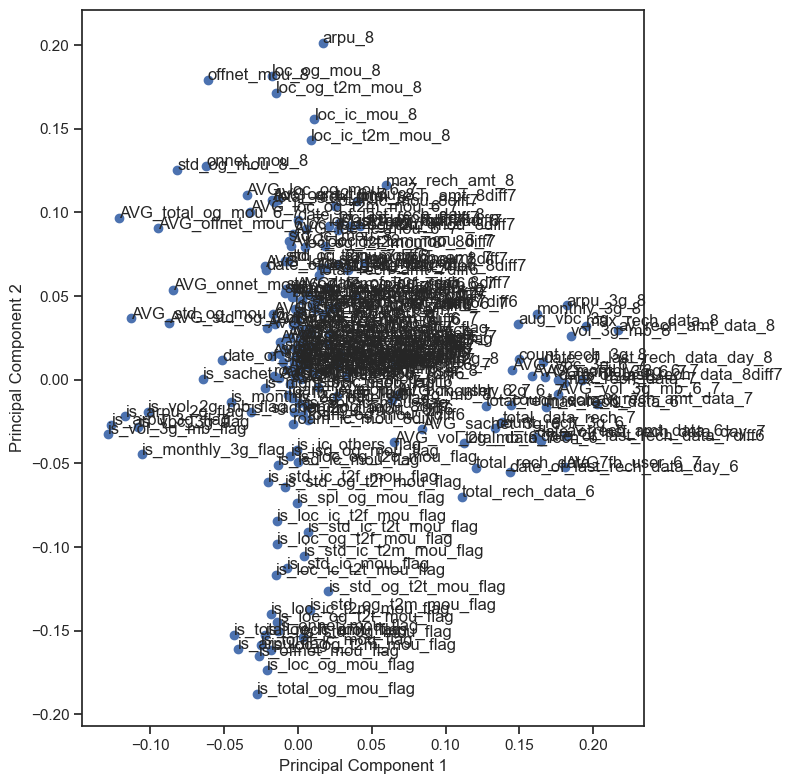

In [264]:
%matplotlib inline
fig = plt.figure(figsize = (8,8))
plt.scatter(pcs_df.PC1, pcs_df.PC2)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
for i, txt in enumerate(pcs_df.Feature):
    plt.annotate(txt, (pcs_df.PC1[i],pcs_df.PC2[i]))
plt.tight_layout()
plt.show()

In [265]:
pca.explained_variance_ratio_

array([7.54352837e-02, 5.22263371e-02, 3.80054398e-02, 2.91606363e-02,
       2.59532987e-02, 2.22214036e-02, 2.06273760e-02, 1.93655524e-02,
       1.62638551e-02, 1.53717639e-02, 1.53082822e-02, 1.47440856e-02,
       1.40255654e-02, 1.34706342e-02, 1.33758923e-02, 1.31152711e-02,
       1.30682829e-02, 1.21921530e-02, 1.17847246e-02, 1.16954899e-02,
       1.13113057e-02, 1.08214657e-02, 1.06645754e-02, 1.03393507e-02,
       1.03004847e-02, 9.85796972e-03, 9.64915872e-03, 9.44187920e-03,
       9.29973679e-03, 9.05929060e-03, 8.94540618e-03, 8.76266481e-03,
       8.62955093e-03, 8.33525616e-03, 8.31342331e-03, 8.20076698e-03,
       8.16683999e-03, 7.99670956e-03, 7.86925782e-03, 7.68232051e-03,
       7.61055747e-03, 7.48886877e-03, 7.30364189e-03, 7.14279545e-03,
       7.01587439e-03, 6.93147685e-03, 6.81666294e-03, 6.74981807e-03,
       6.47122903e-03, 6.37785289e-03, 6.33580030e-03, 6.03108503e-03,
       5.89047840e-03, 5.84273770e-03, 5.77148864e-03, 5.65716034e-03,
      

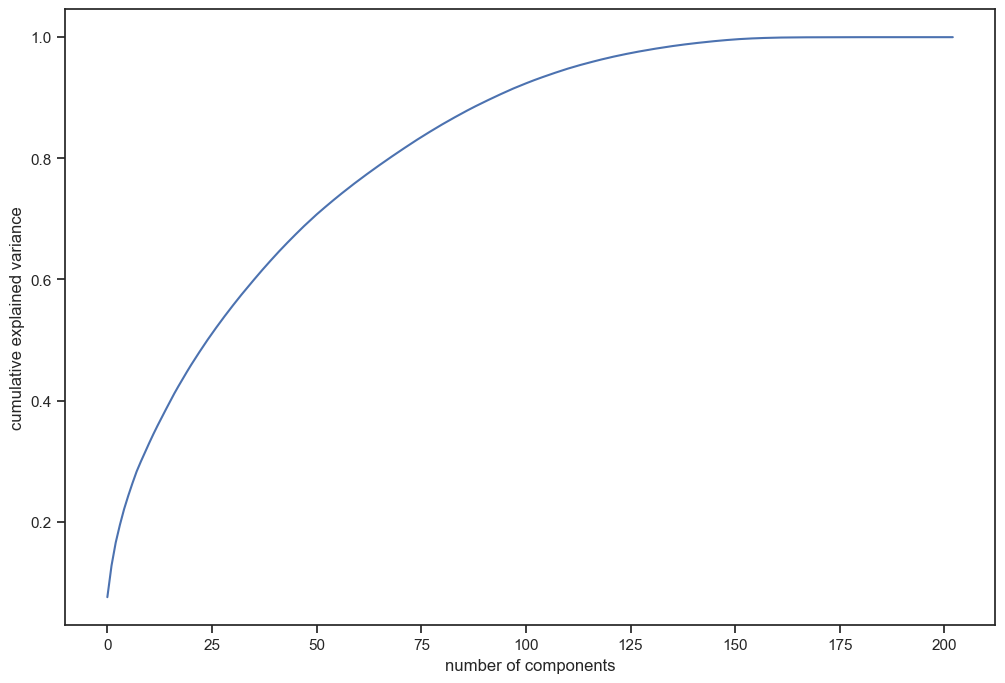

In [266]:
#Making the screeplot - plotting the cumulative variance against the number of components
%matplotlib inline
fig = plt.figure(figsize = (12,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [267]:
print("pca.explained_variance_ratio_: ",pca.explained_variance_ratio_.round(3)*100)

pca.explained_variance_ratio_:  [7.5 5.2 3.8 2.9 2.6 2.2 2.1 1.9 1.6 1.5 1.5 1.5 1.4 1.3 1.3 1.3 1.3 1.2
 1.2 1.2 1.1 1.1 1.1 1.  1.  1.  1.  0.9 0.9 0.9 0.9 0.9 0.9 0.8 0.8 0.8
 0.8 0.8 0.8 0.8 0.8 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.6 0.6 0.6 0.6 0.6 0.6
 0.6 0.6 0.6 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.3
 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.2 0.2 0.2 0.2
 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0. ]


In [268]:
print (pca.explained_variance_ratio_.cumsum())

[0.07543528 0.12766162 0.16566706 0.1948277  0.220781   0.2430024
 0.26362978 0.28299533 0.29925918 0.31463095 0.32993923 0.34468331
 0.35870888 0.37217951 0.38555541 0.39867068 0.41173896 0.42393111
 0.43571584 0.44741133 0.45872263 0.4695441  0.48020867 0.49054803
 0.50084851 0.51070648 0.52035564 0.52979752 0.53909725 0.54815655
 0.55710195 0.56586462 0.57449417 0.58282942 0.59114285 0.59934361
 0.60751045 0.61550716 0.62337642 0.63105874 0.6386693  0.64615817
 0.65346181 0.6606046  0.66762048 0.67455196 0.68136862 0.68811844
 0.69458967 0.70096752 0.70730332 0.7133344  0.71922488 0.72506762
 0.73083911 0.73649627 0.74208537 0.74755826 0.75297948 0.75830994
 0.76349969 0.76864966 0.7737713  0.77878726 0.78376862 0.78868512
 0.79356247 0.79834216 0.80310265 0.80780714 0.81248582 0.81707732
 0.8216576  0.82617121 0.83067599 0.83500741 0.83932098 0.84357424
 0.84777627 0.85190632 0.85597278 0.85993761 0.86384439 0.86770249
 0.87150369 0.8752869  0.87896918 0.88256351 0.8860823  0.88952

In [276]:
#Using incremental PCA for efficiency - saves a lot of time on larger datasets
from sklearn.decomposition import IncrementalPCA
pca_final = IncrementalPCA(n_components=54)

In [278]:
df_train_pca = pca_final.fit_transform(X_train)
df_train_pca.shape

(23962, 54)

In [279]:
#creating correlation matrix for the principal components
corrmat = np.corrcoef(df_train_pca.transpose())

<Axes: >

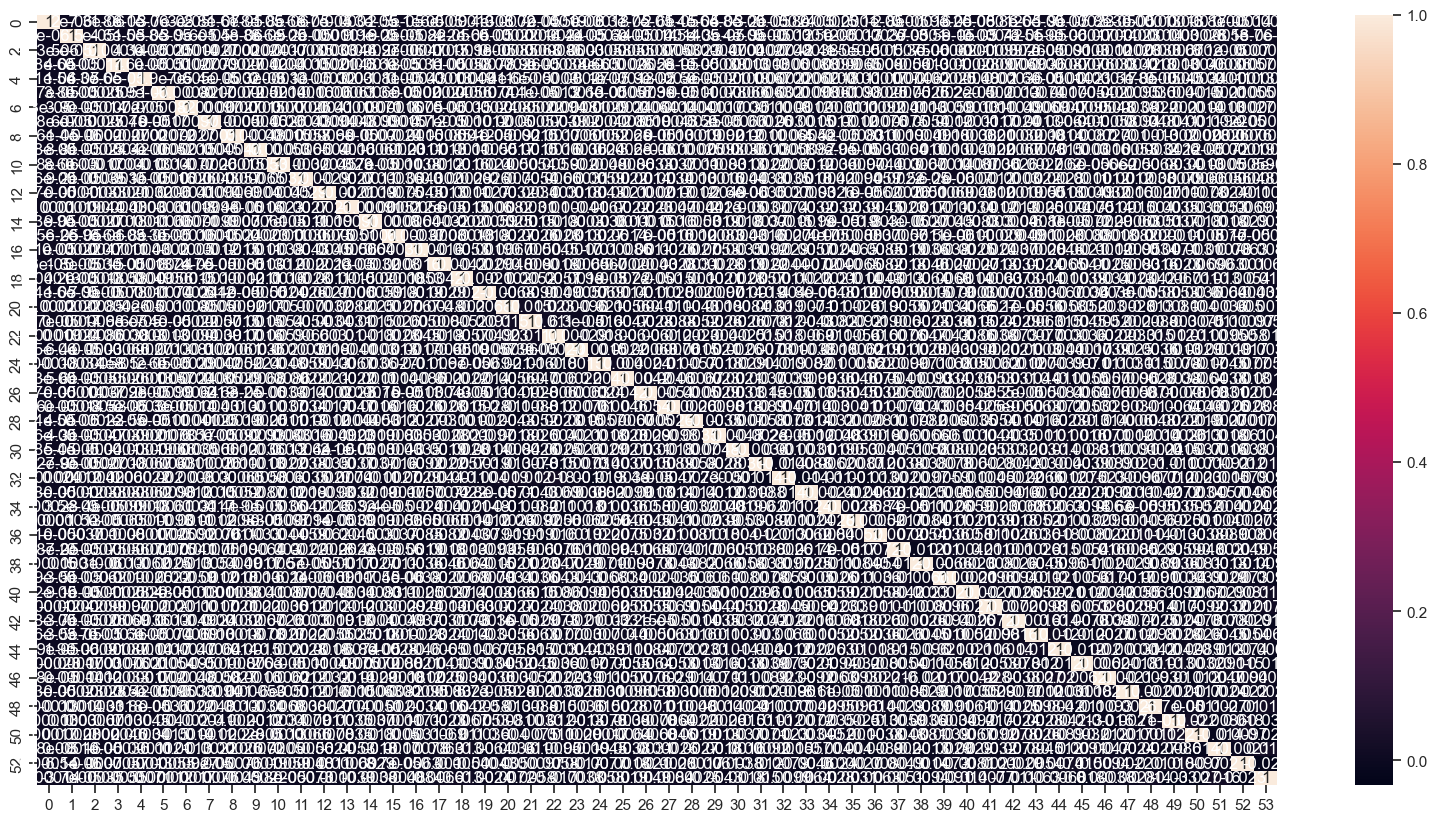

In [280]:
#plotting the correlation matrix
%matplotlib inline
plt.figure(figsize = (20,10))
sns.heatmap(corrmat,annot = True)

In [289]:
# 1s -> 0s in diagonals
corrmat_nodiag = corrmat - np.diagflat(corrmat.diagonal())
print("max corr:",corrmat_nodiag.max(), ", min corr: ", corrmat_nodiag.min(),)
# we see that correlations are indeed very close to 0

max corr: 0.028362129402159344 , min corr:  -0.03261009862684501


In [291]:
#Applying selected components to the test data
df_test_pca = pca_final.transform(X_test)
df_test_pca.shape

(5991, 54)

### Logistic Regression
<br>
Logistic Regression is a classification algorithm. It is used to predict a binary outcome or Multi class outcome, given a set of independent variables. Logistic regression is a special case of linear regression when the outcome variable is categorical, where we are using log of odds as dependent variable. In simple words, it predicts the probability of occurrence of an event by fitting data to a logit function. <br>

Let's first fit a model with default hyperparameters.

In [294]:
#Training the model on the train data
from sklearn.linear_model import LogisticRegression

learner_pca = LogisticRegression()
model_pca = learner_pca.fit(df_train_pca,y_train)

In [296]:
#Making prediction on the test data
pred_probs_test = model_pca.predict_proba(df_test_pca)[:,1]
"{:2.2}".format(metrics.roc_auc_score(y_test, pred_probs_test))

'0.89'

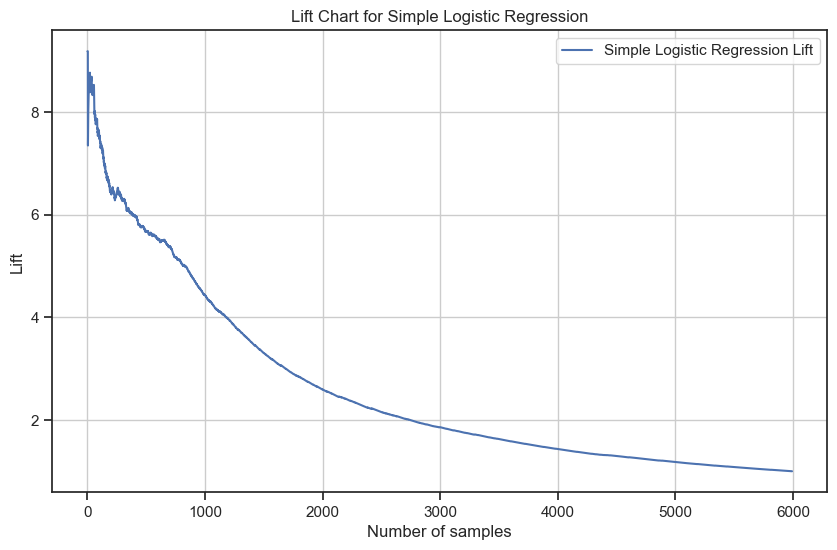

In [302]:
import matplotlib.pyplot as plt
import numpy as np

def plotLiftChart(y_true, y_pred_probs, model_name="Model"):
    # Sort the predicted probabilities in descending order
    sorted_indices = np.argsort(y_pred_probs)[::-1]
    y_true_sorted = y_true[sorted_indices]
    y_pred_probs_sorted = y_pred_probs[sorted_indices]

    # Calculate lift and cumulative lift
    total_positive = np.sum(y_true)
    cumulative_positive = np.cumsum(y_true_sorted)
    lift = cumulative_positive / (np.arange(1, len(y_true_sorted) + 1) / len(y_true_sorted)) / total_positive

    # Plot the lift chart
    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(1, len(y_true_sorted) + 1), lift, label=f"{model_name} Lift", color='b')
    plt.xlabel("Number of samples")
    plt.ylabel("Lift")
    plt.title(f"Lift Chart for {model_name}")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

# Usage
plotLiftChart(y_test.values, pred_probs_test, "Simple Logistic Regression")


- In here we used 54 components, which could nearly explain 85% variance in dataset
- We were able to achieve 89% Area under the curve on the test set

Let's build couple of more models with different number of components. Let's see if the results changes

In [304]:
pca_last1 = PCA(n_components=48)
df_train_pca1 = pca_last1.fit_transform(X_train)
df_test_pca1 = pca_last1.transform(X_test)
df_test_pca1.shape

(5991, 48)

In [306]:
#training the regression model
learner_pca1 = LogisticRegression()
model_pca1 = learner_pca1.fit(df_train_pca1,y_train)
#Making prediction on the test data
pred_probs_test1 = model_pca1.predict_proba(df_test_pca1)[:,1]
"{:2.2f}".format(metrics.roc_auc_score(y_test, pred_probs_test1))

'0.89'

In [308]:
pca_last2 = PCA(n_components=15)
df_train_pca2 = pca_last2.fit_transform(X_train)
df_test_pca2 = pca_last2.transform(X_test)
df_test_pca2.shape

(5991, 15)

In [310]:
#training the regression model
learner_pca2 = LogisticRegression()
model_pca2 = learner_pca2.fit(df_train_pca2,y_train)
#Making prediction on the test data
pred_probs_test2 = model_pca2.predict_proba(df_test_pca2)[:,1]
"{:2.2f}".format(metrics.roc_auc_score(y_test, pred_probs_test2))

'0.88'

## Choice of Evaluation Metric

Choosing a metric is one of the key criteria for our analysis, as the dataset is imbalanced one

**Accuracy = correct predictions / total predictions = (TP + TN)/ (all)**
For a data set which is balanced, this might make a good measure. For an imbalanced dataset like the current one, where the negative class is heavier, this measure may show a high accuracy but fail to serve the purpose of the modeling exercise. We need to be able to predict non-churn i.e.; positive outcomes correctly to help business. So Accuracy may not be the best measure here.

**Recall(sensitivity) = ability to identify Positives as true =  TP/(TP + FN)**
Considering that we wish to clearly identify customers who might churn vs non-churn, recall as a metric with its ability to identify true positives might be more apt. But this does not capture models ability to mis-classify negative class as positive i.e.; False positive rate. So, if we choose a model purely based on recall, we might be blind sighted by a huge number of false positive.

**Precision = TP/ (TP + FP) = Positive predictive value:**
It is important to not only understand the rate of identifying positives as true but also identify False positives. If business is to make a decision on marketing spend to retain customers to all positive output of the model, it becomes important that the false positive rate should not be too high. So Precision as a metric - which provides the rate of true positive /total predicted positives is an apt metric to look at here.

**F Score = 2 * Precision * Recall/ (Precision * Recall):**
Fscore is the harmonic mean of Precision and Recall and provides the ability to balance the need between having a better true positive rate and not too high a false positive rate. 

**Area under the Curve:**

AUC or in the classification world – AUC ROC – Area under the curve for  Receiver Operating Characteristic curve is generally used to compare two different models. It used two metrics from the confusion matrix the true positive rate and false positive rate.

**True positive rate (TPR), recall** as described above is proportion of positive data points correctly identified as positive by the model
**False positive rate (FPR)**, which is defined as FP/(FP+TN) is all the negative data points that are mistakenly identified as positive as a proportion of all negative data points. 

The TPR and FPR metrics are calculated for several threshold values and a curve is plotted with these. The resulting curve is called ROC. AUC is the computation of the area under ROC curve. For a model selection, we always look for maximizing the AUC for the classifier. As this value is comparable across models.

### Logistic Regression - with penalty

In [313]:
from sklearn.feature_selection import RFE

In [315]:
logmodel_CW_dict = LogisticRegression(class_weight='balanced',penalty='l2',random_state=9999,solver='newton-cg',C=10000000,n_jobs=-1)

In [317]:
logmodel_CW_dict.fit(df_train_pca,y_train)

LogisticRegression(C=10000000, class_weight='balanced', n_jobs=-1,
                   random_state=9999, solver='newton-cg')

              precision    recall  f1-score   support

           0       0.98      0.80      0.88      5339
           1       0.34      0.84      0.49       652

    accuracy                           0.81      5991
   macro avg       0.66      0.82      0.68      5991
weighted avg       0.91      0.81      0.84      5991

Accuracy for the test dataset 80.7%
ROC for the test dataset 82.2%


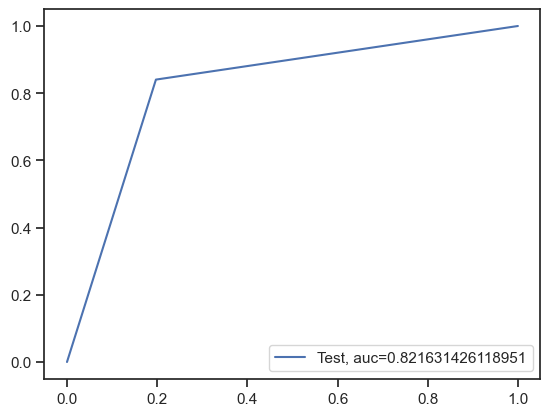

In [318]:
predictions = logmodel_CW_dict.predict(df_test_pca)
prediction_probs = logmodel_CW_dict.predict_proba(df_test_pca)[:,1]
print(classification_report(y_test, predictions))
accuracy = metrics.accuracy_score(y_test, predictions)
print("Accuracy for the test dataset",'{:.1%}'.format(accuracy) )

fpr, tpr, threshold = metrics.roc_curve(y_test, predictions)
roc_auc = metrics.auc(fpr, tpr)
print("ROC for the test dataset",'{:.1%}'.format(roc_auc))
plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
plt.legend(loc=4)
plt.show()


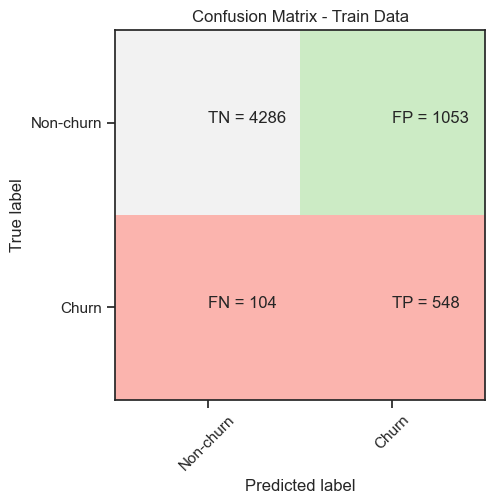

In [319]:
cm = confusion_matrix(y_test, predictions)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Pastel1)
classNames = ['Non-churn','Churn']
plt.title('Confusion Matrix - Train Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]),fontsize=12)
plt.show()

### Lift Metric
<br>
What is Lift measure? <br>

Lift measures expected benefit with the predictive model compared to a base line model – in essence a random choice. It is the ratio of proportion of the gain to the proportion of random expectation at any given decile level. The random expectation at the xth decile is x%.

In [323]:
def plotLiftChart(actual, predicted,title_str):
    df_dict = {'actual': list (actual), 'pred': list(predicted)}
    df = pd.DataFrame(df_dict)
    pred_ranks = pd.qcut(df['pred'].rank(method='first'), 100, labels=False)
    actual_ranks = pd.qcut(df['actual'].rank(method='first'), 100, labels=False)
    pred_percentiles = df.groupby(pred_ranks).mean()
    actual_percentiles = df.groupby(actual_ranks).mean()
    plt.title(title_str)
    plt.plot(np.arange(.01, 1.01, .01), np.array(pred_percentiles['pred']),
             color='darkorange', lw=2, label='Prediction')
    plt.plot(np.arange(.01, 1.01, .01), np.array(pred_percentiles['actual']),
             color='navy', lw=2, linestyle='--', label='Actual')
    plt.ylabel('Target Percentile')
    plt.xlabel('Population Percentile')
    plt.xlim([0.0, 1.0])
    plt.ylim([-0.05, 1.05])
    from pylab import rcParams
    rcParams['figure.figsize'] = 10, 4

    plt.legend(loc="best")
    plt.show()

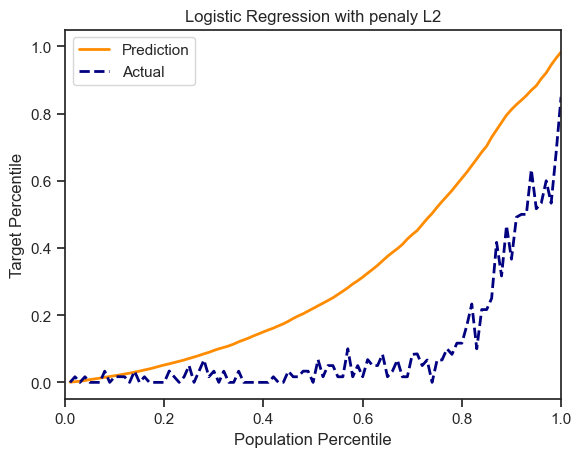

In [326]:
plotLiftChart(y_test.values,prediction_probs,"Logistic Regression with penaly L2")

### Create Stratefied Kfold Samples

The regular K-Fold cross validation may not be applicable for an imbalanced dataset. As the folds created may not retain class proportions, even if they did, most classifiers need some manipulation of the dataset to balance it (oversampling of positive class or under sampling of negative class).<br>
To Cross validate an imbalanced dataset, we might have to apply stratified cross validation. Stratification seeks to ensure that each fold is representative of all classes of the data. <br>
- Random Sampling: The given dataset is highly imbalanced. Churn classes is only 10% of the entire dataset. With such a dataset random sampling might not be able to pick up enough data of both the classes 
- Stratified Sampling: Stratified sampling will be able to sample enough data of both the classes. But, considering that the churn class is only 10% of the entire dataset, stratified sampling might significantly reduce the number of cases, so it should ideally be coupled with a resampling technique to ensure balance in data.

In [330]:
from sklearn.model_selection  import StratifiedKFold
stratefied_Kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=9999)

In [332]:
from sklearn.linear_model import LogisticRegressionCV

searchCV = LogisticRegressionCV(
        Cs= list(np.power(10.0, np.arange(-10, 10)))
        ,penalty='l2'
        ,scoring='roc_auc'
        ,cv=stratefied_Kfold
        ,random_state=777
        ,max_iter=100
        ,fit_intercept=True
        ,solver='newton-cg'
        ,tol=1
        ,verbose = 2
        ,n_jobs = -1
    
    )

In [334]:
searchCV.fit(df_train_pca,y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    3.5s finished


LogisticRegressionCV(Cs=[1e-10, 1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001,
                         0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0,
                         100000.0, 1000000.0, 10000000.0, 100000000.0,
                         1000000000.0],
                     cv=StratifiedKFold(n_splits=4, random_state=9999, shuffle=True),
                     n_jobs=-1, random_state=777, scoring='roc_auc',
                     solver='newton-cg', tol=1, verbose=2)

In [335]:
print("final selected 1/lambda is ", searchCV.C_)
print("final selected lambda is ", 1/searchCV.C_)

final selected 1/lambda is  [1.e-10]
final selected lambda is  [1.e+10]


              precision    recall  f1-score   support

           0       0.89      1.00      0.94      5339
           1       0.00      0.00      0.00       652

    accuracy                           0.89      5991
   macro avg       0.45      0.50      0.47      5991
weighted avg       0.79      0.89      0.84      5991

Accuracy for the test dataset 89.1%
ROC for the test dataset 50.0%


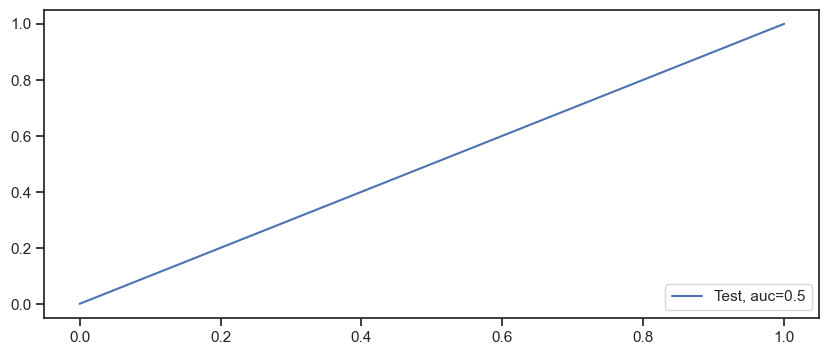

In [336]:
#train data
preds_L2Search = searchCV.predict(df_test_pca)
preds_L2Search_probs = searchCV.predict_proba(df_test_pca)[:,1]

print(classification_report(y_test, preds_L2Search))
accuracy = metrics.accuracy_score(y_test, preds_L2Search)
print("Accuracy for the test dataset",'{:.1%}'.format(accuracy) )

fpr, tpr, threshold = metrics.roc_curve(y_test, preds_L2Search_probs)
roc_auc = metrics.auc(fpr, tpr)
print("ROC for the test dataset",'{:.1%}'.format(roc_auc))
plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
plt.legend(loc=4)
plt.show()


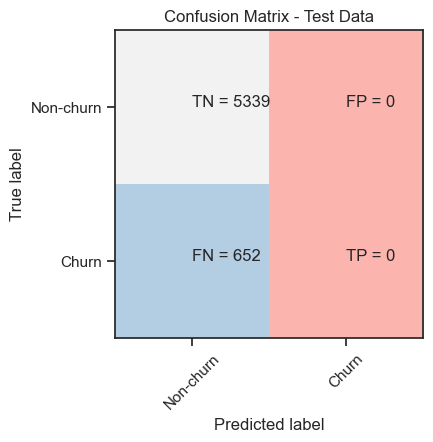

In [337]:
cm = confusion_matrix(y_test, preds_L2Search)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Pastel1)
classNames = ['Non-churn','Churn']
plt.title('Confusion Matrix - Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]),fontsize=12)
plt.show()

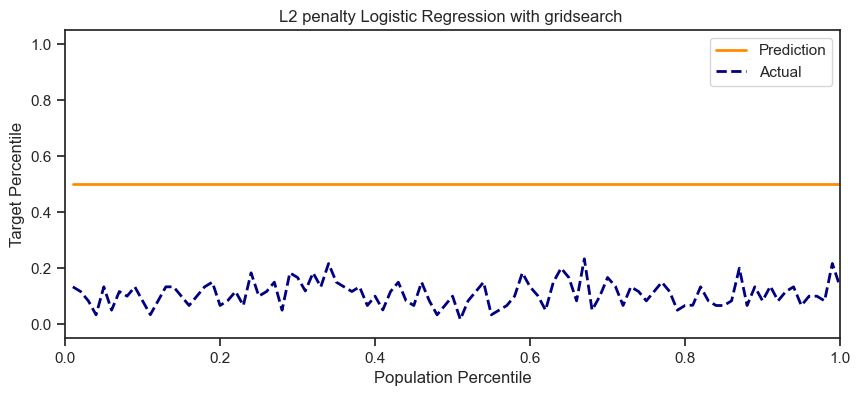

In [342]:
plotLiftChart(y_test.values,preds_L2Search_probs,"L2 penalty Logistic Regression with gridsearch ")

### Random Forest 
<br>

Random forest algorithm is based on a concept called bagging - bootstrap aggregating. In random forest, we build a number of decision trees on bootstrap training samples. The samples are chosen, as split candidates from all the X variables (predictors). <br>
So, the random forest at each split is allowed to consider a subset of the predictors. If not, One or Few strong predictors, might always become the most important predictor leading to similar looking trees. Which leads to no reduction in the variance. This process can be thought of as de-correlating the trees or feature bagging. Because of this, the Random forest can also be used to rank the importance of variables. <br>
Similarly bootstrapping of sample rows is also done. <br>


Let's first fit a random forest model with default hyperparameters.

In [349]:
from sklearn.ensemble import RandomForestClassifier

RFC_balanced = RandomForestClassifier(
    n_estimators=10, 
    criterion='gini', 
    max_depth=None,
    min_samples_split=500, 
    min_samples_leaf=1, 
    min_weight_fraction_leaf=0.0, 
    max_features='auto', 
    max_leaf_nodes=None, 
    min_impurity_decrease=1e-07,  # Replacing min_impurity_split with min_impurity_decrease
    bootstrap=True, 
    oob_score=False, 
    n_jobs=-1, 
    random_state=9999, 
    verbose=0, 
    warm_start=False, 
    class_weight="balanced_subsample"
)



In [353]:
from sklearn.ensemble import RandomForestClassifier

RFC_balanced = RandomForestClassifier(
    n_estimators=10, 
    criterion='gini', 
    max_depth=None,
    min_samples_split=500, 
    min_samples_leaf=1, 
    min_weight_fraction_leaf=0.0, 
    max_features='sqrt',  # Replacing 'auto' with 'sqrt'
    max_leaf_nodes=None, 
    min_impurity_decrease=1e-07, 
    bootstrap=True, 
    oob_score=False, 
    n_jobs=-1, 
    random_state=9999, 
    verbose=0, 
    warm_start=False, 
    class_weight="balanced_subsample"
)

# Fit the model
TrainedRFC = RFC_balanced.fit(df_train_pca, y_train)


              precision    recall  f1-score   support

           0       0.97      0.84      0.90      5339
           1       0.39      0.80      0.52       652

    accuracy                           0.84      5991
   macro avg       0.68      0.82      0.71      5991
weighted avg       0.91      0.84      0.86      5991

Accuracy for the test dataset 84.0%
ROC for the test dataset 88.5%


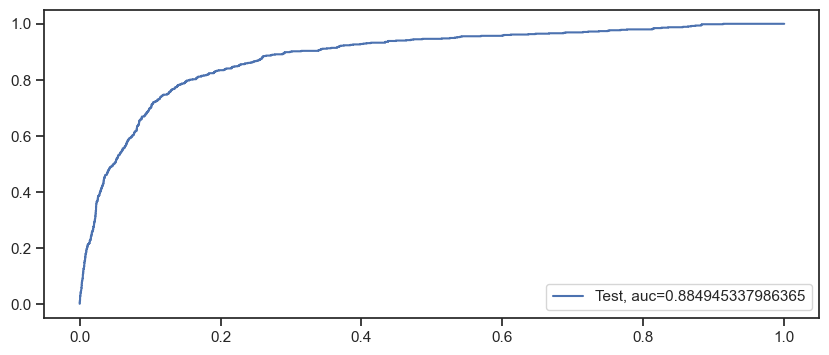

In [355]:
preds_RFC=TrainedRFC.predict(df_test_pca)
preds_probs_RFC=TrainedRFC.predict_proba(df_test_pca)[:,1]

print(classification_report(y_test, preds_RFC))
accuracy = metrics.accuracy_score(y_test, preds_RFC)
print("Accuracy for the test dataset",'{:.1%}'.format(accuracy) )

fpr, tpr, threshold = metrics.roc_curve(y_test, preds_probs_RFC)
roc_auc = metrics.auc(fpr, tpr)
print("ROC for the test dataset",'{:.1%}'.format(roc_auc))
plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
plt.legend(loc=4)
plt.show()

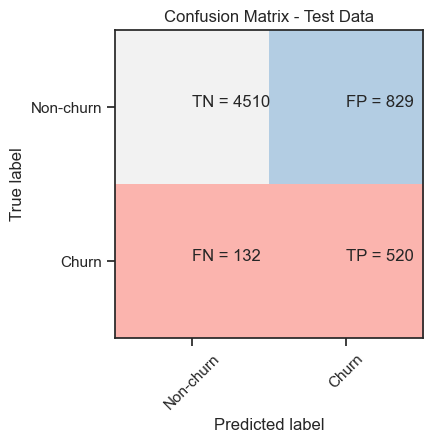

In [357]:
cm = confusion_matrix(y_test, preds_RFC)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Pastel1)
classNames = ['Non-churn','Churn']
plt.title('Confusion Matrix - Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]),fontsize=12)
plt.show()

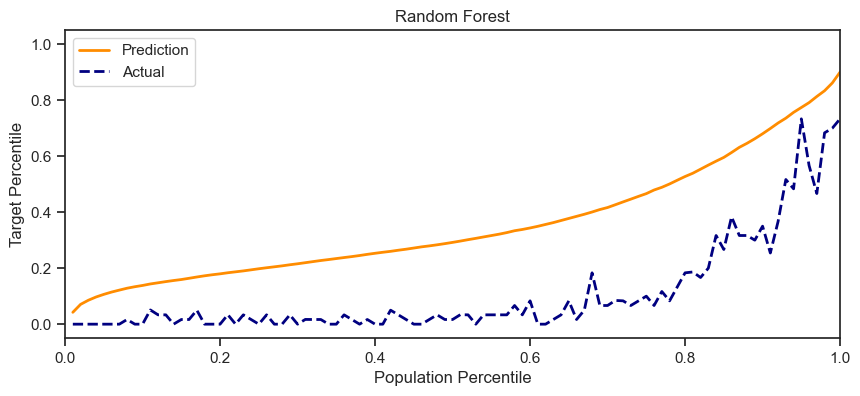

In [359]:
plotLiftChart(y_test.values,preds_probs_RFC,"Random Forest")

In [366]:
importances = TrainedRFC.feature_importances_
col_names = X.columns

# Correcting the columns definition to a list instead of a set
sorted_feature_importance = pd.DataFrame(
    sorted(zip(importances, list(col_names)), reverse=True),
    columns=['colName', 'value']  # Using a list for columns
)

sorted_feature_importance


colName               value
0      0.34         onnet_mou_8
1      0.07        offnet_mou_8
2      0.06       roam_ic_mou_8
3      0.04       roam_og_mou_8
4      0.04     count_rech_3g_6
5      0.03              arpu_8
6      0.03    std_ic_t2m_mou_8
7      0.03  av_rech_amt_data_7
8      0.02     max_rech_data_6
9      0.02     max_rech_data_7
10     0.02        spl_og_mou_8
11     0.02    loc_og_t2t_mou_8
12     0.02           fb_user_8
13     0.02        isd_ic_mou_8
14     0.02    night_pck_user_8
15     0.01        loc_og_mou_8
16     0.01           arpu_3g_8
17     0.01      max_rech_amt_6
18     0.01     count_rech_3g_8
19     0.01         vol_3g_mb_8
20     0.01        isd_og_mou_8
21     0.01   total_rech_data_6
22     0.01   total_rech_data_8
23     0.01        std_og_mou_8
24     0.01  av_rech_amt_data_6
25     0.01   total_rech_data_7
26     0.01     max_rech_data_8
27     0.01         vol_2g_mb_8
28     0.01        loc_ic_mou_8
29     0.01    loc_og_t2m_mou_8
30     0.01    loc_og_t2f_mou_8
31     0.01         og_others_8
32     0.01      max_rech_amt_8
33     0.01      max_rech_amt_7
34     0.00    loc_ic_t2f_mou_8
35     0.00    total_rech_num_8
36     0.00  last_day_rch_amt_8
37     0.00         ic_others_8
38     0.00    std_ic_t2f_mou_8
39     0.00  last_day_rch_amt_7
40     0.00    loc_ic_t2m_mou_8
41     0.00    std_ic_t2t_mou_8
42     0.00  av_rech_amt_data_8
43     0.00        monthly_2g_8
44     0.00        std_ic_mou_8
45     0.00          aug_vbc_3g
46     0.00        spl_ic_mou_8
47     0.00                 aon
48     0.00    loc_ic_t2t_mou_8
49     0.00    loc_og_t2c_mou_8
50     0.00    std_og_t2f_mou_8
51     0.00        monthly_3g_8
52     0.00     count_rech_3g_7
53     0.00  last_day_rch_amt_6

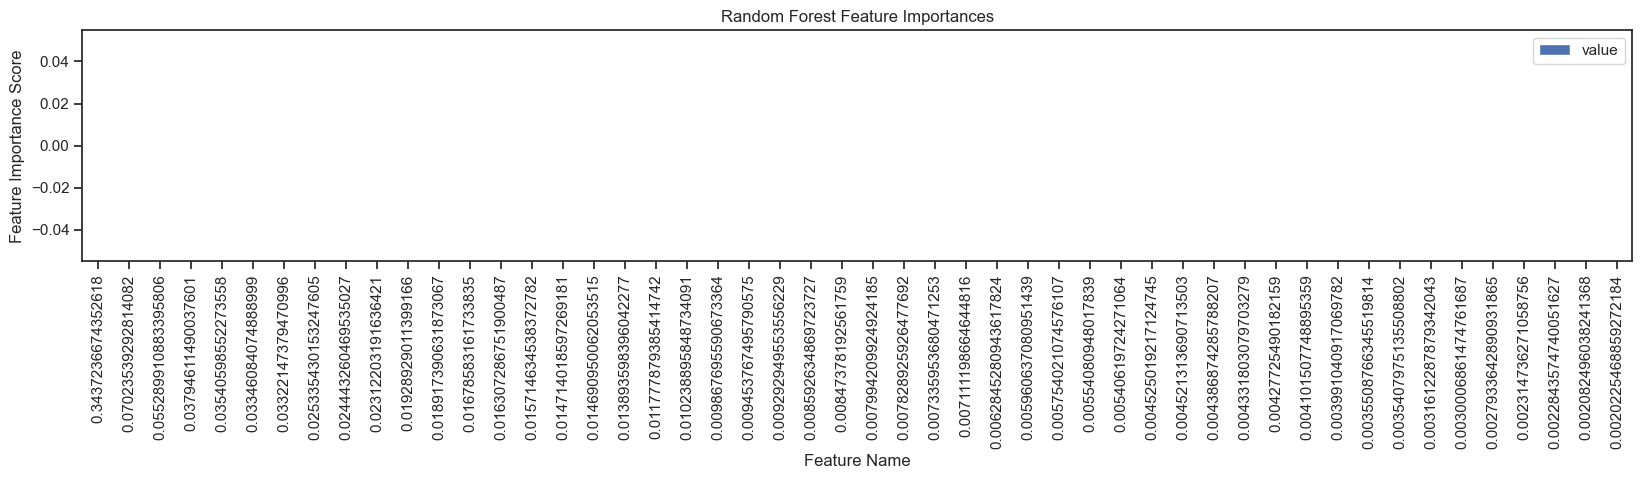

In [370]:
import matplotlib.pyplot as plt
from pylab import rcParams

# Adjust figure size
rcParams['figure.figsize'] = 20, 3

# Ensure the 'value' column is numeric
sorted_feature_importance['value'] = pd.to_numeric(sorted_feature_importance['value'], errors='coerce')

# Plot the feature importance for top 50 features
sorted_feature_importance[0:50].plot(x='colName', y='value', kind='bar', title='Random Forest Feature Importances')

# Add labels and title
plt.ylabel('Feature Importance Score')
plt.xlabel('Feature Name')

# Display the plot
plt.show()


### Gradient boosting
<br>
Boosting is a method of converting weak learners into strong learners. In boosting, each new tree is a fit on a modified version of the original data set. <br> 

Gradient boosting uses the concept of boosting. It also fits separate decision trees to the training data set but the trees are grown sequentially essentially to fix the mistakes of the previous tree. This is why, boosting is called the ensemble of weak prediction models. Suppose the gradient boosting model starts with a weak model Fm. In the next iteration it tries to add to the previous weak model, in such a way, that the prediction becomes stronger, i.e; <br>
>                           Fm+1(x) =  Fm (x) + h(x)= y

Here h is essentially a residual from the previous model, so gradient boosting is a generalization of the gradient decent algorithm that reduces the residuals.

In [ ]:
from sklearn import ensemble

# Fit classifier with out-of-bag estimates
params = {'n_estimators': 200, 'max_depth': 3, 'subsample': 0.5,
          'learning_rate': 0.01, 'min_samples_leaf': 10, 'random_state': 9999}
GBC = ensemble.GradientBoostingClassifier(**params)

In [374]:
GBC.fit(df_train_pca,y_train)

GradientBoostingClassifier(learning_rate=0.01, min_samples_leaf=10,
                           n_estimators=200, random_state=9999, subsample=0.5)

              precision    recall  f1-score   support

           0       0.93      0.98      0.95      5339
           1       0.69      0.36      0.47       652

    accuracy                           0.91      5991
   macro avg       0.81      0.67      0.71      5991
weighted avg       0.90      0.91      0.90      5991

Accuracy for the test dataset 91.3%
ROC for the test dataset 89.1%


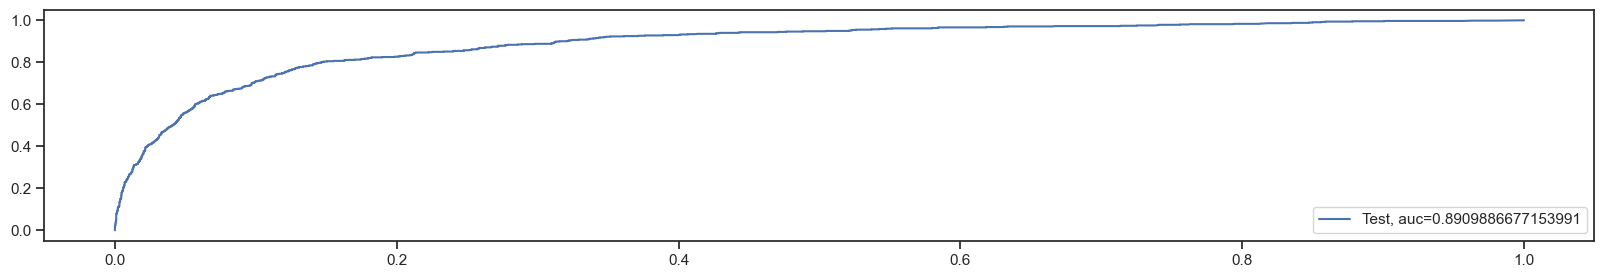

In [375]:
preds_GBC = GBC.predict(df_test_pca)
preds_probs_GBC = GBC.predict_proba(df_test_pca)[:,1]

print(classification_report(y_test, preds_GBC))
accuracy = metrics.accuracy_score(y_test, preds_GBC)
print("Accuracy for the test dataset",'{:.1%}'.format(accuracy))

fpr, tpr, threshold = metrics.roc_curve(y_test, preds_probs_GBC)
roc_auc = metrics.auc(fpr, tpr)
print("ROC for the test dataset",'{:.1%}'.format(roc_auc))
plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
plt.legend(loc=4)
plt.show()

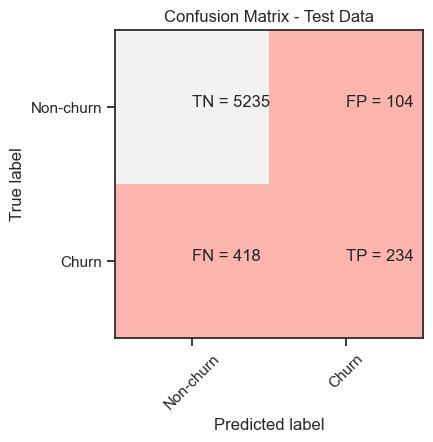

In [388]:
cm = confusion_matrix(y_test, preds_GBC)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Pastel1)
classNames = ['Non-churn','Churn']
plt.title('Confusion Matrix - Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]),fontsize=12)
plt.show()

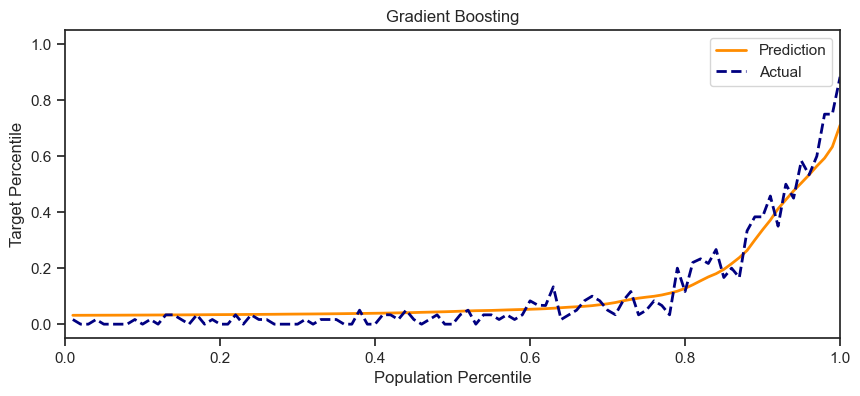

In [390]:
plotLiftChart(y_test.values,preds_probs_GBC,"Gradient Boosting")

#### Difference between random forest and gradient boosting

| Random Forest | Gradient Boosting |
| --- | --- |
| Bagging  + Decision Trees | Boosting + Gradient Descent |
| Many trees – different samples – aggregated voting for class prediction | Sequential trees – each improving on the prior tree – each tree improves classification |
| Independent trees | Dependent trees |
| Reduces variance, with minimal increase in bias | Minimizes bias |
| Hyperparameters – well established, easy to apply | Hyperparameters – need care in configuration |


### Gradient Boosting with Hyperparameter tuning

Let's now try to tune hyperparameters in gradient boosting classifier. Start with with two hyperparameters - n_estimators and max_depth.

- n_estimators: integer, optional (default=10): The number of trees in the forest
- max_depth : integer or None, optional (default=None)The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples

#### Change in estimators & max_depth

In [396]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

# Parameters for grid search
param_test = {'n_estimators': range(200, 500, 100), 'max_depth': range(5, 8, 1)}

# Create GridSearchCV object
gsearch1 = GridSearchCV(
    estimator=GradientBoostingClassifier(
        learning_rate=0.05,
        min_samples_split=20,
        min_samples_leaf=10,
        subsample=0.1,
        random_state=9999,
        verbose=2
    ),
    param_grid=param_test,
    scoring='roc_auc',
    n_jobs=-1,
    cv=None,
    verbose=2
)

In [ ]:
gsearch1.fit(df_train_pca,y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


In [ ]:
gsearch1.best_params_, gsearch1.best_score_

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      5339
           1       0.62      0.49      0.55       652

    accuracy                           0.91      5991
   macro avg       0.78      0.73      0.75      5991
weighted avg       0.90      0.91      0.91      5991

Accuracy for the test dataset 91.2%
ROC for the test dataset 89.7%


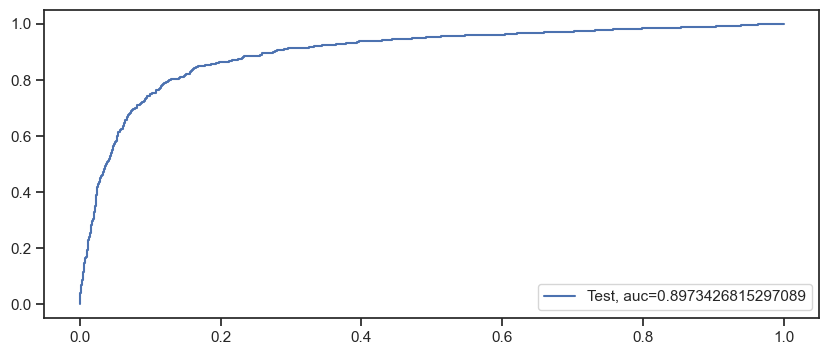

In [406]:
preds_GBC_HT = gsearch1.predict(df_test_pca)
preds_GBC_probs_HT = gsearch1.predict_proba(df_test_pca)[:,1]

print(classification_report(y_test, preds_GBC_HT))
accuracy = metrics.accuracy_score(y_test, preds_GBC_HT)
print("Accuracy for the test dataset",'{:.1%}'.format(accuracy) )

fpr, tpr, threshold = metrics.roc_curve(y_test, preds_GBC_probs_HT)
roc_auc = metrics.auc(fpr, tpr)
print("ROC for the test dataset",'{:.1%}'.format(roc_auc))
plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
plt.legend(loc=4)
plt.show()

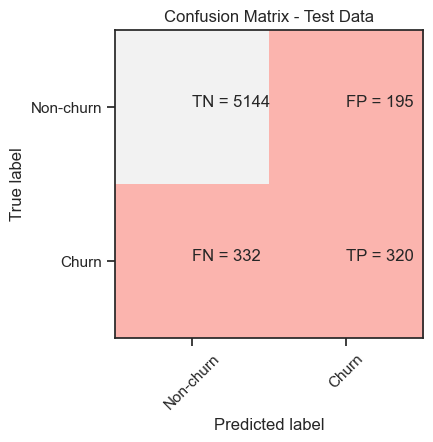

In [408]:
cm = confusion_matrix(y_test, preds_GBC_HT)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Pastel1)
classNames = ['Non-churn','Churn']
plt.title('Confusion Matrix - Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]),fontsize=12)
plt.show()

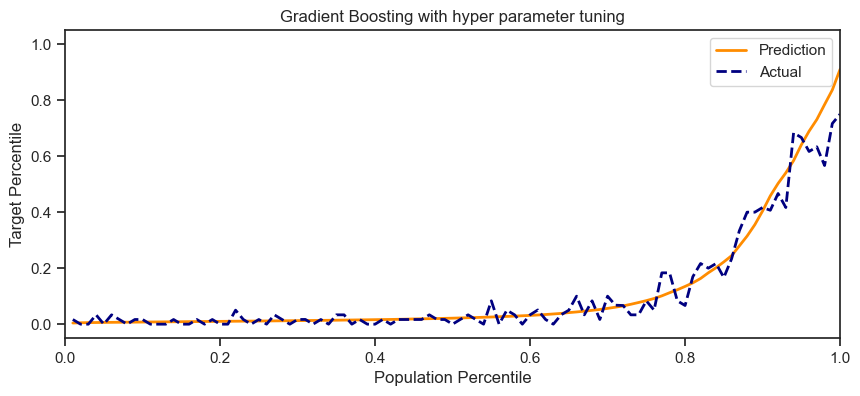

In [410]:
plotLiftChart(y_test.values,preds_GBC_probs_HT,"Gradient Boosting with hyper parameter tuning")

#### Change in min_samples_leaf

Now let's tune min_samples_leaf
- min_samples_leaf : (default=1)The minimum number of samples required to be at a leaf node:
    - If int, then consider min_samples_leaf as the minimum number.
    - If float, then min_samples_leaf is a percentage and ceil(min_samples_leaf * n_samples) are the minimum number of samples for each node.

In [ ]:
param_test = {'min_samples_leaf': range(10,100,20)}

gsearch1 = GridSearchCV(
    estimator = ensemble.GradientBoostingClassifier(
        n_estimators = 100,
        learning_rate=0.05,
        max_depth = 5,
        min_samples_split=100,
        subsample=0.1,
        random_state=9999,verbose = 2,), param_grid = param_test, scoring='roc_auc',n_jobs=-1,iid=False, cv=None,verbose=2)


In [412]:
gsearch1.fit(df_train_pca,y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.6568           0.0316           36.50s
         2           0.5676           0.0176           34.41s
         3           0.5933           0.0233           34.95s
         4           0.6014           0.0202           34.38s
         5           0.5725           0.0143           35.77s
         6           0.5242           0.0089           35.58s
         7           0.5136           0.0108           34.65s
         8           0.5322           0.0140           34.37s
         9           0.5228           0.0103           34.04s
        10           0.5098           0.0081           33.74s
        11           0.5019           0.0062           33.48s
        12           0.5221           0.0113           33.22s
        13           0.4919           0.0029           32.75s
        14           0.5035           0.0089           32.55s
        1

GridSearchCV(estimator=GradientBoostingClassifier(learning_rate=0.05,
                                                  min_samples_leaf=10,
                                                  min_samples_split=20,
                                                  random_state=9999,
                                                  subsample=0.1, verbose=2),
             n_jobs=-1,
             param_grid={'max_depth': range(5, 8),
                         'n_estimators': range(200, 500, 100)},
             scoring='roc_auc', verbose=2)

In [414]:
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 5, 'n_estimators': 200}, 0.891545848190278)

              precision    recall  f1-score   support

           0       0.94      0.97      0.95      5339
           1       0.63      0.45      0.53       652

   micro avg       0.91      0.91      0.91      5991
   macro avg       0.78      0.71      0.74      5991
weighted avg       0.90      0.91      0.91      5991

Accuracy for the test dataset 91.2%
ROC for the test dataset 90.3%


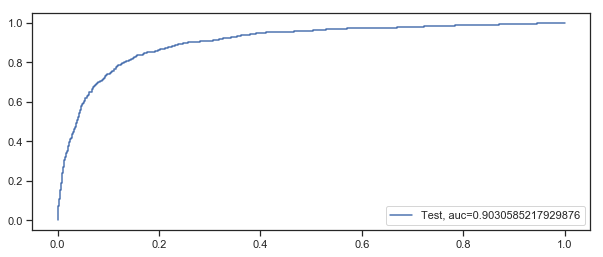

In [406]:
preds_GBC_HT = gsearch1.predict(df_test_pca)
preds_GBC_probs_HT = gsearch1.predict_proba(df_test_pca)[:,1]

print(classification_report(y_test, preds_GBC_HT))
accuracy = metrics.accuracy_score(y_test, preds_GBC_HT)
print("Accuracy for the test dataset",'{:.1%}'.format(accuracy) )

fpr, tpr, threshold = metrics.roc_curve(y_test, preds_GBC_probs_HT)
roc_auc = metrics.auc(fpr, tpr)
print("ROC for the test dataset",'{:.1%}'.format(roc_auc))
plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
plt.legend(loc=4)
plt.show()

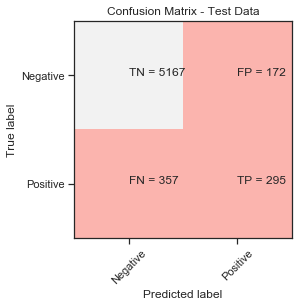

In [407]:
cm = confusion_matrix(y_test, preds_GBC_HT)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Pastel1)
classNames = ['Non-churn','Churn']
plt.title('Confusion Matrix - Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]),fontsize=12)
plt.show()

In [ ]:
plotLiftChart(y_test.values,preds_GBC_probs_HT,"Gradient Boosting with hyper parameter tuning")

### SVM using Non-linear kernal

In [ ]:
# rbf kernel with other hyperparameters kept to default 
svm_rbf = svm.SVC(kernel='rbf')
svm_rbf.fit(df_train_pca, y_train)
# predict
predictions = svm_rbf.predict(df_test_pca)
print("Classification report: ")
print(classification_report(y_test,predictions))
accuracy = metrics.accuracy_score(y_test, predictions)
print("\nAccuracy for the test dataset",'{:.1%}'.format(accuracy) )
fpr, tpr, threshold = metrics.roc_curve(y_test, predictions)
roc_auc = metrics.auc(fpr, tpr)
print("\nROC for the test dataset",'{:.1%}'.format(roc_auc))
plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
plt.legend(loc=4)
plt.show()

## Model Building

#### On original features (instead of principal components)

We have tuned the hyperparameters using GPU enabled one and identified the best ones. <br> Below is the code for the same.
<br>

**Note:**
***The time taken to complete this step is nearly 18hrs. Please make sure the availabilty of the resources for the same***
<br>
Currently we are making this as a markdown. Chnage them to code to get those parameters

### XGBoost - Finding the best hyperparameters

Now it's time to look for the optimal hyperparameters - what does this mean?

We will test our chosen model with different values for (almost) each of its tuning parameters and give back the parameters with which the model performed best.

**The actual searching for optimal parameters is not done in this notebook since the operations can take some time and parallel editing would not be possible.

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

def objective(params):
    params = {
        'max_depth': int(params['max_depth']),
        'gamma': "{:.3f}".format(params['gamma']),
        'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
    }
    
    clf = xgb.XGBClassifier(
        n_estimators=250,
        learning_rate=0.05,
        n_jobs=4,
        **params
    )
    
    score = cross_val_score(clf, X_train, y_train, scoring='f1_weighted', cv=StratifiedKFold()).mean()
    print("F1 score {:.3f} params {}".format(score, params))
    return score

space = {
    'max_depth': hp.quniform('max_depth', 2, 8, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0),
    'gamma': hp.uniform('gamma', 0.0, 0.5),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10)

In [ ]:
#print("estimated optimum {}".format(best))

# The result we got with tuning is
# estimated optimum {'colsample_bytree': 0.552933848345107, 'gamma': 0.22715962641133935, 'max_depth': 8.0}

In [353]:
import xgboost as xgb
from sklearn.cross_validation import StratifiedKFold

C:\Users\vm5.CORPDOM\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [543]:
cv = StratifiedKFold(y_train, n_folds=10,shuffle=True, random_state=111)

xgb_model = xgb.XGBClassifier(
    n_estimators=250,
    learning_rate=0.05,
    n_jobs=4,
    max_depth=8,
    colsample_bytree=0.55,
    gamma=0.23,
    cv = cv,
    scoring='f1_weighted'
)

xgb_model.fit(X=X_train,y=y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.55,
       cv=sklearn.cross_validation.StratifiedKFold(labels=[0 1 ... 1 0], n_folds=10, shuffle=True, random_state=111),
       gamma=0.23, learning_rate=0.05, max_delta_step=0, max_depth=8,
       min_child_weight=1, missing=None, n_estimators=250, n_jobs=4,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       scoring='f1_weighted', seed=None, silent=True, subsample=1)

In [414]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(xgb_model, X_train, y_train, cv=cv, scoring = 'roc_auc')
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.94389825 0.93734843 0.9287959  0.93910436 0.93876765 0.94190615
 0.91921816 0.92939355 0.92792783 0.94394704]
Mean: 0.9350307323666908
Standard Deviation: 0.007826078068478128


Cross validating the models showed that the accuracy values were in fact not arbitary and proofed that both models are performing very well.

A high mean corresponds to a more stable performance and a low standard deviation corresponds to smaller range of results.

In [544]:
predictions_train = xgb_model.predict(X_train)
print(classification_report(y_train, predictions_train))
predictions = xgb_model.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     21359
           1       0.98      0.98      0.98      2603

   micro avg       0.99      0.99      0.99     23962
   macro avg       0.99      0.99      0.99     23962
weighted avg       0.99      0.99      0.99     23962

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      5339
           1       0.71      0.59      0.65       652

   micro avg       0.93      0.93      0.93      5991
   macro avg       0.83      0.78      0.80      5991
weighted avg       0.93      0.93      0.93      5991



In [356]:
def Performance(Model,Y,X):
    # Perforamnce of the model
    fpr, tpr, _ = roc_curve(Y, Model.predict_proba(X)[:,1])
    AUC  = auc(fpr, tpr)
    print ('the AUC is : %0.4f' %  AUC)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % AUC)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

the AUC is : 0.9370


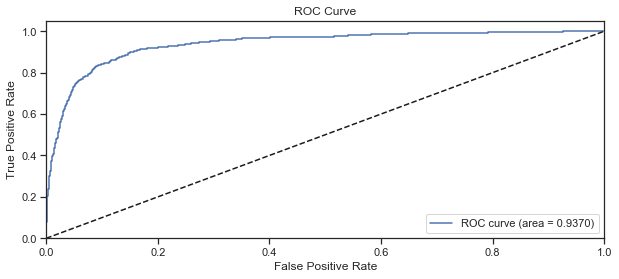

In [545]:
Performance(Model=xgb_model,Y=y_test,X=X_test)

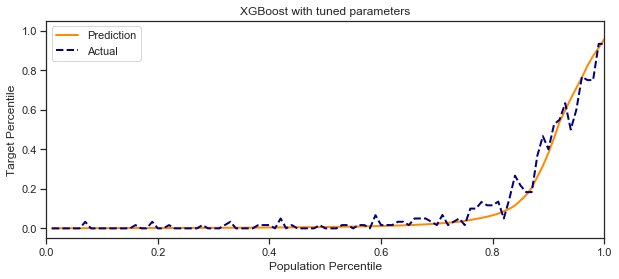

In [546]:
plotLiftChart(y_test.values,xgb_model.predict_proba(X_test)[:,1],"XGBoost with tuned parameters")

### Random Forest

from sklearn.model_selection import cross_val_score
def acc_model(params):
    clf = RandomForestClassifier(**params)
    return cross_val_score(clf, X_train, y_train).mean()

param_space = {
    'max_depth': hp.choice('max_depth', range(1,20)),
    'max_features': hp.choice('max_features', range(1,100)),
    'n_estimators': hp.choice('n_estimators', range(100,500)),
    'criterion': hp.choice('criterion', ["gini", "entropy"])}

best = 0
def f(params):
    global best
    acc = acc_model(params)
    if acc > best:
        best = acc
    print ('new best:', best, params)
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, param_space, algo=tpe.suggest, max_evals=100, trials=trials)
print ('best:')
print (best)

In [461]:
from sklearn.ensemble import RandomForestClassifier

RF2=RandomForestClassifier(max_features=94, n_estimators=200, criterion= 'entropy', max_depth=15,random_state=111, class_weight='balanced')
RF2.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=15, max_features=94,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=None, oob_score=False,
            random_state=111, verbose=0, warm_start=False)

In [415]:
scores = cross_val_score(RF2, X_train, y_train, cv=cv, scoring = 'roc_auc')
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.94221214 0.93437262 0.93012596 0.94265161 0.9360712  0.93970127
 0.9247137  0.92738044 0.92764243 0.93832012]
Mean: 0.9343191495844556
Standard Deviation: 0.006183435212607629


In [547]:
predictions_train = RF2.predict(X_train)
print(classification_report(y_train, predictions_train))
predictions = RF2.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     21359
           1       0.88      1.00      0.94      2603

   micro avg       0.99      0.99      0.99     23962
   macro avg       0.94      0.99      0.97     23962
weighted avg       0.99      0.99      0.99     23962

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      5339
           1       0.66      0.65      0.65       652

   micro avg       0.93      0.93      0.93      5991
   macro avg       0.81      0.80      0.81      5991
weighted avg       0.92      0.93      0.93      5991



In [548]:
preds_probs_RFC=RF2.predict_proba(X_test)[:,1]

the AUC is : 0.9362


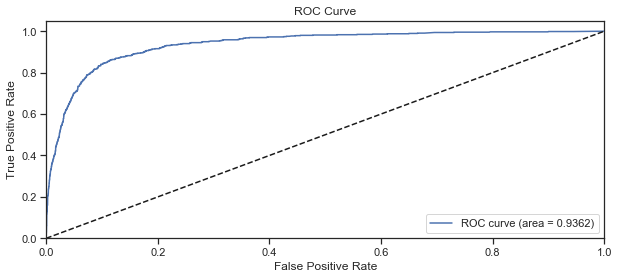

In [549]:
Performance(Model=RF2,Y=y_test,X=X_test)

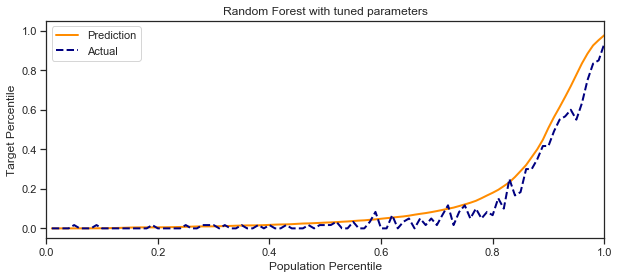

In [550]:
plotLiftChart(y_test.values,preds_probs_RFC,"Random Forest with tuned parameters")

In [466]:
importances = RF2.feature_importances_
col_names =  X.columns

sorted_feature_importance = pd.DataFrame(sorted(zip(importances, list(col_names)), reverse=True),columns={'colName','value'})
sorted_feature_importance

value                        colName
0     0.15                   loc_ic_mou_8
1     0.07               loc_og_t2m_mou_8
2     0.05               loc_ic_t2m_mou_8
3     0.05                   loc_og_mou_8
4     0.04             last_day_rch_amt_8
5     0.03       date_of_last_rech_8diff7
6     0.03        date_of_last_rech_day_8
7     0.02          total_rech_amt_8diff7
8     0.02                         arpu_8
9     0.01                   offnet_mou_8
10    0.01             roam_og_mou_8diff7
11    0.01                     aug_vbc_3g
12    0.01                  roam_og_mou_8
13    0.01               loc_ic_t2t_mou_8
14    0.01                max_rech_data_8
15    0.01               loc_og_t2t_mou_8
16    0.01                            aon
17    0.01                 max_rech_amt_8
18    0.01             av_rech_amt_data_8
19    0.01            total_ic_mou_8diff7
20    0.01                    vol_2g_mb_8
21    0.01                    vol_3g_mb_8
22    0.01              loc_ic_mou_8diff7
23    0.01              std_og_mou_8diff7
24    0.01                   AVG_arpu_6_7
25    0.01                  roam_ic_mou_8
26    0.01          loc_ic_t2t_mou_8diff7
27    0.01          loc_og_t2t_mou_8diff7
28    0.01          loc_ic_t2m_mou_8diff7
29    0.01              loc_og_mou_8diff7
30    0.01                    onnet_mou_8
31    0.01          loc_og_t2m_mou_8diff7
32    0.01          total_rech_amt_7diff6
33    0.00             AVG_std_og_mou_6_7
34    0.00          loc_og_t2m_mou_7diff6
35    0.00          loc_ic_t2m_mou_7diff6
36    0.00               loc_ic_t2f_mou_8
37    0.00                   std_ic_mou_8
38    0.00  date_of_last_rech_data_8diff7
39    0.00                   std_og_mou_8
40    0.00               vol_2g_mb_8diff7
41    0.00         AVG_loc_ic_t2t_mou_6_7
42    0.00          loc_ic_t2t_mou_7diff6
43    0.00                 max_rech_amt_6
44    0.00         AVG_loc_ic_t2m_mou_6_7
45    0.00          loc_og_t2t_mou_7diff6
46    0.00             AVG_loc_ic_mou_6_7
47    0.00              loc_og_mou_7diff6
48    0.00          std_ic_t2m_mou_8diff7
49    0.00               total_rech_num_8
50    0.00          std_og_t2m_mou_8diff7
51    0.00             AVG_offnet_mou_6_7
52    0.00             AVG_loc_og_mou_6_7
53    0.00         AVG_loc_og_t2m_mou_6_7
54    0.00               loc_og_t2f_mou_8
55    0.00               vol_2g_mb_7diff6
56    0.00                 max_rech_amt_7
57    0.00           AVG_total_og_mou_6_7
58    0.00       date_of_last_rech_7diff6
59    0.00              AVG_onnet_mou_6_7
60    0.00             last_day_rch_amt_7
61    0.00   date_of_last_rech_data_day_8
62    0.00          std_og_t2t_mou_8diff7
63    0.00          std_og_t2m_mou_7diff6
64    0.00          loc_ic_t2f_mou_7diff6
65    0.00              loc_ic_mou_7diff6
66    0.00          std_ic_t2m_mou_7diff6
67    0.00          std_og_t2t_mou_7diff6
68    0.00             roam_ic_mou_8diff7
69    0.00              std_ic_mou_8diff7
70    0.00         AVG_loc_ic_t2f_mou_6_7
71    0.00         AVG_loc_og_t2t_mou_6_7
72    0.00              std_ic_mou_7diff6
73    0.00               vol_3g_mb_8diff7
74    0.00                 AVG_vbc_3g_6_7
75    0.00              AVG_vol_2g_mb_6_7
76    0.00              spl_og_mou_7diff6
77    0.00          loc_ic_t2f_mou_8diff7
78    0.00          std_ic_t2t_mou_7diff6
79    0.00             AVG_spl_og_mou_6_7
80    0.00              spl_og_mou_8diff7
81    0.00              std_og_mou_7diff6
82    0.00             last_day_rch_amt_6
83    0.00            AVG_roam_og_mou_6_7
84    0.00         AVG_std_ic_t2m_mou_6_7
85    0.00          std_ic_t2t_mou_8diff7
86    0.00               std_ic_t2m_mou_8
87    0.00            AVG_roam_ic_mou_6_7
88    0.00        date_of_last_rech_day_6
89    0.00                  vbc_3g_8diff7
90    0.00             AVG_std_ic_mou_6_7
91    0.00         AVG_loc_og_t2f_mou_6_7
92    0.00         AVG_std_og_t2m_mou_6_7
93    0.00                  vbc_3g_7diff6
94    0.00     

<Figure size 720x288 with 0 Axes>

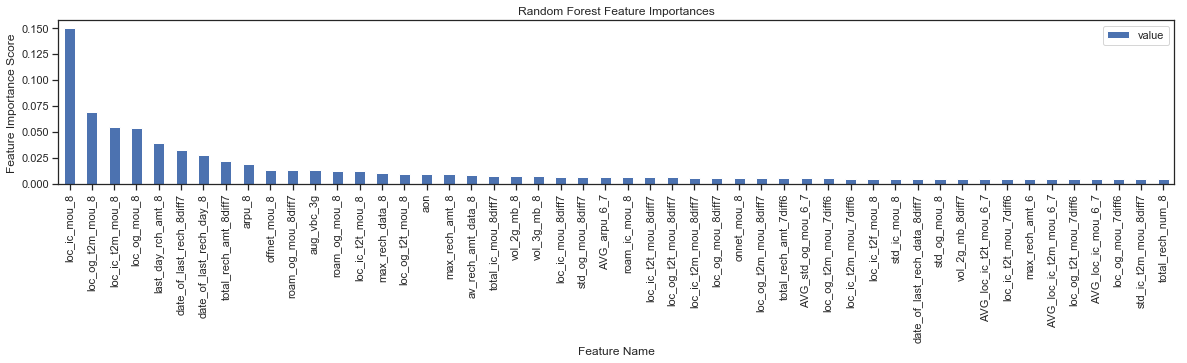

In [467]:
plt.clf()
from pylab import rcParams
rcParams['figure.figsize'] = 20, 3
sorted_feature_importance[0:50].plot(x='colName', y='value' , kind='bar', title='Random Forest Feature Importances')
plt.ylabel('Feature Importance Score')
plt.xlabel('Feature Name')

plt.show()

### Support Vector Machine


Support Vector Machine (SVM) is an algorithm used for classification problems similar to Logistic Regression (LR). LR and SVM with linear Kernel generally perform comparably in practice. <br> The objective of the support vector machine algorithm is to find the hyperplane that has the maximum margin in an N-dimensional space that distinctly classifies the data points. Data points falling on either side of the hyperplane can be attributed to different classes. <br> The dimension of the hyperplane depends upon the number of features. If the number of input features is 2, then the hyperplane is just a line. If the number of input features is 3, then the hyperplane becomes a two-dimensional plane. Support vectors are data points that are closer to the hyperplane and influence the position and orientation of the hyperplane. Using these support vectors, we maximize the margin of the classifier. Deleting the support vectors will change the position of the hyperplane.

In [420]:
from sklearn import svm 

svm_linear = svm.SVC(kernel='linear')
svm_linear.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

              precision    recall  f1-score   support

           0       0.91      1.00      0.95      5339
           1       0.87      0.19      0.31       652

   micro avg       0.91      0.91      0.91      5991
   macro avg       0.89      0.59      0.63      5991
weighted avg       0.90      0.91      0.88      5991

Accuracy for the test dataset 90.8%
ROC for the test dataset 59.2%


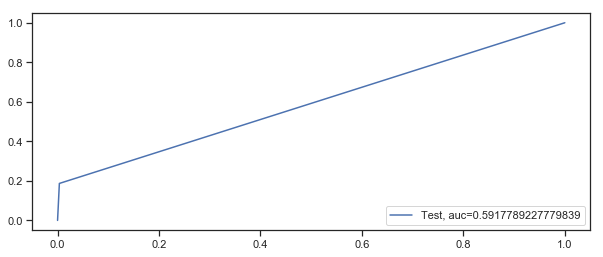

In [423]:
preds_SVM_lin = svm_linear.predict(X_test)
#preds_SVM_lin_probs = svm_linear.predict_proba(X_test)[:,1]

print(classification_report(y_test, preds_SVM_lin))
accuracy = metrics.accuracy_score(y_test, preds_SVM_lin)
print("Accuracy for the test dataset",'{:.1%}'.format(accuracy) )

fpr, tpr, threshold = metrics.roc_curve(y_test, preds_SVM_lin)
roc_auc = metrics.auc(fpr, tpr)
print("ROC for the test dataset",'{:.1%}'.format(roc_auc))
plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
plt.legend(loc=4)
plt.show()

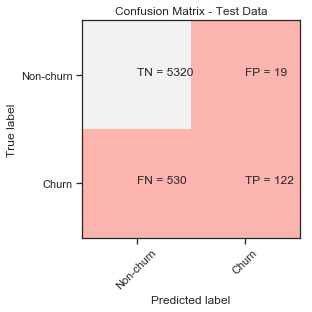

In [424]:
cm = confusion_matrix(y_test, preds_SVM_lin)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Pastel1)
classNames = ['Non-churn','Churn']
plt.title('Confusion Matrix - Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]),fontsize=12)
plt.show()

### SVM with Non linear kernal

Radial Basis Function (RBF)

In [425]:
svm_rbf = svm.SVC(kernel='rbf')
svm_rbf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

              precision    recall  f1-score   support

           0       0.93      0.98      0.96      5339
           1       0.74      0.43      0.55       652

   micro avg       0.92      0.92      0.92      5991
   macro avg       0.84      0.71      0.75      5991
weighted avg       0.91      0.92      0.91      5991

Accuracy for the test dataset 92.2%
ROC for the test dataset 70.8%


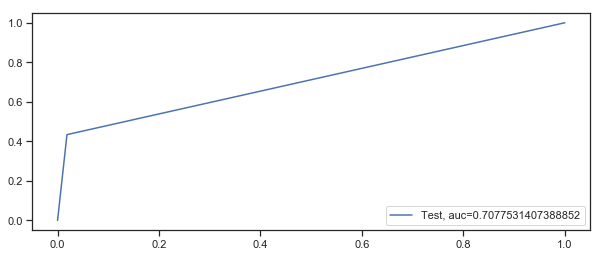

In [426]:
preds_SVM_rbf = svm_rbf.predict(X_test)
#preds_SVM_rbf_probs = svm_rbf.predict_proba(X_test)[:,1]

print(classification_report(y_test, preds_SVM_rbf))
accuracy = metrics.accuracy_score(y_test, preds_SVM_rbf)
print("Accuracy for the test dataset",'{:.1%}'.format(accuracy) )

fpr, tpr, threshold = metrics.roc_curve(y_test, preds_SVM_rbf)
roc_auc = metrics.auc(fpr, tpr)
print("ROC for the test dataset",'{:.1%}'.format(roc_auc))
plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
plt.legend(loc=4)
plt.show()

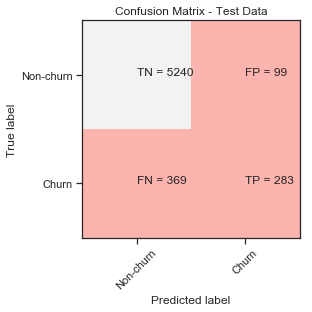

In [427]:
cm = confusion_matrix(y_test, preds_SVM_rbf)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Pastel1)
classNames = ['Non-churn','Churn']
plt.title('Confusion Matrix - Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]),fontsize=12)
plt.show()

### Ada Boost(Adaptive Boost)

In [435]:
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
# base estimator: a weak learner with max_depth=2
shallow_tree = DecisionTreeClassifier(max_depth=2, random_state = 100)
# fit the shallow decision tree 
shallow_tree.fit(X_train, y_train)
# test error
y_pred = shallow_tree.predict(X_test)
score = metrics.accuracy_score(y_test, y_pred)
score

0.9218828242363545

In [436]:
# adaboost with the tree as base estimator

estimators = list(range(50, 100, 3))

abc_scores = []
for n_est in estimators:
    ABC = AdaBoostClassifier(
    base_estimator=shallow_tree, 
    n_estimators = n_est)
    
    ABC.fit(X_train, y_train)
    y_pred = ABC.predict(X_test)
    score = metrics.accuracy_score(y_test, y_pred)
    abc_scores.append(score)

In [437]:
abc_scores

[0.9210482390252045,
 0.9222166583208146,
 0.9215489901518945,
 0.9230512435319647,
 0.9240527457853447,
 0.9233850776164246,
 0.9210482390252045,
 0.9220497412785845,
 0.9217159071941246,
 0.9218828242363545,
 0.9217159071941246,
 0.9210482390252045,
 0.9212151560674345,
 0.9217159071941246,
 0.9213820731096645,
 0.9213820731096645,
 0.9203805708562844]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      5339
           1       0.71      0.48      0.57       652

   micro avg       0.92      0.92      0.92      5991
   macro avg       0.82      0.73      0.77      5991
weighted avg       0.91      0.92      0.92      5991

Accuracy for the test dataset 92.2%
ROC for the test dataset 72.9%


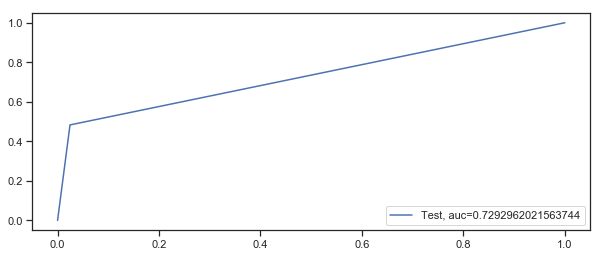

In [438]:
#after seseing the above score we can say that adaboost is providing better results when estimate is 1
ABC = AdaBoostClassifier(
base_estimator=shallow_tree, 
    n_estimators = 1)
    
ABC.fit(X_train, y_train)
predictions = ABC.predict(X_test)
score = metrics.accuracy_score(y_test, predictions)
accuracy = metrics.accuracy_score(y_test, predictions)
print("Classification Report:")
print(classification_report(y_test,predictions))
fpr, tpr, threshold = metrics.roc_curve(y_test, predictions)
roc_auc = metrics.auc(fpr, tpr)
print("Accuracy for the test dataset",'{:.1%}'.format(accuracy) )
print("ROC for the test dataset",'{:.1%}'.format(roc_auc))
plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
plt.legend(loc=4)
plt.show()

Accuracy for the test dataset 92.0%
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      5339
           1       0.65      0.57      0.61       652

   micro avg       0.92      0.92      0.92      5991
   macro avg       0.80      0.76      0.78      5991
weighted avg       0.92      0.92      0.92      5991

ROC for the test dataset 76.5%


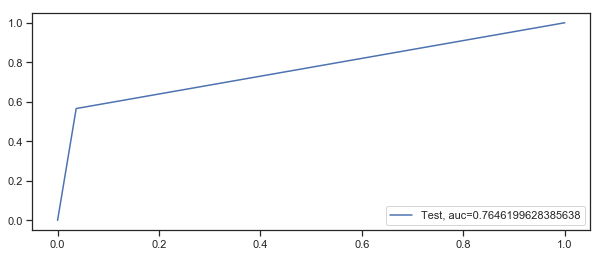

In [439]:
# Let's test on 100 trees
ABC = AdaBoostClassifier(
base_estimator=shallow_tree, 
    n_estimators = 100)
    
ABC.fit(X_train, y_train)
predictions = ABC.predict(X_test)
score = metrics.accuracy_score(y_test, predictions)
accuracy = metrics.accuracy_score(y_test, predictions)
print("Accuracy for the test dataset",'{:.1%}'.format(accuracy) )
print(classification_report(y_test,predictions))
fpr, tpr, threshold = metrics.roc_curve(y_test, predictions)
roc_auc = metrics.auc(fpr, tpr)
print("ROC for the test dataset",'{:.1%}'.format(roc_auc))
plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
plt.legend(loc=4)
plt.show()

### Naive Bayes

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.92      0.94      5339
           1       0.49      0.61      0.54       652

   micro avg       0.89      0.89      0.89      5991
   macro avg       0.72      0.77      0.74      5991
weighted avg       0.90      0.89      0.89      5991

Accuracy for the test dataset 88.9%
ROC for the test dataset 76.7%


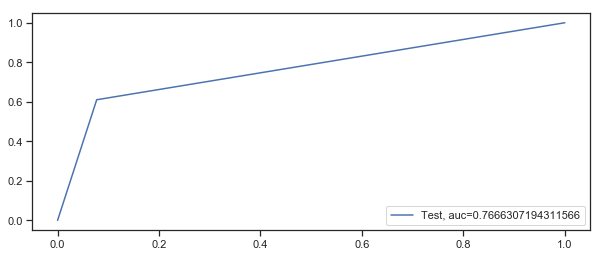

In [440]:
# training the NB model and making predictions
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler
Minmaxscaler = MinMaxScaler()
X_scaled = Minmaxscaler.fit_transform(X)

X_train_NB, X_test_NB, y_train_NB, y_test_NB = train_test_split(X_scaled,Y, train_size=0.8,test_size=0.2,random_state=111)

mnb = MultinomialNB()

# fit
mnb.fit(X_train_NB,y_train_NB)

# predict class
predictions = mnb.predict(X_test_NB)

# predict probabilities
y_pred_proba = mnb.predict_proba(X_test_NB)
accuracy = metrics.accuracy_score(y_test_NB, predictions)
print("Classification Report:")
print(classification_report(y_test_NB,predictions))
fpr, tpr, threshold = metrics.roc_curve(y_test_NB, predictions)
roc_auc = metrics.auc(fpr, tpr)
print("Accuracy for the test dataset",'{:.1%}'.format(accuracy) )
print("ROC for the test dataset",'{:.1%}'.format(roc_auc))
plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
plt.legend(loc=4)
plt.show()

### Imbalanced Data sets
- Machine Learning algorithms tend to produce unsatisfactory classifiers when faced with imbalanced datasets.
    For any imbalanced data set, if the event to be predicted belongs to the minority class and the event rate is less than 5%,
    it is usually referred to as a rare event.
- Standard classifier algorithms like Decision Tree and Logistic Regression have a bias towards classes which have number of instances. They tend to only predict the majority class data. The features of the minority class are treated as noise and are often ignored. Thus, there is a high probability of misclassification of the minority class as compared to the majority class
### Approaches to handle Imbalanced data sets
- Resampling Technique
- Algorithmic Ensemble techinique


### Resampling techniques for Balancing the data set

### Resampling Techniques:
- Random under sampling
    - Balance class distribution by randomly eliminating majority class examples.  This is done until the majority and minority class instances are balanced out.
    
- Random Over sampling
    - Increase the number of instances in the minority class by randomly replicating them in order to present a higher representation of the minority class in the sample.
    
- Cluster based over sampling
    - the K-means clustering algorithm is independently applied to minority and majority class instances. This is to identify clusters in the dataset. Subsequently, each cluster is oversampled such that all clusters of the same class have an equal number of instances and all classes have the same size.
    
- Synthetic Minority Over sampling Technique (SMOTE)
    - This technique is followed to avoid overfitting which occurs when exact replicas of minority instances are added to the main dataset. A subset of data is taken from the minority class as an example and then new synthetic similar instances are created. These synthetic instances are then added to the original dataset. The new dataset is used as a sample to train the classification models.
    
- Modified Synthetic Minority Oversampling Technique (MSMOTE)
    - While the basic flow of MSOMTE is the same as that of SMOTE (discussed in the previous section).  In MSMOTE the strategy of selecting nearest neighbors is different from SMOTE. The algorithm randomly selects a data point from the k nearest neighbors for the security sample, selects the nearest neighbor from the border samples and does nothing for latent noise.

### Algorithmic Ensemble Technique:
- Bagging Based
    - Bagging is an abbreviation of Bootstrap Aggregating. The conventional bagging algorithm involves generating ‘n’ different bootstrap training samples with replacement. And training the algorithm on each bootstrapped algorithm separately and then aggregating the predictions at the end
    - Bagging is used for reducing Overfitting in order to create strong learners for generating accurate predictions. Unlike boosting, bagging allows replacement in the bootstrapped sample.
    
- Boosting Based
     - Boosting is an ensemble technique to combine weak learners to create a strong learner that can make accurate predictions. 
      - Boosting starts out with a base classifier / weak classifier that is prepared on the training data.
- Different Boosting Methods:
      - Ada Boost
      - Gradient Tree Boosting
      - XG Boost

### Random Over Sampling

In [368]:
from imblearn.over_sampling import SMOTE

print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (23962, 203)
Number transactions y_train dataset:  (23962,)
Number transactions X_test dataset:  (5991, 203)
Number transactions y_test dataset:  (5991,)


In [369]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

Before OverSampling, counts of label '1': 2603
Before OverSampling, counts of label '0': 21359 

After OverSampling, the shape of train_X: (42718, 203)
After OverSampling, the shape of train_y: (42718,) 

After OverSampling, counts of label '1': 21359
After OverSampling, counts of label '0': 21359


## Logistic Regression with penalty

On resampled dataset

In [370]:
from sklearn.linear_model import LogisticRegressionCV

searchCV = LogisticRegressionCV(
        Cs= list(np.power(10.0, np.arange(-10, 10)))
        ,penalty='l2'
        ,scoring='roc_auc'
        ,cv=stratefied_Kfold
        ,random_state=777
        ,max_iter=100
        ,fit_intercept=True
        ,solver='newton-cg'
        ,tol=1
        ,verbose = 2
        ,n_jobs = -1
    
    )

In [371]:
searchCV.fit(X_train_res,y_train_res)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   50.3s finished


LogisticRegressionCV(Cs=[1e-10, 1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0, 1000000.0, 10000000.0, 100000000.0, 1000000000.0],
           class_weight=None,
           cv=StratifiedKFold(n_splits=4, random_state=9999, shuffle=True),
           dual=False, fit_intercept=True, intercept_scaling=1.0,
           max_iter=100, multi_class='warn', n_jobs=-1, penalty='l2',
           random_state=777, refit=True, scoring='roc_auc',
           solver='newton-cg', tol=1, verbose=2)

              precision    recall  f1-score   support

           0       0.97      0.85      0.91      5339
           1       0.40      0.81      0.53       652

   micro avg       0.85      0.85      0.85      5991
   macro avg       0.69      0.83      0.72      5991
weighted avg       0.91      0.85      0.87      5991

Accuracy for the train dataset 84.5%
ROC for the train dataset 89.6%


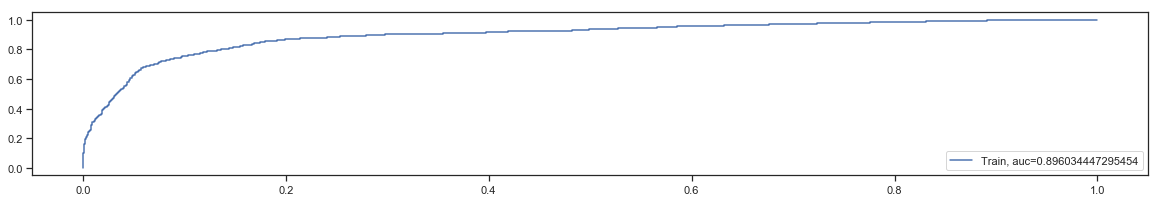

In [372]:
#train data
preds_L2Search = searchCV.predict(X_test)
preds_L2Search_probs = searchCV.predict_proba(X_test)[:,1]

print(classification_report(y_test, preds_L2Search))
accuracy = metrics.accuracy_score(y_test, preds_L2Search)
print("Accuracy for the test dataset",'{:.1%}'.format(accuracy) )

fpr, tpr, threshold = metrics.roc_curve(y_test, preds_L2Search_probs)
roc_auc = metrics.auc(fpr, tpr)
print("ROC for the test dataset",'{:.1%}'.format(roc_auc))
plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
plt.legend(loc=4)
plt.show()


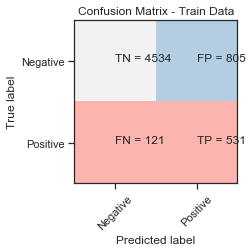

In [373]:
cm = confusion_matrix(y_test, preds_L2Search)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Pastel1)
classNames = ['Non-churn','Churn']
plt.title('Confusion Matrix - Train Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]),fontsize=12)
plt.show()

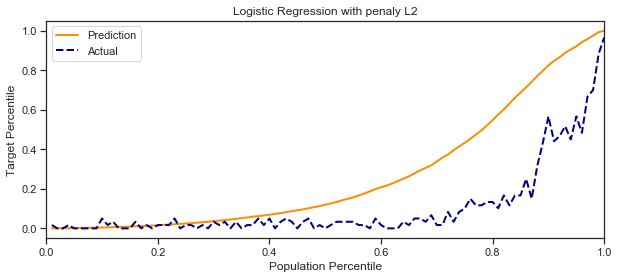

In [417]:
plotLiftChart(y_test.values,preds_L2Search_probs,"Logistic Regression with penaly L2")

### Random Forest

On resampled dataset

In [374]:
TrainedRFC= RFC_balanced.fit(X_train_res,y_train_res)

C:\Users\vm5.CORPDOM\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\tree\tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
C:\Users\vm5.CORPDOM\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\tree\tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
C:\Users\vm5.CORPDOM\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\tree\tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
C:\U

              precision    recall  f1-score   support

           0       0.96      0.92      0.94      5339
           1       0.52      0.72      0.60       652

   micro avg       0.90      0.90      0.90      5991
   macro avg       0.74      0.82      0.77      5991
weighted avg       0.92      0.90      0.90      5991

Accuracy for the test dataset 89.7%
ROC for the test dataset 91.6%


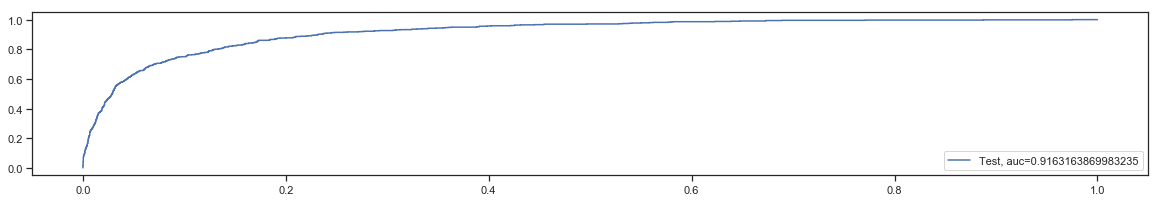

In [375]:
preds_RFC=TrainedRFC.predict(X_test)
preds_probs_RFC=TrainedRFC.predict_proba(X_test)[:,1]

print(classification_report(y_test, preds_RFC))
accuracy = metrics.accuracy_score(y_test, preds_RFC)
print("Accuracy for the test dataset",'{:.1%}'.format(accuracy) )

fpr, tpr, threshold = metrics.roc_curve(y_test, preds_probs_RFC)
roc_auc = metrics.auc(fpr, tpr)
print("ROC for the test dataset",'{:.1%}'.format(roc_auc))
plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
plt.legend(loc=4)
plt.show()

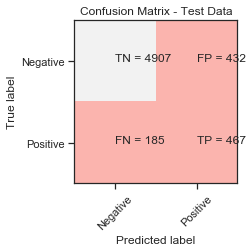

In [376]:
cm = confusion_matrix(y_test, preds_RFC)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Pastel1)
classNames = ['Non-churn','Churn']
plt.title('Confusion Matrix - Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]),fontsize=12)
plt.show()

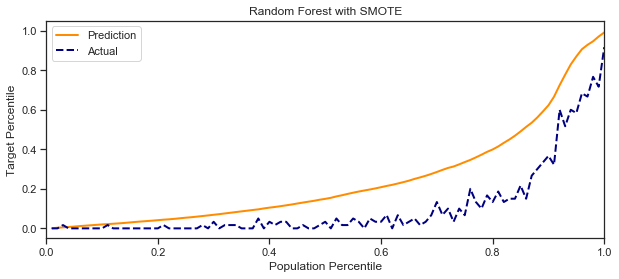

In [418]:
plotLiftChart(y_test.values,preds_probs_RFC,"Random Forest with SMOTE")

In [377]:
importances = TrainedRFC.feature_importances_
col_names =  X.columns

sorted_feature_importance = pd.DataFrame(sorted(zip(importances, list(col_names)), reverse=True),columns={'colName','value'})
sorted_feature_importance

value                        colName
0     0.10                   loc_ic_mou_8
1     0.09               loc_og_t2t_mou_8
2     0.08         is_loc_ic_t2m_mou_flag
3     0.07                   offnet_mou_8
4     0.05                         arpu_8
5     0.05               loc_ic_t2t_mou_8
6     0.05         is_loc_og_t2m_mou_flag
7     0.04               loc_ic_t2m_mou_8
8     0.04        date_of_last_rech_day_8
9     0.04             is_loc_ic_mou_flag
10    0.02                 max_rech_amt_8
11    0.02         is_loc_og_t2f_mou_flag
12    0.02                   loc_og_mou_8
13    0.01         is_std_og_t2m_mou_flag
14    0.01             is_offnet_mou_flag
15    0.01         is_loc_ic_t2f_mou_flag
16    0.01         is_loc_ic_t2t_mou_flag
17    0.01                     aug_vbc_3g
18    0.01             is_loc_og_mou_flag
19    0.01             is_std_ic_mou_flag
20    0.01         is_loc_og_t2t_mou_flag
21    0.01         is_std_ic_t2m_mou_flag
22    0.01                  roam_ic_mou_8
23    0.01            is_roam_og_mou_flag
24    0.01              std_og_mou_8diff7
25    0.01          total_rech_amt_8diff7
26    0.01              is_vol_2g_mb_flag
27    0.01       date_of_last_rech_8diff7
28    0.01         is_total_rech_amt_flag
29    0.01           is_total_og_mou_flag
30    0.01             is_spl_og_mou_flag
31    0.01             is_std_og_mou_flag
32    0.01             roam_og_mou_8diff7
33    0.01              is_vol_3g_mb_flag
34    0.01                      fb_user_8
35    0.01                  roam_og_mou_8
36    0.00           is_total_ic_mou_flag
37    0.00              is_onnet_mou_flag
38    0.00               loc_og_t2m_mou_8
39    0.00             last_day_rch_amt_8
40    0.00             roam_ic_mou_8diff7
41    0.00             AVG_offnet_mou_6_7
42    0.00              is_ic_others_flag
43    0.00                    vol_3g_mb_8
44    0.00              loc_ic_mou_8diff7
45    0.00         is_std_ic_t2t_mou_flag
46    0.00            is_roam_ic_mou_flag
47    0.00          std_og_t2t_mou_8diff7
48    0.00                max_rech_data_8
49    0.00             AVG_std_og_mou_6_7
50    0.00              total_rech_data_8
51    0.00                 is_vbc_3g_flag
52    0.00             av_rech_amt_data_8
53    0.00                AVG_fb_user_6_7
54    0.00          loc_og_t2t_mou_8diff7
55    0.00                   std_og_mou_8
56    0.00                  vbc_3g_8diff7
57    0.00                   AVG_arpu_6_7
58    0.00         is_std_ic_t2f_mou_flag
59    0.00             AVG_loc_ic_mou_6_7
60    0.00                 max_rech_amt_7
61    0.00          std_og_t2m_mou_8diff7
62    0.00         is_std_og_t2t_mou_flag
63    0.00               total_rech_num_8
64    0.00                            aon
65    0.00         AVG_loc_ic_t2t_mou_6_7
66    0.00                      arpu_3g_8
67    0.00            total_ic_mou_8diff7
68    0.00         AVG_loc_og_t2m_mou_6_7
69    0.00            AVG_roam_og_mou_6_7
70    0.00             AVG_spl_og_mou_6_7
71    0.00         AVG_loc_ic_t2m_mou_6_7
72    0.00         is_loc_og_t2c_mou_flag
73    0.00             last_day_rch_amt_6
74    0.00                    onnet_mou_8
75    0.00             is_isd_ic_mou_flag
76    0.00               loc_og_t2f_mou_8
77    0.00                 max_rech_amt_6
78    0.00             is_spl_ic_mou_flag
79    0.00          loc_ic_t2t_mou_8diff7
80    0.00                 AVG_vbc_3g_6_7
81    0.00   date_of_last_rech_data_day_8
82    0.00              AVG_vol_3g_mb_6_7
83    0.00        date_of_last_rech_day_7
84    0.00          loc_ic_t2m_mou_8diff7
85    0.00         AVG_loc_og_t2c_mou_6_7
86    0.00             AVG_monthly_3g_6_7
87    0.00               og_others_7diff6
88    0.00            AVG_roam_ic_mou_6_7
89    0.00             AVG_monthly_2g_6_7
90    0.00          loc_og_t2f_mou_8diff7
91    0.00              total_rech_data_6
92    0.00                    vol_2g_mb_8
93    0.00              spl_og_mou_8diff7
94    0.00     

<Figure size 1440x216 with 0 Axes>

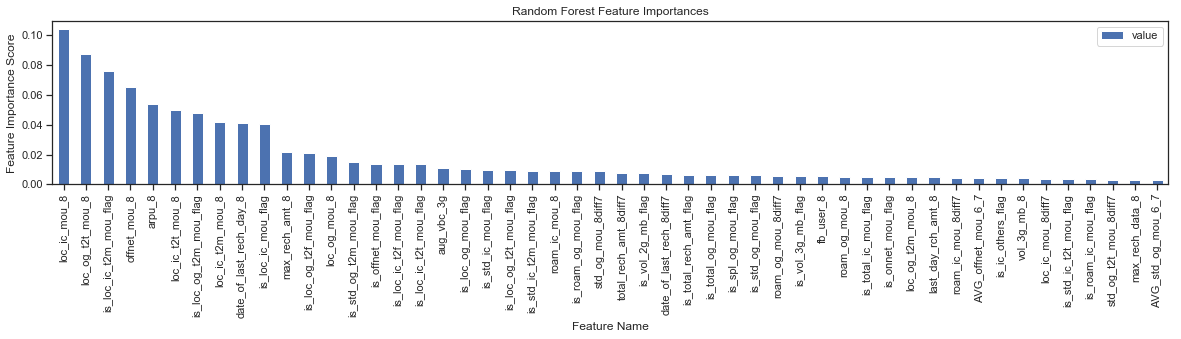

In [378]:
plt.clf()
from pylab import rcParams
rcParams['figure.figsize'] = 20, 3
sorted_feature_importance[0:50].plot(x='colName', y='value' , kind='bar', title='Random Forest Feature Importances')
plt.ylabel('Feature Importance Score')
plt.xlabel('Feature Name')

plt.show()

### XG Boost

On resampled data

In [498]:

xgb_model = xgb.XGBClassifier(
    n_estimators=250,
    learning_rate=0.05,
    n_jobs=4,
    max_depth=8,
    colsample_bytree=0.55,
    gamma=0.23,
    cv = None,
    scoring='f1_weighted'
)

xgb_model1 = xgb_model.fit(X_train_res,y_train_res)

In [499]:
predictions_train = xgb_model1.predict(X_train_res)
print(classification_report(y_train_res, predictions_train))
predictions = xgb_model1.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     21359
           1       0.99      1.00      0.99     21359

   micro avg       0.99      0.99      0.99     42718
   macro avg       0.99      0.99      0.99     42718
weighted avg       0.99      0.99      0.99     42718

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      5339
           1       0.67      0.65      0.66       652

   micro avg       0.93      0.93      0.93      5991
   macro avg       0.81      0.81      0.81      5991
weighted avg       0.93      0.93      0.93      5991



In [500]:
from sklearn.metrics import accuracy_score,precision_recall_fscore_support,fbeta_score
accuracy = accuracy_score(y_test, predictions)
precision_recall_fscore_support(y_test, predictions, average='macro')
precision, recall, f1score,blah  = precision_recall_fscore_support(y_test, predictions, average='macro')
fbetascore = fbeta_score(y_test, predictions, average='weighted', beta=0.8)
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
specificity = tn / (tn+fp)
sensitivity = tp / (tp+fn)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Precision: %.2f%%" % (precision*100))
print("Recall: %.2f%%" % (recall*100))
print("F1 Score: %.2f%%" % (f1score*100))
print("F Beta score: %.2f%%" % (fbetascore*100))
print("Specificity: %.2f%%" % (specificity*100))
print("Sensitivty: %.2f%%" % (sensitivity*100))

Accuracy: 92.69%
Precision: 81.26%
Recall: 80.75%
F1 Score: 81.00%
F Beta score: 92.65%
Specificity: 96.01%
Sensitivty: 65.49%


the AUC is : 0.9327


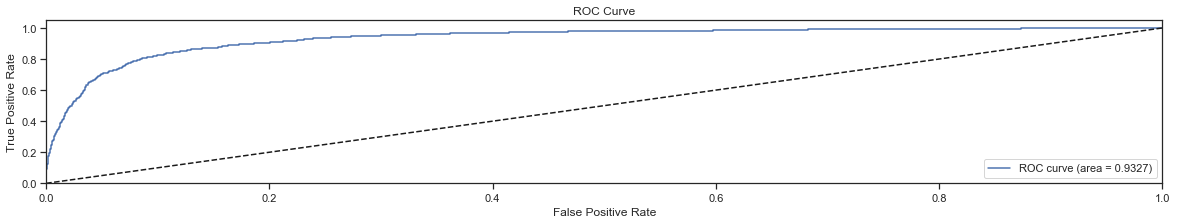

In [501]:
Performance(Model=xgb_model1,Y=y_test,X=X_test)

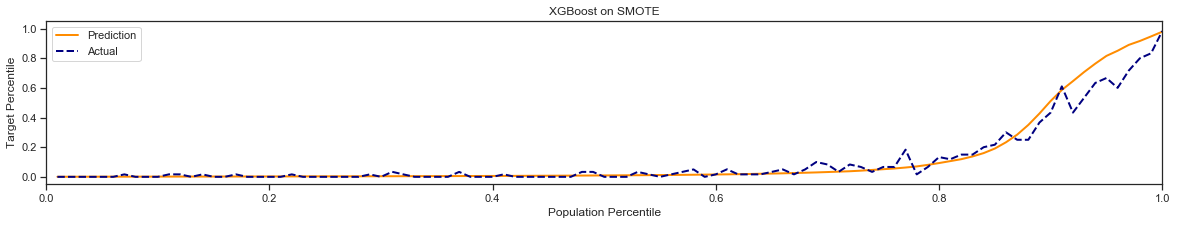

In [502]:
plotLiftChart(y_test.values,xgb_model1.predict_proba(X_test)[:,1],"XGBoost on SMOTE")

In [503]:
importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_model1.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)
importances = importances.set_index('Feature')
importances

Importance
Feature                                  
date_of_last_rech_day_8              0.03
date_of_last_rech_8diff7             0.02
last_day_rch_amt_8                   0.02
total_rech_num_8                     0.01
aon                                  0.01
total_rech_amt_8diff7                0.01
date_of_last_rech_day_6              0.01
date_of_last_rech_7diff6             0.01
arpu_8                               0.01
AVG_arpu_6_7                         0.01
last_day_rch_amt_7                   0.01
loc_ic_mou_8                         0.01
last_day_rch_amt_6                   0.01
offnet_mou_8                         0.01
total_rech_amt_7diff6                0.01
aug_vbc_3g                           0.01
roam_og_mou_8diff7                   0.01
AVG_loc_ic_t2t_mou_6_7               0.01
max_rech_amt_8                       0.01
vol_2g_mb_8diff7                     0.01
AVG_total_og_mou_6_7                 0.01
loc_og_mou_8diff7                    0.01
max_rech_amt_7                       0.01
roam_og_mou_8                        0.01
max_rech_amt_6                       0.01
date_of_last_rech_day_7              0.01
loc_ic_t2m_mou_8                     0.01
std_og_t2t_mou_7diff6                0.01
vol_2g_mb_7diff6                     0.01
loc_ic_t2t_mou_8diff7                0.01
AVG_loc_ic_t2m_mou_6_7               0.01
total_ic_mou_8diff7                  0.01
loc_ic_t2m_mou_8diff7                0.01
AVG_loc_ic_mou_6_7                   0.01
AVG_onnet_mou_6_7                    0.01
loc_og_t2m_mou_8                     0.01
loc_og_mou_8                         0.01
AVG_offnet_mou_6_7                   0.01
loc_og_t2t_mou_7diff6                0.01
std_og_mou_8diff7                    0.01
loc_ic_t2m_mou_7diff6                0.01
AVG_vbc_3g_6_7                       0.01
AVG_std_ic_mou_6_7                   0.01
loc_og_mou_7diff6                    0.01
spl_og_mou_7diff6                    0.01
AVG_spl_og_mou_6_7                   0.01
loc_og_t2m_mou_8diff7                0.01
spl_og_mou_8diff7                    0.01
std_og_mou_8                         0.01
loc_ic_mou_7diff6                    0.01
loc_og_t2m_mou_7diff6                0.01
vol_2g_mb_8                          0.01
loc_ic_t2t_mou_7diff6                0.01
std_ic_t2m_mou_8diff7                0.01
std_ic_mou_7diff6                    0.01
std_ic_mou_8diff7                    0.01
date_of_last_rech_data_7diff6        0.01
AVG_loc_og_t2m_mou_6_7               0.01
onnet_mou_8                          0.01
is_loc_ic_t2t_mou_flag               0.01
roam_ic_mou_8                        0.01
AVG_std_og_t2m_mou_6_7               0.01
std_og_t2m_mou_7diff6                0.01
std_ic_mou_8                         0.01
AVG_std_ic_t2m_mou_6_7               0.01
std_ic_t2t_mou_7diff6                0.01
loc_ic_t2t_mou_8                     0.01
loc_ic_mou_8diff7                    0.01
AVG_vol_2g_mb_6_7                    0.01
is_loc_ic_t2f_mou_flag               0.01
std_og_t2t_mou_8diff7                0.01
std_ic_t2m_mou_7diff6                0.01
loc_ic_t2f_mou_8diff7                0.01
AVG_std_og_mou_6_7                   0.01
AVG_loc_og_mou_6_7                   0.01
loc_og_t2t_mou_8diff7                0.01
std_og_mou_7diff6                    0.01
AVG_roam_og_mou_6_7                  0.01
AVG_std_ic_t2t_mou_6_7               0.01
vol_3g_mb_8diff7                     0.01
AVG_loc_ic_t2f_mou_6_7               0.01
is_loc_ic_t2m_mou_flag               0.01
std_og_t2m_mou_8diff7                0.01
AVG_arpu_3g_6_7                      0.01
vbc_3g_7diff6                        0.01
roam_ic_mou_8diff7                   0.01
AVG_spl_ic_mou_6_7                   0.01
AVG_loc_og_t2f_mou_6_7               0.00
std_ic_t2m_mou_8                     0.00
vol_3g_mb_7diff6                     0.00
spl_og_mou_8                         0.00
loc_ic_t2f_mou_8                     0.00
loc_ic_t2f_mou_7diff6                0.00
av_rech_amt_data_8                   0.00

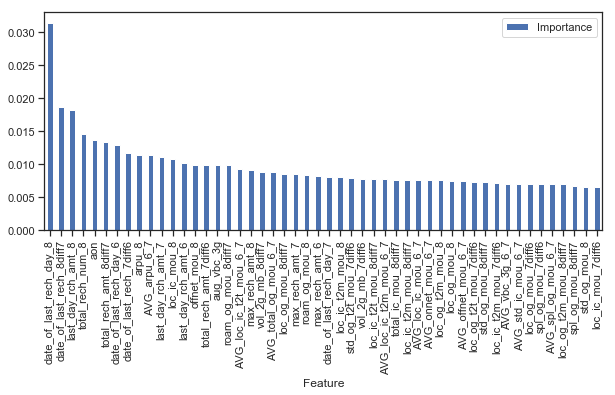

In [504]:
importances[0:50].plot.bar()

### SVM Linear

On a resampled data

In [428]:
svm_linear = svm.SVC(kernel='linear')
svm_linear.fit(X_train_res, y_train_res)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

              precision    recall  f1-score   support

           0       0.98      0.85      0.91      5339
           1       0.40      0.83      0.54       652

   micro avg       0.85      0.85      0.85      5991
   macro avg       0.69      0.84      0.73      5991
weighted avg       0.91      0.85      0.87      5991

Accuracy for the test dataset 84.8%
ROC for the test dataset 83.8%


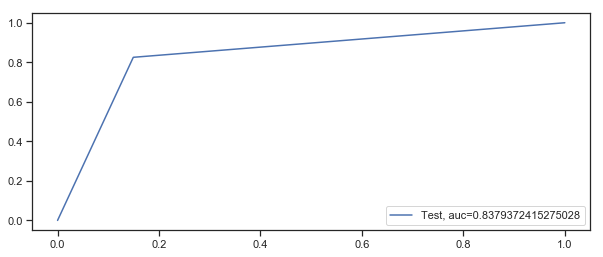

In [429]:
preds_SVM_li_RS = svm_linear.predict(X_test)
#preds_SVM_li_probs_RS = svm_linear.predict_proba(X_test)[:,1]

print(classification_report(y_test, preds_SVM_li_RS))
accuracy = metrics.accuracy_score(y_test, preds_SVM_li_RS)
print("Accuracy for the test dataset",'{:.1%}'.format(accuracy) )

fpr, tpr, threshold = metrics.roc_curve(y_test, preds_SVM_li_RS)
roc_auc = metrics.auc(fpr, tpr)
print("ROC for the test dataset",'{:.1%}'.format(roc_auc))
plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
plt.legend(loc=4)
plt.show()

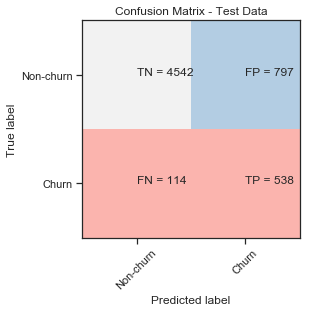

In [430]:
cm = confusion_matrix(y_test, preds_SVM_li_RS)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Pastel1)
classNames = ['Non-churn','Churn']
plt.title('Confusion Matrix - Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]),fontsize=12)
plt.show()

### SVM Non-linear (RBF)

On resampled data

In [431]:
svm_rbf = svm.SVC(kernel='rbf')
svm_rbf.fit(X_train_res, y_train_res)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

              precision    recall  f1-score   support

           0       0.97      0.91      0.94      5339
           1       0.51      0.77      0.61       652

   micro avg       0.89      0.89      0.89      5991
   macro avg       0.74      0.84      0.77      5991
weighted avg       0.92      0.89      0.90      5991

Accuracy for the test dataset 89.3%
ROC for the test dataset 83.8%


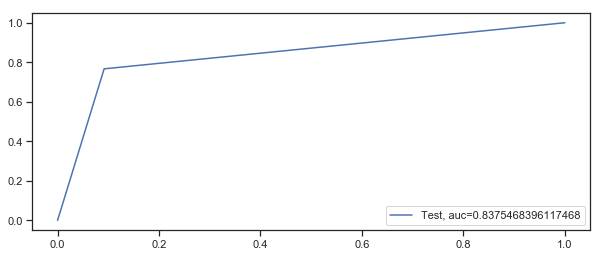

In [433]:
preds_SVM_RBF_RS = svm_rbf.predict(X_test)
#preds_SVM_RBF_probs_RS = svm_rbf.predict_proba(X_test)[:,1]

print(classification_report(y_test, preds_SVM_RBF_RS))
accuracy = metrics.accuracy_score(y_test, preds_SVM_RBF_RS)
print("Accuracy for the test dataset",'{:.1%}'.format(accuracy) )

fpr, tpr, threshold = metrics.roc_curve(y_test, preds_SVM_RBF_RS)
roc_auc = metrics.auc(fpr, tpr)
print("ROC for the test dataset",'{:.1%}'.format(roc_auc))
plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
plt.legend(loc=4)
plt.show()

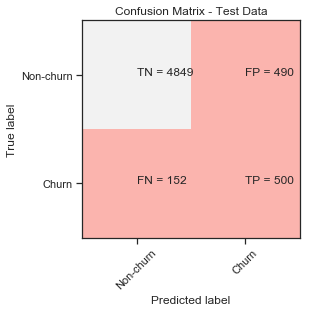

In [434]:
cm = confusion_matrix(y_test, preds_SVM_RBF_RS)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Pastel1)
classNames = ['Non-churn','Churn']
plt.title('Confusion Matrix - Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]),fontsize=12)
plt.show()

## Summary about the models

- We trained different machine learning models to solve this classification problems. 
- Both XGBoost and Random Forest Classifier performed the best when compared with other models.
- The **Algorithmic Ensemble Techniques** was able to provide the same performance of the models using the resampling techniques data (the performance is almost the same). So, with balanced class option & stratified K-fold we can still get the same scores without increasing the dataset size
- We considered F1-score and Area under the curve as the primary metrics for the evaluation 

#### Important features or indicators

In [551]:
importances = RF2.feature_importances_
col_names =  X.columns

RF_feature_importance = pd.DataFrame(sorted(zip(importances, list(col_names)), reverse=True),columns={'colName','value'})
RF_feature_importance.head()

value             colName
0   0.15        loc_ic_mou_8
1   0.07    loc_og_t2m_mou_8
2   0.05    loc_ic_t2m_mou_8
3   0.05        loc_og_mou_8
4   0.04  last_day_rch_amt_8

In [552]:
imp_features = RF_feature_importance.head(20)

In [553]:
X_imp = df[list(imp_features .colName.unique())]
Y_imp = df['churn_flag']

In [554]:
X_imp_std = scaler.fit_transform(X_imp)
X_imp_train, X_imp_test, y_imp_train, y_imp_test = train_test_split(X_imp_std,Y_imp, train_size=0.8,test_size=0.2,random_state=111)

In [478]:
RF_imp=RandomForestClassifier(n_estimators=200, criterion= 'entropy', max_depth=15,random_state=111, class_weight='balanced')
RF_imp.fit(X_imp_train, y_imp_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=15, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=None, oob_score=False,
            random_state=111, verbose=0, warm_start=False)

In [479]:
RF_imp_pred_test = RF_imp.predict(X_imp_test)
print(classification_report(y_imp_test, RF_imp_pred_test))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      5339
           1       0.65      0.64      0.64       652

   micro avg       0.92      0.92      0.92      5991
   macro avg       0.80      0.80      0.80      5991
weighted avg       0.92      0.92      0.92      5991



the AUC is : 0.9260


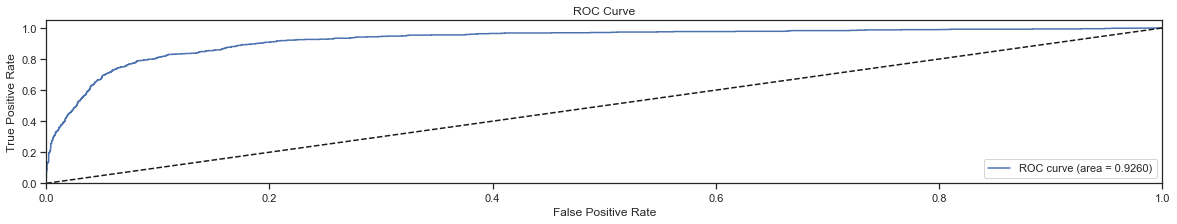

In [480]:
Performance(Model=RF_imp,Y=y_imp_test,X=X_imp_test)

We train our random forest algorithm on the top 20 features that we selected above and then we evaluated the performance of our algorithm on the training and testing sets. We can see the AUC & F1-score are pretty similar on training & test datasets which means our model is not overfitting.

In [481]:
imp_features

value                   colName
0    0.15              loc_ic_mou_8
1    0.07          loc_og_t2m_mou_8
2    0.05          loc_ic_t2m_mou_8
3    0.05              loc_og_mou_8
4    0.04        last_day_rch_amt_8
5    0.03  date_of_last_rech_8diff7
6    0.03   date_of_last_rech_day_8
7    0.02     total_rech_amt_8diff7
8    0.02                    arpu_8
9    0.01              offnet_mou_8
10   0.01        roam_og_mou_8diff7
11   0.01                aug_vbc_3g
12   0.01             roam_og_mou_8
13   0.01          loc_ic_t2t_mou_8
14   0.01           max_rech_data_8
15   0.01          loc_og_t2t_mou_8
16   0.01                       aon
17   0.01            max_rech_amt_8
18   0.01        av_rech_amt_data_8
19   0.01       total_ic_mou_8diff7

We can observe the top features selected by the XG Boost & Random Forest is similar. So, we can conclude that these are the important indicators of churn

## Recommendations to Business 

- From the above we can clearly infer that calls related incoming & outgoing within a circle is key for identifying churn customers
- Especially the usage during the action pahse when compared to good month (7th month) has reduced
- The other key factor is if the recharge amount shows a dip in the action phase is sign of churn
- Age on network is also a key indicator for identifying the churn, if aon is less than 500 days and their usage is reduce then the customer is going to be churned
- The usage of mobile data has also reduced when compared with 7th month. So, data usage & amount can also be the other features for understanding the churn behavior